In [1]:
# import packages
import pandas as pd
import pyarrow.dataset as ds
from datasets import Dataset
import pyarrow as pa
from datasets import *
from transformers import *
from tokenizers import *
import os
import json
import sys
from tokenizers.processors import BertProcessing
import numpy as np

C:\Users\XinZhou\anaconda3\envs\dna\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\XinZhou\anaconda3\envs\dna\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
# loading for different datasets

MAX_LENGTH = 1024
batch_size = 2
num_epochs = 1
max_step_saves = 3
save_step_at = 20
test_only = False
data_name = 'devign' # poj, devign, draper, d2a, mvdsc, sysevr
truncate_longer_samples = True
# is_windows = sys.platform.startswith('win')
# if is_windows:

data_dir = "..\\..\\cbert\\dna_data_raw"
out_dir = 'result_{}'.format(data_name)

# bert_model_path = '..\\pretrained-dna-albert\\checkpoint-100'
# tokenizer_path = '..\\tokenizer.model'

bert_model_path = 'albert-base-v2'
tokenizer_path = 'albert-base-v2'

# load data
def get_data(file_path):
    raw_df = pd.read_pickle(file_path)  
    df = {'filename': [], 'text': [], 'label': []}
    for i in range(len(raw_df['code'])):
        df['filename'].append(raw_df['filename'][i])
        code = raw_df['code'][i].split(';')
        code = ' '.join(code)
        df['text'].append(code)
        df['label'].append(raw_df['label'][i])
    df = pd.DataFrame(df)
    return df

# train_data = get_data('/scratch/xin/bert_source/mvdsc/tokenized_mvdsc_train.pkl')
# valid_data = get_data('/scratch/xin/bert_source/mvdsc/tokenized_mvdsc_valid.pkl')
if data_name == 'devign':
    raw_data_path = os.path.join(data_dir, data_name, 'devign_all.pkl')
    tokenized_data = get_data(raw_data_path)
    train_data, valid_data, test_data = np.split(tokenized_data.sample(frac=1, random_state=2022), 
                   [int(.8*len(tokenized_data)), int(.9*len(tokenized_data))])
elif data_name == 'mvdsc':
    raw_data_path = os.path.join(data_dir, data_name, 'mvdsc_mix_train.pkl')
    train_data = get_data(raw_data_path)
    raw_data_path = os.path.join(data_dir, data_name, 'mvdsc_mix_valid.pkl')
    valid_data = get_data(raw_data_path)
    raw_data_path = os.path.join(data_dir, data_name, 'mvdsc_mix_test.pkl')
    test_data = get_data(raw_data_path)
    

from sklearn.model_selection import train_test_split
train_data = train_data[:100]
valid_data = valid_data[:100]
test_data = test_data[:100]

print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)
print(train_data['text'][:10])

(100, 3)
(100, 3)
(100, 3)
329      QError * qobject_to_qerror ( const QObject * o...
26416    static void predictor_decode_stereo ( APEConte...
8752     static void gen_farith ( DisasContext * ctx , ...
17030    static CharDriverState * qemu_chr_open_socket_...
2939     static int coroutine_fn blkreplay_co_discard (...
13368    static bool megasas_use_msi ( MegasasState * s...
10355    static void do_audio_out ( AVFormatContext * s...
16522    static char * pcibus_get_fw_dev_path ( DeviceS...
19858    PCIBus * pci_register_bus ( DeviceState * pare...
17880    static int parse_inputs ( const char * * buf ,...
Name: text, dtype: object


In [3]:
label_counts = pd.DataFrame(train_data['label'].value_counts())
label_counts
label_values = list(label_counts.index)
order = list(pd.DataFrame(train_data['label'].value_counts()).index)
label_values = [l for _,l in sorted(zip(order, label_values))]
label_values

[0, 1]

In [4]:
train_texts = train_data['text'].values
train_labels = train_data['label'].values

valid_texts = valid_data['text'].values
valid_labels = valid_data['label'].values

test_texts = test_data['text'].values
test_labels = test_data['label'].values

print(len(train_texts), len(train_labels))

100 100


In [5]:
import statistics
train_texts[0]
text_lengths = [len(train_texts[i].split()) for i in range(len(train_texts))]
print('min: ', min(text_lengths))
print('number of zeros: ', len([item for item in text_lengths if item == 0]))
print('max: ', max(sorted(text_lengths)))
print('avg: ', sum(text_lengths) / len(text_lengths))
print('median: ', sorted(text_lengths)[len(text_lengths) // 2])
print('95%: ', sorted(text_lengths)[int(len(text_lengths)*0.95)])
print(statistics.mean(text_lengths))
print(statistics.stdev(text_lengths))

min:  15
number of zeros:  0
max:  4174
avg:  326.38
median:  164
95%:  1110
326.38
517.4553468267537


C:\Users\XinZhou\AppData\Local\Temp\ipykernel_4416\2095679928.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(text_lengths, hist=True, kde=False,


Text(0, 0.5, 'counts')

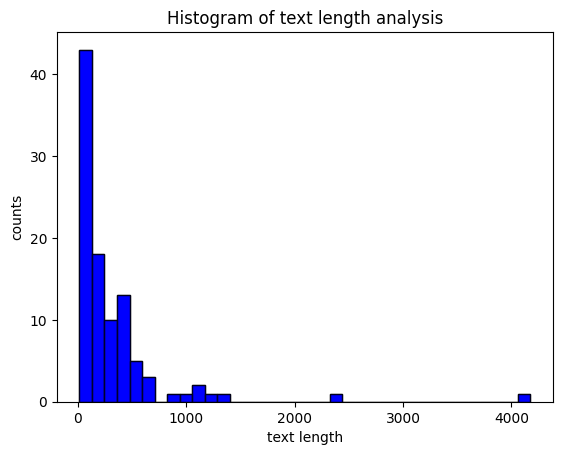

In [6]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns
# matplotlib histogram
plt.hist(text_lengths, color = 'blue', edgecolor = 'black',
         bins = int(180/5))
# seaborn histogram
sns.distplot(text_lengths, hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of text length analysis')
plt.xlabel('text length')
plt.ylabel('counts')

In [7]:
sum([1 for i in range(len(text_lengths)) if text_lengths[i] >= MAX_LENGTH])

6

In [8]:
# ========================= load tokenizer START =========================
# 30,522 vocab is BERT's default vocab size, feel free to tweak
# vocab_size = 30000
import transformers
# maximum sequence length, lowering will result to faster training (when increasing batch size)
# max_length = 512 # 768
# from transformers import RobertaTokenizerFast
print(tokenizer_path)
# tokenizer = RobertaTokenizerFast.from_pretrained(tokenizer_path, max_len=512)
tokenizer = transformers.AlbertTokenizer.from_pretrained(tokenizer_path)
print('tokenizer loaded ...')
# ========================= load tokenizer END =========================



albert-base-v2


loading file https://huggingface.co/albert-base-v2/resolve/main/spiece.model from cache at C:\Users\XinZhou/.cache\huggingface\transformers\10be6ce6d3508f1fdce98a57a574283b47c055228c1235f8686f039287ff8174.d6110e25022b713452eb83d5bfa8ae64530995a93d8e694fe52e05aa85dd3a7d
loading file https://huggingface.co/albert-base-v2/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/albert-base-v2/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/albert-base-v2/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at C:\Users\XinZhou/.cache\huggingface\transformers\e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_

tokenizer loaded ...


In [9]:
# text_ids = [tokenizer.encode(text, max_length=300, pad_to_max_length=True) for text in texts]
if not truncate_longer_samples:
    #tokenizer(examples["text"], return_special_tokens_mask=True)
    train_text_dict = [tokenizer(t, return_special_tokens_mask=True) for t in train_texts]
    valid_text_dict = [tokenizer(t, return_special_tokens_mask=True) for t in valid_texts]
    test_text_dict = [tokenizer(t, return_special_tokens_mask=True) for t in test_texts]
else:
    max_length = MAX_LENGTH
    train_text_dict = [tokenizer(t, truncation=True, padding='max_length', max_length=max_length, return_special_tokens_mask=True) for t in train_texts]
    valid_text_dict = [tokenizer(t, truncation=True, padding="max_length", max_length=max_length, return_special_tokens_mask=True) for t in valid_texts]
    test_text_dict = [tokenizer(t, truncation=True, padding="max_length", max_length=max_length, return_special_tokens_mask=True) for t in test_texts]

In [10]:
train_text_ids = [text_id['input_ids'] for text_id in train_text_dict]
valid_text_ids = [text_id['input_ids'] for text_id in valid_text_dict]
test_text_ids = [text_id['input_ids'] for text_id in test_text_dict]
# print(train_text_ids[10])

train_att_masks = [text_id['attention_mask'] for text_id in train_text_dict]
valid_att_masks = [text_id['attention_mask'] for text_id in valid_text_dict]
test_att_masks = [text_id['attention_mask'] for text_id in test_text_dict]
# att_masks[0]

In [11]:
from sklearn.model_selection import train_test_split
train_x, train_m, train_y = train_text_ids, train_att_masks, train_labels
val_x, val_m, val_y = valid_text_ids, valid_att_masks, valid_labels
test_x, test_m, test_y = test_text_ids, test_att_masks, test_labels

In [12]:
import torch

train_x = torch.tensor(train_x)
test_x = torch.tensor(test_x)
val_x = torch.tensor(val_x)
train_y = torch.tensor(train_y)
test_y = torch.tensor(test_y)
val_y = torch.tensor(val_y)
train_m = torch.tensor(train_m)
test_m = torch.tensor(test_m)
val_m = torch.tensor(val_m)

print(train_x.shape)
print(test_x.shape)
print(val_x.shape)
print(train_y.shape)
print(test_y.shape)
print(val_y.shape)
print(train_m.shape)
print(test_m.shape)
print(val_m.shape)

torch.Size([100, 1024])
torch.Size([100, 1024])
torch.Size([100, 1024])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100, 1024])
torch.Size([100, 1024])
torch.Size([100, 1024])


In [13]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

print(train_x)
train_data = TensorDataset(train_x, train_m, train_y)
train_sampler = list(range(len(train_data)))

# train_sampler = train_sampler[:100]
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_x, val_m, val_y)
val_sampler = list(range(len(val_data)))
# val_sampler = val_sampler[:100]
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)


tensor([[    2,  2593, 29992,  ...,     0,     0,     0],
        [    2, 12038, 11364,  ...,     0,     0,     0],
        [    2, 12038, 11364,  ...,    13,     7,     3],
        ...,
        [    2, 12038, 11364,  ...,     0,     0,     0],
        [    2, 12038,   287,  ...,     0,     0,     0],
        [    2, 12038, 11364,  ...,     0,     0,     0]])


In [14]:
import torch.nn as nn
import torch
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable
import sys
from transformers import RobertaForMaskedLM
import transformers

    
    
class BERTSourceBinaryClassification(nn.Module):
    def __init__(self,checkpoint, num_labels): 
        super(BERTSourceBinaryClassification,self).__init__() 
        self.num_labels = num_labels 
        print(num_labels)
        hidden_features = 768
        config = AutoConfig.from_pretrained(checkpoint, output_hidden_states=True, output_attentions=True)
        self.model = AutoModel.from_pretrained(checkpoint, config=config)
        #self.model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=hidden_features)
        print(self.model)
        print(self.model.config)
        #self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(hidden_features * 1 * MAX_LENGTH//512, num_labels) # load and initialize weights
        self.sigmoid = nn.Sigmoid()
    
    def forward_single(self, input_ids, attention_mask, labels, ex):
        #outputs = self.model.roberta(input_ids, attention_mask=attention_mask)[0]
        outputs  = self.model(input_ids, attention_mask=attention_mask)
        # 12 torch.Size([2, 12, 512, 512]) torch.Size([2, 12, 512, 512])
        # print(len(outputs[-1]), outputs[-1][0].shape, outputs[-1][-1].shape )
        # hidden_states, pool_output, unknown, attention_weights
        pooled_output = outputs[1]
        attention_weights = outputs[-1][0]
        #print(outputs[-1][0])
        return pooled_output, attention_weights
    
    
    def forward(self, input_ids=None, attention_mask=None, labels=None, ex=None, max_len=MAX_LENGTH, opt='mean'):
        #Extract outputs from the body
        final_logits = None
        final_attention_weights = None
        # pick the most suspicous one for final decision
        last_all = None
        attn_all = None
        attention_weights_all = None
        for i in range(0, max_len, 512):
            #last, attn, attention_weights = self.forward_single(input_ids[:,i:i+512], attention_mask[:,i:i+512], labels, ex)
            last, attention_weights = self.forward_single(input_ids[:,i:i+512], attention_mask[:,i:i+512], labels, ex)
            if last_all is None:
                last_all = last
                attention_weights_all = attention_weights
            else:
                last_all = torch.cat([last_all,  last_all], dim=1)
                attention_weights_all = torch.cat([attention_weights_all,  attention_weights], dim=1)
                
        #final_out = torch.cat([last_all,  attn_all], dim=1)
        #final_out = self.dropout(last_all)
        final_out = self.classifier(last_all)
        final_out = self.sigmoid(final_out)
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(final_out.view(-1, self.num_labels), labels.view(-1))
        return (loss, final_out), attention_weights_all



In [15]:
# from transformers import DistilBertForSequenceClassification, AdamW, DistilBertConfig
# num_labels = len(set(labels))
# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels,
#                                                             output_attentions=False, output_hidden_states=False)

# model_path = os.path.join(bert_dir, "checkpoint-60000")
print(bert_model_path)
model = BERTSourceBinaryClassification(checkpoint=bert_model_path, num_labels=2)

import torch.optim as optim

learning_rate = 1e-4
adam_epsilon = 1e-6

no_decay = ['bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0001},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)
# optimizer = optim.Adam(model.parameters, lr=learning_rate)

# os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
multi_gpu = torch.cuda.device_count() 
print(multi_gpu)
if multi_gpu > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)
# model = nn.DataParallel(model)

# optimizer = optim.Adam(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)
model = model.cuda()
# sys.exit(0)

from transformers import get_linear_schedule_with_warmup

total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


albert-base-v2
2


loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at C:\Users\XinZhou/.cache\huggingface\transformers\e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "output_attentions": true,
  "output_

AlbertModel(
  (embeddings): AlbertEmbeddings(
    (word_embeddings): Embedding(30000, 128, padding_idx=0)
    (position_embeddings): Embedding(512, 128)
    (token_type_embeddings): Embedding(2, 128)
    (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0, inplace=False)
  )
  (encoder): AlbertTransformer(
    (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
    (albert_layer_groups): ModuleList(
      (0): AlbertLayerGroup(
        (albert_layers): ModuleList(
          (0): AlbertLayer(
            (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (attention): AlbertAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (attention_dropout): Dropout(p=0, inplace=False)
      

C:\Users\XinZhou\anaconda3\envs\dna\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

import numpy as np
import random

seed_val = 111
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

import pickle
import os

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
# save model 

def save_model(model, train_losses, val_losses, out_dir_model):

    if not os.path.exists(out_dir_model):
        os.makedirs(out_dir_model)
    
    PATH = os.path.join(out_dir_model, 'BERTSourceBinaryClassification.pt')

    torch.save(model.state_dict(), PATH)

    with open(out_dir_model + '/train_losses.pkl', 'wb') as f:
        pickle.dump(train_losses, f)

    with open(out_dir_model + '/val_losses.pkl', 'wb') as f:
        pickle.dump(val_losses, f)
        
print('number of iterations: ', len(train_dataloader))

number of iterations:  50


In [17]:
if not test_only:
    from tqdm import tqdm
    train_losses = []
    val_losses = []
    num_mb_train = len(train_dataloader)
    num_mb_val = len(val_dataloader)
    current_step = 0
    saved_steps = []
    if num_mb_val == 0:
        num_mb_val = 1

    # print('number of iterations: ', len(train_dataloader), len(train_loader_extracted))
    print('num_epochs: ', num_epochs)

    loss_fct = nn.CrossEntropyLoss()


    for n in range(num_epochs):
        train_loss = 0
        val_loss = 0
        start_time = time.time()

        #for k, (data1, data2) in enumerate(zip(train_dataloader, train_loader_extracted)):
        for k, (mb_x, mb_m, mb_y) in tqdm(enumerate(train_dataloader)):
            #mb_x, mb_m, mb_y = data1
            # 56 features
            #ex, ey, e_index = data2
            optimizer.zero_grad()
            model.train()

            mb_x = mb_x.cuda()
            mb_m = mb_m.cuda()
            mb_y = mb_y.cuda()
            #ex = ex.cuda()

            outputs, _, = model(mb_x, attention_mask=mb_m, labels=mb_y)
            #print(outputs[1])
            #mb_y = F.one_hot(mb_y)
            #print(outputs, mb_y)
            #loss = loss_fct(outputs.view(-1, 2), mb_y.view(-1))
            loss = outputs[0]

            if multi_gpu > 1:
                loss = loss.sum()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            current_step += 1
            train_loss += loss.data / num_mb_train

            if current_step % save_step_at == 0:
                saved_steps.append(current_step)
                out_dir_model = './{}/classification_model_{}'.format(out_dir, saved_steps[-1])
                print('saved as: ', out_dir_model)
                if len(saved_steps) > max_step_saves:
                    delete_dir = './{}/classification_model_{}'.format(out_dir, saved_steps[-(max_step_saves+1)])
                    os.system('rm -r {}'.format(delete_dir))
                save_model(model, train_losses, val_losses, out_dir_model)


        print ("\nTrain loss after itaration %i: %f" % (n+1, train_loss))
        train_losses.append(train_loss.cpu())

        with torch.no_grad():
            model.eval()

            for k, (mb_x, mb_m, mb_y) in enumerate(val_dataloader):
                mb_x = mb_x.cuda()
                mb_m = mb_m.cuda()
                mb_y = mb_y.cuda()
 
                outputs, _ = model(mb_x, attention_mask=mb_m, labels=mb_y)
                loss = outputs[0]
                if multi_gpu > 1:
                    loss = loss.sum()
                #loss = model_loss(outputs[1], mb_y)

                val_loss += loss.data / num_mb_val

            print ("Validation loss after itaration %i: %f" % (n+1, val_loss))
            # save the best
            print('val_losses: ', val_losses, float(val_loss.cpu()))
            if val_losses and float(val_loss.cpu()) <= min(val_losses):
                out_dir_model = './{}/classification_model_best'.format(out_dir)
                print('the best model updated')
                print('saved as: ', out_dir_model)
                save_model(model, train_losses, val_losses, out_dir_model)
            val_losses.append(float(val_loss.cpu()))

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f'Time: {epoch_mins}m {epoch_secs}s')
        if len(val_losses) > 3 and float(val_loss.cpu()) > max(val_losses[-4:-1]):
            break

num_epochs:  3


2it [00:01,  1.24it/s]

tensor([[[[1.4883e-02, 2.7793e-03, 5.4520e-03,  ..., 1.9938e-03,
           4.5078e-03, 4.1221e-04],
          [2.0380e-02, 1.4348e-01, 7.0197e-02,  ..., 8.4680e-03,
           1.9936e-02, 3.1839e-05],
          [2.1791e-02, 1.0655e-01, 9.9225e-02,  ..., 4.5302e-03,
           7.7821e-03, 4.2674e-05],
          ...,
          [1.6984e-02, 1.7256e-02, 1.9837e-02,  ..., 5.9505e-02,
           6.0832e-02, 7.1662e-05],
          [1.8267e-02, 1.9648e-02, 2.3273e-02,  ..., 4.0868e-02,
           5.0332e-02, 5.0989e-05],
          [7.0433e-04, 6.7504e-04, 1.1253e-03,  ..., 3.0115e-04,
           4.6043e-04, 6.5895e-04]],

         [[8.7540e-01, 1.7591e-03, 2.0164e-03,  ..., 8.3014e-04,
           4.4550e-03, 2.5841e-07],
          [7.1772e-01, 3.2448e-02, 2.3048e-02,  ..., 1.0393e-03,
           5.1179e-03, 4.0766e-07],
          [6.8875e-01, 5.0505e-02, 4.2142e-02,  ..., 1.2238e-03,
           4.6997e-03, 3.7757e-07],
          ...,
          [8.4403e-02, 4.0840e-04, 8.4465e-04,  ..., 5.6818

4it [00:02,  2.86it/s]

tensor([[[[1.9026e-02, 3.6007e-03, 7.1608e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.8983e-02, 1.4042e-01, 6.8982e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.4105e-02, 1.2304e-01, 1.1608e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.5505e-02, 3.2042e-02, 4.5606e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.2862e-02, 3.3641e-02, 4.1024e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.4453e-03, 1.9630e-03, 3.0750e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[8.9715e-01, 2.4832e-03, 2.8305e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.5117e-01, 5.1211e-02, 3.7697e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.9943e-01, 7.8257e-02, 6.8125e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.7457e-01, 6.2305e-03, 2.0456e-02,  ..., 0.0000

6it [00:02,  4.76it/s]

tensor([[[[1.6821e-02, 3.3169e-03, 4.2205e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.5934e-02, 1.2886e-01, 4.0756e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.5313e-02, 4.2434e-02, 1.1032e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [4.1616e-02, 2.5838e-02, 2.3515e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.4056e-02, 3.0135e-02, 2.8659e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.5667e-04, 7.9623e-04, 7.7734e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[8.7429e-01, 2.6975e-03, 5.3263e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.1464e-01, 4.8065e-02, 9.0552e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.1151e-01, 6.5940e-02, 2.0770e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [4.4316e-01, 5.1299e-03, 1.6116e-02,  ..., 0.0000

8it [00:02,  6.46it/s]

tensor([[[[1.8708e-02, 3.6989e-03, 1.6653e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.9596e-02, 1.5992e-01, 9.8886e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.8287e-02, 9.1139e-02, 3.8438e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.6339e-02, 3.5866e-02, 3.5035e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.4641e-02, 3.8295e-02, 3.3307e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.4786e-03, 3.5421e-03, 2.9901e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[8.9124e-01, 2.9367e-03, 2.7476e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.6811e-01, 5.1757e-02, 1.3344e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.9863e-01, 7.7373e-02, 1.1254e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [6.0124e-01, 7.1547e-03, 2.7952e-02,  ..., 0.0000

9it [00:02,  7.16it/s]

tensor([[[[1.3494e-02, 2.6414e-03, 5.4380e-03,  ..., 2.1038e-03,
           1.6081e-03, 3.6305e-04],
          [1.9143e-02, 1.4073e-01, 7.0975e-02,  ..., 1.3964e-03,
           1.8805e-02, 3.5338e-05],
          [2.3417e-02, 1.2395e-01, 1.2040e-01,  ..., 2.3268e-03,
           8.3094e-03, 4.9795e-05],
          ...,
          [4.0587e-03, 4.1011e-03, 6.1844e-03,  ..., 5.0858e-03,
           1.6413e-02, 1.9910e-04],
          [1.8585e-02, 3.7561e-02, 4.0439e-02,  ..., 3.9690e-03,
           8.8841e-02, 1.9770e-05],
          [6.8633e-04, 6.8963e-04, 1.2457e-03,  ..., 3.4947e-04,
           2.4158e-04, 7.3930e-04]],

         [[8.4224e-01, 2.5950e-03, 2.7775e-03,  ..., 4.0596e-03,
           2.8619e-03, 3.0345e-07],
          [7.1133e-01, 4.9503e-02, 3.5734e-02,  ..., 1.4657e-03,
           4.6380e-03, 2.6061e-07],
          [6.4155e-01, 7.8715e-02, 6.8326e-02,  ..., 5.6156e-04,
           4.1419e-03, 2.5213e-07],
          ...,
          [8.3963e-02, 9.4897e-04, 1.4491e-03,  ..., 6.2928

12it [00:03,  8.23it/s]

tensor([[[[1.3060e-02, 2.4957e-03, 1.1894e-02,  ..., 2.0950e-03,
           2.0003e-03, 3.6414e-04],
          [1.6393e-02, 1.0379e-01, 7.2640e-03,  ..., 1.1658e-03,
           1.4973e-02, 3.0418e-05],
          [2.3673e-02, 6.4340e-02, 2.8605e-02,  ..., 2.9186e-03,
           1.5257e-02, 8.1162e-05],
          ...,
          [4.0757e-03, 3.9370e-03, 3.7685e-03,  ..., 5.3205e-03,
           1.6417e-02, 2.0979e-04],
          [3.2534e-02, 9.9214e-03, 7.3072e-03,  ..., 1.0842e-02,
           6.6878e-02, 6.3097e-05],
          [5.7039e-04, 5.5413e-04, 1.8153e-04,  ..., 2.9409e-04,
           4.5847e-04, 6.5608e-04]],

         [[8.3646e-01, 2.3529e-03, 1.9394e-03,  ..., 3.7061e-03,
           3.7172e-03, 2.6924e-07],
          [6.4287e-01, 4.0651e-02, 9.1818e-02,  ..., 1.3027e-03,
           3.8015e-03, 2.1651e-07],
          [6.9658e-01, 6.6829e-02, 8.6785e-02,  ..., 3.8580e-04,
           1.1536e-03, 5.3200e-08],
          ...,
          [1.1740e-01, 1.2843e-03, 2.3082e-03,  ..., 8.3326

14it [00:03,  8.63it/s]

tensor([[[[1.3658e-02, 2.6945e-03, 1.2917e-02,  ..., 7.1158e-03,
           3.0140e-03, 3.5887e-04],
          [1.8129e-02, 1.1089e-01, 7.9422e-03,  ..., 2.4668e-03,
           3.7083e-02, 3.1384e-05],
          [2.4202e-02, 6.4794e-02, 2.8997e-02,  ..., 8.8493e-03,
           2.7299e-02, 8.4986e-05],
          ...,
          [2.6454e-02, 5.1877e-03, 6.9475e-03,  ..., 2.5451e-02,
           1.6099e-02, 1.7078e-04],
          [3.6299e-02, 4.3964e-02, 6.9149e-03,  ..., 5.5860e-03,
           9.8951e-02, 4.6410e-05],
          [1.0666e-04, 1.7737e-04, 1.6000e-04,  ..., 2.8157e-04,
           2.3638e-04, 1.6502e-04]],

         [[8.4171e-01, 2.2043e-03, 1.7219e-03,  ..., 1.1304e-02,
           3.9020e-03, 9.7099e-07],
          [6.7193e-01, 4.2288e-02, 9.0122e-02,  ..., 3.0567e-03,
           2.2690e-03, 7.4246e-07],
          [7.0730e-01, 6.7939e-02, 8.4246e-02,  ..., 1.1376e-03,
           1.6953e-03, 2.3111e-07],
          ...,
          [1.5529e-01, 1.1662e-03, 1.1499e-03,  ..., 9.9613

16it [00:03,  8.83it/s]

tensor([[[[1.0763e-02, 5.0485e-03, 4.4871e-03,  ..., 1.5136e-03,
           2.3403e-03, 2.5742e-04],
          [3.1906e-02, 6.0407e-02, 3.7708e-02,  ..., 2.1376e-02,
           5.0887e-03, 1.6347e-04],
          [1.9675e-02, 3.9863e-02, 5.3519e-02,  ..., 1.2911e-02,
           2.1168e-03, 5.9084e-04],
          ...,
          [1.2809e-02, 1.1146e-02, 1.2522e-02,  ..., 1.7836e-01,
           1.2932e-02, 1.3945e-04],
          [4.6083e-03, 6.3247e-03, 4.8635e-03,  ..., 1.2086e-02,
           6.6958e-03, 3.7606e-05],
          [2.0608e-04, 1.0434e-04, 3.6265e-04,  ..., 4.3108e-04,
           1.6519e-04, 1.0488e-03]],

         [[8.4686e-01, 4.5628e-03, 2.1388e-03,  ..., 2.0350e-03,
           7.1038e-03, 3.9081e-07],
          [6.0243e-01, 2.4352e-01, 3.8975e-02,  ..., 6.5149e-04,
           1.3874e-03, 4.1801e-08],
          [3.5901e-01, 3.2591e-01, 1.1393e-01,  ..., 1.1948e-03,
           5.1356e-03, 4.6857e-07],
          ...,
          [1.2231e-01, 2.5885e-03, 2.1635e-03,  ..., 7.4421

18it [00:03,  9.05it/s]

tensor([[[[1.3482e-02, 5.8943e-03, 4.1637e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.5193e-02, 1.2898e-01, 6.9246e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.7341e-02, 8.7873e-02, 8.2136e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [4.5121e-02, 4.8917e-02, 3.2640e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.4370e-02, 4.5167e-02, 3.2473e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.1819e-03, 1.7156e-02, 5.2215e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[8.9968e-01, 3.4378e-03, 1.2725e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.5326e-01, 7.9048e-02, 4.5082e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.6462e-01, 7.2687e-02, 3.7006e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.7954e-01, 1.5339e-02, 7.4058e-03,  ..., 0.0000

19it [00:03,  8.83it/s]

tensor([[[[1.4971e-02, 2.4590e-03, 5.1178e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.6030e-02, 1.1928e-01, 2.0522e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.7516e-02, 5.0244e-02, 5.0009e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [4.5059e-02, 2.6311e-02, 2.4794e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.5318e-02, 2.8226e-02, 2.4528e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.9174e-04, 2.9351e-04, 2.7234e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.1411e-01, 1.5603e-03, 2.4698e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.6294e-01, 5.2929e-02, 8.1901e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.8117e-01, 1.0145e-01, 1.0752e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.4858e-01, 6.6250e-03, 1.8922e-02,  ..., 0.0000

22it [00:04,  8.39it/s]

tensor([[[[1.0087e-02, 2.2608e-03, 1.0560e-02,  ..., 1.1113e-03,
           2.4117e-03, 4.0536e-04],
          [1.6867e-02, 1.0125e-01, 7.5925e-03,  ..., 4.9323e-02,
           1.3393e-02, 3.5240e-05],
          [1.9790e-02, 5.5230e-02, 2.4576e-02,  ..., 2.2040e-02,
           8.9281e-03, 7.9427e-05],
          ...,
          [6.1965e-03, 2.8711e-02, 3.1923e-03,  ..., 1.8098e-01,
           2.7485e-02, 4.0936e-05],
          [3.4731e-02, 4.8391e-03, 7.3096e-03,  ..., 3.4142e-02,
           7.7734e-02, 1.6563e-04],
          [4.5916e-04, 4.6454e-04, 1.7324e-04,  ..., 4.0099e-04,
           3.6033e-04, 7.0822e-04]],

         [[8.4014e-01, 2.0952e-03, 1.4261e-03,  ..., 2.3319e-03,
           1.0605e-02, 2.2323e-07],
          [6.4932e-01, 4.2781e-02, 8.0285e-02,  ..., 1.7217e-03,
           5.0156e-03, 2.0537e-07],
          [6.7354e-01, 7.2300e-02, 8.1382e-02,  ..., 5.0854e-04,
           1.5710e-03, 5.9157e-08],
          ...,
          [1.4809e-01, 6.1309e-04, 1.8074e-03,  ..., 6.7589

24it [00:04,  8.53it/s]

tensor([[[[1.1865e-02, 2.7319e-03, 1.2651e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.0441e-02, 1.2185e-01, 9.1662e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.7767e-02, 7.7791e-02, 3.4601e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.9776e-02, 2.9450e-02, 2.8839e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.9935e-02, 3.1922e-02, 2.7199e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.1916e-04, 9.3221e-04, 9.0537e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.0527e-01, 2.2378e-03, 1.4924e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.1696e-01, 4.6956e-02, 8.6113e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.2814e-01, 7.8756e-02, 8.7158e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.9638e-01, 7.1541e-03, 2.1723e-02,  ..., 0.0000

26it [00:04,  8.78it/s]

tensor([[[[1.7715e-02, 4.1631e-03, 4.9024e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.4524e-02, 1.4555e-01, 4.9207e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.6743e-02, 4.4304e-02, 8.3852e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.3761e-02, 4.0315e-02, 2.3751e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.3664e-02, 4.3424e-02, 2.3150e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.2669e-02, 1.9274e-02, 5.2378e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.1193e-01, 2.2381e-03, 3.1551e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.2357e-01, 4.7101e-02, 8.5059e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.4973e-01, 5.4336e-02, 1.7060e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [6.0202e-01, 7.2347e-03, 2.3381e-02,  ..., 0.0000

28it [00:04,  8.93it/s]

tensor([[[[9.0446e-03, 2.1632e-03, 9.8724e-03,  ..., 3.6919e-03,
           4.1397e-03, 3.9957e-04],
          [1.8227e-02, 1.0834e-01, 8.1419e-03,  ..., 2.6439e-03,
           4.1782e-03, 3.7833e-05],
          [1.9818e-02, 5.5968e-02, 2.4821e-02,  ..., 4.5064e-03,
           7.5466e-03, 8.0972e-05],
          ...,
          [3.0137e-02, 1.4360e-02, 4.7281e-03,  ..., 1.6174e-02,
           1.8021e-02, 6.8247e-05],
          [2.8114e-02, 1.3402e-02, 1.6443e-02,  ..., 3.4402e-02,
           1.6404e-02, 8.3496e-05],
          [4.5822e-04, 4.6385e-04, 1.7800e-04,  ..., 2.5025e-04,
           7.3093e-05, 7.5317e-04]],

         [[8.5515e-01, 2.1003e-03, 1.3575e-03,  ..., 1.5816e-03,
           7.9440e-03, 2.1649e-07],
          [6.7021e-01, 4.3673e-02, 7.7409e-02,  ..., 8.5334e-04,
           2.8836e-03, 2.0270e-07],
          [6.8340e-01, 7.5064e-02, 8.0953e-02,  ..., 1.8708e-04,
           2.1759e-03, 6.1555e-08],
          ...,
          [1.1387e-01, 9.8450e-04, 1.5848e-03,  ..., 5.1862

29it [00:05,  8.47it/s]

tensor([[[[2.3415e-02, 5.6867e-03, 1.3079e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.6300e-02, 2.1609e-01, 3.5404e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.3105e-02, 6.0741e-02, 1.0734e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [7.2557e-02, 5.5665e-02, 4.9026e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.1445e-02, 5.9093e-02, 4.9251e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.3531e-02, 3.6553e-02, 1.8630e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.1081e-01, 2.2353e-03, 5.6359e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.7763e-01, 4.4160e-02, 1.6784e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.5824e-01, 5.0736e-02, 2.0301e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [6.3538e-01, 7.7202e-03, 6.1644e-02,  ..., 0.0000

32it [00:05,  8.87it/s]

tensor([[[[8.8976e-03, 4.3870e-03, 2.1596e-03,  ..., 3.7477e-03,
           4.4991e-03, 2.3587e-04],
          [2.5254e-02, 8.5896e-02, 4.2774e-02,  ..., 4.8845e-03,
           1.0797e-02, 5.2177e-04],
          [2.1968e-02, 4.2760e-02, 4.7038e-02,  ..., 4.1569e-03,
           1.2112e-02, 4.2943e-04],
          ...,
          [2.3509e-02, 1.9452e-02, 1.5621e-02,  ..., 1.2603e-02,
           2.4305e-02, 3.3057e-04],
          [2.4962e-02, 6.9551e-03, 1.2801e-02,  ..., 4.4710e-02,
           5.8399e-02, 2.0363e-04],
          [2.7585e-04, 4.3197e-04, 4.2832e-04,  ..., 5.2905e-04,
           3.8595e-04, 1.3883e-03]],

         [[8.4414e-01, 2.2353e-03, 2.8820e-03,  ..., 1.5093e-03,
           1.0551e-02, 1.0970e-06],
          [5.5779e-01, 1.5111e-01, 8.3082e-02,  ..., 9.5867e-04,
           4.5989e-03, 8.8194e-07],
          [4.3857e-01, 1.3918e-01, 1.7809e-01,  ..., 5.8605e-04,
           3.0788e-03, 6.8334e-07],
          ...,
          [1.0931e-01, 2.3518e-03, 1.4161e-03,  ..., 4.9356

33it [00:05,  8.70it/s]

tensor([[[[1.0606e-02, 2.6314e-03, 4.7189e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.8742e-02, 1.1092e-01, 4.9621e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.1976e-02, 3.5259e-02, 1.2038e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.6661e-02, 2.8477e-02, 2.9697e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.6979e-02, 3.0956e-02, 3.2971e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.7345e-03, 2.7335e-03, 3.0204e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.0237e-01, 2.2073e-03, 4.1289e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.7457e-01, 4.3860e-02, 7.9506e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.1489e-01, 7.0321e-02, 2.0939e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.5005e-01, 6.7095e-03, 1.8473e-02,  ..., 0.0000

36it [00:05,  9.06it/s]

tensor([[[[1.2217e-02, 3.0542e-03, 1.3701e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.4552e-02, 1.4534e-01, 1.0899e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.2005e-02, 9.1168e-02, 4.0347e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [4.2701e-02, 3.3349e-02, 3.2247e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.2381e-02, 3.5667e-02, 2.9836e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.2336e-03, 9.8817e-03, 9.6323e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[8.9368e-01, 2.1860e-03, 1.3662e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.2024e-01, 4.6834e-02, 8.0040e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.2223e-01, 8.0673e-02, 8.4619e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.7194e-01, 7.0005e-03, 2.0219e-02,  ..., 0.0000

37it [00:05,  9.07it/s]

tensor([[[[9.2059e-03, 2.3124e-03, 1.0340e-02,  ..., 3.2768e-03,
           2.9772e-03, 6.1951e-04],
          [1.6176e-02, 9.5794e-02, 7.1851e-03,  ..., 1.4797e-02,
           2.2892e-03, 7.3007e-05],
          [2.0090e-02, 5.7462e-02, 2.5390e-02,  ..., 2.2161e-02,
           4.5314e-03, 1.0424e-04],
          ...,
          [1.8120e-02, 8.1957e-03, 6.0465e-03,  ..., 5.8118e-02,
           1.4168e-02, 5.0444e-04],
          [5.0230e-03, 5.6381e-03, 5.2089e-03,  ..., 1.8010e-02,
           9.5919e-03, 3.8448e-05],
          [2.6776e-04, 1.1380e-04, 1.8996e-04,  ..., 1.1011e-03,
           1.7001e-04, 1.1478e-03]],

         [[8.5575e-01, 2.0906e-03, 1.2995e-03,  ..., 3.5466e-03,
           7.9282e-03, 3.7669e-07],
          [6.6552e-01, 4.3181e-02, 7.3437e-02,  ..., 2.0904e-03,
           5.8051e-03, 3.8163e-07],
          [6.8343e-01, 7.6374e-02, 7.9781e-02,  ..., 1.3040e-03,
           1.7495e-03, 1.3133e-07],
          ...,
          [3.8857e-02, 5.2948e-04, 1.2794e-03,  ..., 7.4327

39it [00:06,  8.73it/s]

tensor([[[[9.3938e-03, 2.3685e-03, 4.2897e-03,  ..., 3.8111e-03,
           4.7721e-03, 6.3624e-04],
          [1.7577e-02, 1.0434e-01, 4.6817e-02,  ..., 2.6339e-03,
           3.6243e-03, 1.5972e-04],
          [3.0766e-02, 2.5946e-02, 8.9294e-02,  ..., 6.4523e-03,
           5.3601e-03, 1.8922e-04],
          ...,
          [2.0297e-02, 9.1951e-03, 3.4168e-02,  ..., 1.4491e-02,
           3.7107e-02, 1.2791e-04],
          [3.2630e-02, 1.7161e-02, 1.6725e-02,  ..., 1.3628e-02,
           1.2966e-02, 2.5898e-04],
          [3.7372e-04, 6.1541e-04, 7.3181e-04,  ..., 4.3354e-05,
           8.2071e-04, 6.1413e-04]],

         [[8.5620e-01, 2.0884e-03, 3.9037e-03,  ..., 3.8060e-03,
           2.6594e-03, 2.1288e-06],
          [6.6155e-01, 4.2822e-02, 7.7551e-02,  ..., 9.7401e-04,
           2.1534e-03, 1.4110e-06],
          [5.2995e-01, 7.2498e-02, 2.1568e-01,  ..., 1.0590e-03,
           1.4322e-03, 6.5596e-07],
          ...,
          [8.8241e-02, 5.3556e-04, 2.7449e-03,  ..., 3.5123

42it [00:06,  8.10it/s]

tensor([[[[8.8004e-03, 2.2265e-03, 9.9082e-03,  ..., 2.5208e-03,
           4.4915e-03, 3.9999e-04],
          [1.9470e-02, 1.1605e-01, 8.7032e-03,  ..., 2.0061e-02,
           4.0341e-03, 3.2660e-05],
          [2.2008e-02, 6.3603e-02, 2.8014e-02,  ..., 9.5261e-03,
           6.2744e-03, 1.6649e-04],
          ...,
          [1.7819e-02, 2.3247e-02, 2.1139e-03,  ..., 7.6421e-02,
           1.3357e-02, 9.8970e-05],
          [3.3306e-02, 1.7656e-02, 4.9921e-03,  ..., 4.4751e-02,
           1.3287e-02, 8.4359e-05],
          [2.8524e-04, 2.8466e-04, 4.7193e-04,  ..., 3.4972e-04,
           2.8679e-04, 7.7455e-04]],

         [[8.4927e-01, 2.0695e-03, 1.2780e-03,  ..., 1.6313e-03,
           2.6260e-03, 1.9415e-06],
          [6.6685e-01, 4.3134e-02, 7.2979e-02,  ..., 9.6118e-04,
           2.1704e-03, 1.5633e-06],
          [6.7904e-01, 7.5940e-02, 7.8926e-02,  ..., 4.5422e-04,
           5.0559e-04, 8.7762e-07],
          ...,
          [1.2781e-01, 1.2021e-03, 1.9934e-03,  ..., 5.8865

44it [00:06,  8.25it/s]

tensor([[[[1.5606e-02, 3.0389e-03, 1.0839e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.8456e-02, 7.5575e-02, 1.0789e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [9.2583e-02, 3.0967e-02, 1.0130e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [4.5353e-02, 3.0000e-02, 3.0996e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.5174e-02, 3.2659e-02, 3.0454e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.3112e-02, 4.4661e-03, 1.7035e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[8.7683e-01, 8.8427e-03, 5.7080e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.6302e-01, 9.5420e-02, 2.9621e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.5634e-01, 2.1375e-01, 4.5600e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [4.8809e-01, 1.9435e-02, 4.0067e-02,  ..., 0.0000

46it [00:06,  8.50it/s]

tensor([[[[1.3156e-02, 3.3459e-03, 6.7978e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.4029e-02, 1.4407e-01, 8.1897e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.7997e-02, 1.4113e-01, 1.4749e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [4.2358e-02, 3.3760e-02, 5.2520e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.2034e-02, 3.6099e-02, 4.7387e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.1437e-02, 1.8465e-02, 3.2238e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.0796e-01, 2.2106e-03, 2.0877e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.3868e-01, 4.7772e-02, 3.3388e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.5709e-01, 8.3681e-02, 7.1812e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.6424e-01, 6.9852e-03, 2.0119e-02,  ..., 0.0000

48it [00:07,  8.66it/s]

tensor([[[[8.5384e-03, 2.1760e-03, 9.6418e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.3274e-02, 1.3987e-01, 1.0488e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.4942e-02, 7.2923e-02, 3.2024e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.8038e-02, 3.0397e-02, 2.9299e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.9587e-02, 3.4086e-02, 2.8352e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.7470e-04, 1.2534e-03, 1.2118e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.1022e-01, 2.2162e-03, 1.3607e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.2078e-01, 4.6633e-02, 7.8577e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.1547e-01, 8.0321e-02, 8.3149e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.8258e-01, 7.2252e-03, 2.0550e-02,  ..., 0.0000

50it [00:07,  6.70it/s]

tensor([[[[8.0840e-03, 9.0871e-03, 6.7394e-03,  ..., 1.8877e-03,
           3.0784e-03, 1.3982e-04],
          [2.0893e-02, 2.6797e-02, 3.3500e-02,  ..., 2.0066e-02,
           3.1426e-02, 1.5019e-04],
          [2.5145e-02, 4.3047e-02, 5.2656e-02,  ..., 8.5900e-03,
           1.8507e-02, 1.2841e-04],
          ...,
          [7.9379e-03, 3.1175e-03, 4.5024e-03,  ..., 1.1804e-01,
           3.5141e-02, 1.3784e-04],
          [4.7476e-02, 1.8865e-02, 1.6069e-02,  ..., 2.7166e-02,
           8.4865e-02, 8.2931e-05],
          [3.9647e-04, 2.5351e-04, 3.5875e-04,  ..., 8.4011e-04,
           1.1593e-04, 1.1822e-03]],

         [[8.3685e-01, 1.9540e-03, 4.1361e-03,  ..., 6.7994e-03,
           5.2848e-03, 6.5045e-07],
          [7.2085e-01, 7.8325e-02, 3.6431e-02,  ..., 4.6313e-03,
           1.2375e-02, 3.5722e-07],
          [5.1528e-01, 2.4560e-01, 8.3848e-02,  ..., 1.5222e-03,
           3.6819e-03, 5.5956e-07],
          ...,
          [1.0195e-01, 1.9839e-03, 2.6899e-03,  ..., 1.0126

tensor([[[[9.5451e-03, 2.4404e-03, 1.0793e-02,  ..., 1.7462e-03,
           3.1684e-03, 2.3547e-04],
          [1.7047e-02, 1.0281e-01, 7.7082e-03,  ..., 9.1160e-03,
           2.4873e-03, 4.5017e-04],
          [2.0874e-02, 6.1328e-02, 2.6897e-02,  ..., 1.8997e-02,
           4.8399e-03, 1.8742e-04],
          ...,
          [2.2969e-02, 2.4178e-02, 8.7252e-03,  ..., 2.0284e-01,
           5.3118e-03, 1.7975e-04],
          [5.3849e-03, 6.1963e-03, 5.7261e-03,  ..., 2.6639e-02,
           1.0605e-02, 6.6610e-05],
          [5.0101e-04, 4.8270e-04, 1.6646e-04,  ..., 1.1088e-04,
           3.7959e-04, 2.6935e-03]],

         [[8.5820e-01, 2.0889e-03, 1.2793e-03,  ..., 2.4902e-03,
           7.9374e-03, 8.3353e-07],
          [6.4706e-01, 4.1872e-02, 7.0420e-02,  ..., 1.0575e-03,
           5.7646e-03, 6.1782e-07],
          [6.7782e-01, 7.6214e-02, 7.8752e-02,  ..., 1.3333e-03,
           1.7697e-03, 4.1534e-07],
          ...,
          [6.9287e-02, 6.9270e-04, 1.5205e-03,  ..., 4.3352

tensor([[[[5.9396e-03, 4.0743e-03, 4.1062e-03,  ..., 2.1470e-03,
           2.3488e-03, 6.9634e-04],
          [6.4010e-03, 2.4110e-02, 2.3186e-02,  ..., 8.2030e-03,
           1.0626e-02, 2.9734e-04],
          [6.2141e-03, 2.3315e-02, 2.3088e-02,  ..., 8.0969e-03,
           1.0275e-02, 2.9637e-04],
          ...,
          [4.9497e-03, 1.1430e-02, 1.0960e-02,  ..., 2.4723e-02,
           2.5285e-02, 3.7834e-04],
          [5.3791e-03, 1.4089e-02, 1.3171e-02,  ..., 2.3139e-02,
           2.5990e-02, 2.8481e-04],
          [4.4604e-04, 3.9905e-04, 4.1252e-04,  ..., 4.4387e-04,
           3.9286e-04, 1.5060e-03]],

         [[9.3960e-02, 2.0221e-02, 1.4089e-02,  ..., 1.0079e-02,
           1.7111e-02, 5.9349e-05],
          [3.9459e-02, 2.3658e-01, 1.1609e-01,  ..., 6.2739e-03,
           1.8970e-02, 5.7043e-06],
          [2.9161e-02, 2.7052e-01, 1.6715e-01,  ..., 3.5514e-03,
           8.9983e-03, 4.3579e-06],
          ...,
          [3.5926e-03, 2.1494e-03, 2.7225e-03,  ..., 8.9542

tensor([[[[1.7647e-02, 5.5443e-03, 1.3152e-03,  ..., 8.2227e-04,
           1.0901e-03, 5.7019e-03],
          [3.0699e-02, 3.5799e-02, 9.5827e-03,  ..., 3.3690e-03,
           1.3966e-02, 5.0351e-04],
          [2.2339e-03, 1.3864e-02, 6.5451e-03,  ..., 2.6248e-03,
           7.3267e-03, 9.0592e-05],
          ...,
          [1.3144e-03, 4.8008e-03, 2.7715e-03,  ..., 7.3210e-03,
           1.5467e-02, 6.0245e-05],
          [1.2100e-02, 1.2980e-02, 6.7006e-03,  ..., 1.4074e-02,
           9.9702e-02, 1.4245e-04],
          [7.2525e-06, 2.4218e-05, 1.5599e-05,  ..., 1.5883e-05,
           6.5824e-06, 5.7000e-04]],

         [[2.5042e-01, 6.5110e-03, 2.5138e-02,  ..., 1.5509e-02,
           1.0632e-02, 5.6530e-04],
          [1.1009e-01, 1.5000e-01, 1.8396e-01,  ..., 7.4308e-03,
           1.2631e-02, 7.0282e-05],
          [4.7186e-02, 1.4018e-01, 3.3395e-01,  ..., 4.1868e-03,
           2.8658e-03, 2.7835e-05],
          ...,
          [5.6430e-03, 1.2099e-03, 6.7195e-03,  ..., 1.2851

tensor([[[[1.1466e-02, 2.9316e-03, 5.9545e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.0177e-02, 1.2169e-01, 6.9197e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.1174e-02, 1.0737e-01, 1.1224e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.8592e-02, 3.0959e-02, 4.8196e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.9221e-02, 3.3900e-02, 4.4530e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.7651e-03, 6.1116e-03, 1.0668e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.1315e-01, 2.2226e-03, 2.0976e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.7613e-01, 5.0223e-02, 3.5109e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.9521e-01, 8.8689e-02, 7.6138e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.6271e-01, 6.9953e-03, 2.0119e-02,  ..., 0.0000

tensor([[[[1.0597e-02, 5.4653e-03, 4.5729e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.8790e-02, 1.5131e-01, 1.5173e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.8411e-02, 8.1532e-02, 1.5024e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.9312e-02, 4.9888e-02, 3.5158e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.0276e-02, 4.7563e-02, 3.6034e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.4094e-03, 6.6896e-03, 4.2564e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.0707e-01, 3.0932e-03, 7.4165e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.8749e-01, 7.9006e-02, 3.0163e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.9205e-01, 1.0624e-01, 6.3895e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.8293e-01, 1.5501e-02, 9.4818e-03,  ..., 0.0000

tensor([[[[8.7872e-03, 2.2467e-03, 3.4538e-03,  ..., 2.5227e-03,
           1.2369e-03, 5.5240e-04],
          [1.3144e-02, 7.9272e-02, 2.8729e-02,  ..., 1.2897e-03,
           3.6083e-02, 6.3073e-05],
          [3.5361e-02, 2.3321e-02, 6.2120e-02,  ..., 3.2932e-03,
           1.6714e-02, 7.8592e-05],
          ...,
          [3.3837e-03, 3.5744e-03, 6.4084e-03,  ..., 6.9996e-03,
           1.1216e-02, 8.1528e-05],
          [3.5449e-03, 5.2333e-02, 1.7706e-02,  ..., 3.7987e-03,
           1.4888e-01, 4.7117e-05],
          [2.6981e-04, 1.9708e-04, 2.0466e-04,  ..., 1.6646e-04,
           2.5769e-04, 6.7855e-04]],

         [[8.4830e-01, 2.0648e-03, 1.0747e-03,  ..., 3.9050e-03,
           1.7604e-03, 1.5992e-06],
          [6.4442e-01, 4.1701e-02, 4.4612e-02,  ..., 2.0360e-03,
           3.0893e-03, 1.4617e-06],
          [5.9393e-01, 6.9290e-02, 8.0986e-02,  ..., 1.2919e-03,
           2.2345e-03, 7.3407e-07],
          ...,
          [1.0085e-01, 1.5528e-03, 1.4334e-03,  ..., 1.0330

tensor([[[[5.9396e-03, 4.0743e-03, 4.1062e-03,  ..., 2.1470e-03,
           2.3488e-03, 6.9634e-04],
          [6.4010e-03, 2.4110e-02, 2.3186e-02,  ..., 8.2030e-03,
           1.0626e-02, 2.9734e-04],
          [6.2141e-03, 2.3315e-02, 2.3088e-02,  ..., 8.0969e-03,
           1.0275e-02, 2.9637e-04],
          ...,
          [4.9497e-03, 1.1430e-02, 1.0960e-02,  ..., 2.4723e-02,
           2.5285e-02, 3.7834e-04],
          [5.3791e-03, 1.4089e-02, 1.3171e-02,  ..., 2.3139e-02,
           2.5990e-02, 2.8481e-04],
          [4.4604e-04, 3.9905e-04, 4.1252e-04,  ..., 4.4387e-04,
           3.9286e-04, 1.5060e-03]],

         [[9.3960e-02, 2.0221e-02, 1.4089e-02,  ..., 1.0079e-02,
           1.7111e-02, 5.9349e-05],
          [3.9459e-02, 2.3658e-01, 1.1609e-01,  ..., 6.2739e-03,
           1.8970e-02, 5.7043e-06],
          [2.9161e-02, 2.7052e-01, 1.6715e-01,  ..., 3.5514e-03,
           8.9983e-03, 4.3579e-06],
          ...,
          [3.5926e-03, 2.1494e-03, 2.7225e-03,  ..., 8.9542

tensor([[[[1.0975e-02, 2.8059e-03, 5.6992e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.0168e-02, 1.2164e-01, 6.9166e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.0831e-02, 1.0563e-01, 1.1042e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.7738e-02, 3.0273e-02, 4.7128e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.7910e-02, 3.2767e-02, 4.3042e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [9.7959e-04, 1.5901e-03, 2.7757e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.0089e-01, 2.1928e-03, 2.0694e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.5055e-01, 4.8569e-02, 3.3952e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.6871e-01, 8.5308e-02, 7.3235e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.6321e-01, 7.0016e-03, 2.0137e-02,  ..., 0.0000

tensor([[[[8.7593e-03, 2.2395e-03, 9.9046e-03,  ..., 3.5995e-03,
           4.5321e-03, 5.9376e-04],
          [1.7269e-02, 1.0415e-01, 7.8084e-03,  ..., 2.6183e-03,
           3.6280e-03, 4.2021e-05],
          [2.1816e-02, 6.4096e-02, 2.8110e-02,  ..., 6.5519e-03,
           6.3002e-03, 1.2369e-04],
          ...,
          [1.8524e-02, 8.6395e-03, 1.2205e-02,  ..., 1.3572e-02,
           3.4622e-02, 2.2115e-04],
          [3.4243e-02, 1.8577e-02, 5.2387e-03,  ..., 1.4693e-02,
           1.3827e-02, 8.0364e-05],
          [2.5363e-04, 3.0236e-04, 3.9925e-04,  ..., 8.5601e-05,
           8.2046e-04, 6.3970e-04]],

         [[8.5998e-01, 2.0932e-03, 1.2819e-03,  ..., 3.7685e-03,
           2.6304e-03, 1.8268e-06],
          [6.7748e-01, 4.3840e-02, 7.3731e-02,  ..., 1.0034e-03,
           2.2111e-03, 1.4892e-06],
          [6.9837e-01, 7.8525e-02, 8.1140e-02,  ..., 7.2993e-04,
           5.2172e-04, 5.0965e-07],
          ...,
          [7.7187e-02, 4.7805e-04, 1.7832e-03,  ..., 3.1290

tensor([[[[8.0062e-03, 2.0470e-03, 4.1577e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.1193e-02, 1.2782e-01, 7.2681e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.2495e-02, 1.1406e-01, 1.1924e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.1861e-02, 2.5559e-02, 3.9789e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.6127e-02, 3.1226e-02, 4.1018e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.6398e-04, 5.9083e-04, 1.0314e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.1232e-01, 2.2206e-03, 2.0957e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.6679e-01, 4.9620e-02, 3.4687e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.7128e-01, 8.5636e-02, 7.3517e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [4.7364e-01, 5.8880e-03, 1.6935e-02,  ..., 0.0000

tensor([[[[1.6310e-02, 5.5936e-03, 1.7657e-03,  ..., 2.9948e-03,
           3.0369e-03, 1.7474e-03],
          [8.5556e-03, 5.8770e-02, 2.1044e-02,  ..., 4.6312e-03,
           1.4317e-02, 8.1063e-05],
          [1.3773e-02, 1.4974e-02, 4.2675e-02,  ..., 6.1206e-03,
           7.9657e-03, 5.3659e-04],
          ...,
          [1.1351e-02, 8.2668e-03, 6.5591e-03,  ..., 1.3431e-02,
           2.0478e-02, 3.6732e-04],
          [8.8887e-03, 8.1837e-03, 1.5169e-02,  ..., 8.5469e-03,
           5.7735e-02, 8.9602e-05],
          [2.8891e-04, 1.2328e-04, 8.5879e-05,  ..., 2.0759e-04,
           2.8013e-04, 3.7438e-03]],

         [[2.1794e-01, 1.0834e-02, 8.1415e-03,  ..., 1.7762e-02,
           1.3185e-02, 7.7019e-04],
          [7.3761e-02, 5.2563e-01, 3.9052e-02,  ..., 2.3007e-03,
           1.2282e-02, 1.3055e-05],
          [4.2244e-02, 3.1940e-01, 9.8915e-02,  ..., 2.8684e-03,
           6.8431e-03, 5.0565e-05],
          ...,
          [6.3370e-03, 6.3980e-04, 5.8515e-04,  ..., 1.2603

tensor([[[[1.2339e-02, 3.1547e-03, 6.4078e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.9849e-02, 1.1971e-01, 6.8071e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.3001e-02, 1.1663e-01, 1.2192e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [4.0427e-02, 3.2430e-02, 5.0487e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.0592e-02, 3.5085e-02, 4.6087e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.4268e-03, 1.2055e-02, 2.1044e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.0474e-01, 2.2022e-03, 2.0782e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.6637e-01, 4.9592e-02, 3.4668e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.5517e-01, 8.3580e-02, 7.1752e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.9458e-01, 7.3916e-03, 2.1259e-02,  ..., 0.0000

tensor([[[[8.1821e-03, 9.2019e-03, 6.8296e-03,  ..., 2.3489e-03,
           2.2914e-03, 3.4201e-04],
          [2.3353e-02, 2.9994e-02, 3.7484e-02,  ..., 4.0900e-03,
           2.2824e-02, 3.0325e-04],
          [2.8184e-02, 4.8320e-02, 5.9101e-02,  ..., 2.3733e-03,
           8.7250e-03, 7.2814e-05],
          ...,
          [3.2635e-03, 3.7047e-03, 2.8867e-03,  ..., 6.7511e-03,
           1.7202e-02, 6.8801e-05],
          [1.2219e-02, 5.9411e-03, 9.3346e-03,  ..., 6.6510e-03,
           5.8074e-02, 3.0094e-04],
          [2.1675e-04, 1.4828e-04, 1.4003e-04,  ..., 9.2333e-05,
           1.0771e-03, 2.9068e-03]],

         [[8.3463e-01, 1.9458e-03, 4.1201e-03,  ..., 3.8421e-03,
           1.7541e-02, 3.7383e-07],
          [7.2904e-01, 7.9181e-02, 3.6837e-02,  ..., 8.4152e-04,
           9.8481e-03, 4.6695e-07],
          [5.2483e-01, 2.5004e-01, 8.5387e-02,  ..., 5.1952e-04,
           2.7157e-03, 4.6170e-07],
          ...,
          [1.2152e-01, 1.8371e-03, 1.7210e-03,  ..., 1.2447

tensor([[[[1.6575e-02, 2.3152e-03, 3.5449e-03,  ..., 3.2718e-03,
           3.5136e-03, 1.0274e-02],
          [2.2434e-03, 7.8015e-03, 1.3059e-02,  ..., 6.0497e-03,
           8.4791e-03, 1.1117e-04],
          [9.3498e-03, 1.3332e-02, 4.7608e-02,  ..., 9.8607e-03,
           1.5739e-02, 5.7614e-04],
          ...,
          [6.2764e-03, 4.2002e-03, 9.0354e-03,  ..., 2.2145e-02,
           1.2213e-02, 3.0918e-04],
          [1.0640e-02, 2.1755e-03, 2.6171e-02,  ..., 1.9013e-02,
           6.6685e-02, 6.0784e-05],
          [1.4326e-04, 4.8413e-05, 6.0091e-05,  ..., 1.9697e-04,
           5.8553e-05, 1.7447e-03]],

         [[1.2764e-01, 2.1426e-02, 2.1181e-02,  ..., 3.2880e-02,
           8.2175e-03, 8.3531e-04],
          [2.9270e-02, 3.4650e-01, 7.3420e-02,  ..., 5.9436e-03,
           1.0517e-02, 3.0485e-05],
          [2.5298e-02, 3.0904e-01, 1.5333e-01,  ..., 3.3628e-03,
           4.1096e-03, 6.8692e-05],
          ...,
          [6.5809e-03, 2.1084e-03, 4.2988e-03,  ..., 1.2601

tensor([[[[1.1685e-02, 2.9875e-03, 6.1681e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.4241e-02, 1.4621e-01, 6.7053e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.1903e-02, 1.0195e-01, 2.3383e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [4.1170e-02, 3.3026e-02, 3.8870e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.0989e-02, 3.5428e-02, 3.6429e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.2415e-03, 1.1755e-02, 9.2544e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.0881e-01, 2.2121e-03, 2.1239e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.5253e-01, 4.8697e-02, 4.5450e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.0370e-01, 8.2854e-02, 1.1135e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.9892e-01, 7.4455e-03, 1.7064e-02,  ..., 0.0000

tensor([[[[7.9502e-03, 2.0326e-03, 4.1286e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.7613e-02, 1.0623e-01, 6.0404e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.6909e-02, 8.5741e-02, 8.9632e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [2.8616e-02, 2.2956e-02, 3.5737e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.2084e-02, 2.7731e-02, 3.6427e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.2132e-04, 5.2158e-04, 9.1046e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.0249e-01, 2.1967e-03, 2.0731e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.6731e-01, 4.9653e-02, 3.4710e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.8079e-01, 8.6848e-02, 7.4558e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [4.9875e-01, 6.2002e-03, 1.7833e-02,  ..., 0.0000

1it [00:00,  8.74it/s]

tensor([[[[8.4611e-03, 2.1633e-03, 4.3940e-03,  ..., 2.4291e-03,
           1.4770e-03, 4.0941e-04],
          [1.8527e-02, 1.1174e-01, 6.3538e-02,  ..., 1.8179e-03,
           1.7888e-02, 3.9664e-05],
          [2.1083e-02, 1.0690e-01, 1.1176e-01,  ..., 2.8958e-03,
           7.8599e-03, 5.2045e-05],
          ...,
          [3.3210e-03, 3.5082e-03, 6.1387e-03,  ..., 6.8700e-03,
           1.5706e-02, 1.7987e-04],
          [1.5001e-02, 3.1974e-02, 3.6486e-02,  ..., 4.5760e-03,
           9.4102e-02, 1.9027e-05],
          [3.9860e-04, 4.2475e-04, 8.5421e-04,  ..., 2.7111e-04,
           1.7516e-04, 7.2087e-04]],

         [[8.6592e-01, 2.1077e-03, 1.9891e-03,  ..., 3.9861e-03,
           2.1737e-03, 2.1301e-07],
          [7.1063e-01, 4.5985e-02, 3.2147e-02,  ..., 2.2452e-03,
           4.8312e-03, 2.1098e-07],
          [6.2966e-01, 8.0327e-02, 6.8959e-02,  ..., 8.1562e-04,
           4.1260e-03, 2.1540e-07],
          ...,
          [7.3169e-02, 1.1266e-03, 1.5946e-03,  ..., 7.4947

tensor([[[[5.9346e-03, 4.0748e-03, 4.1028e-03,  ..., 2.1452e-03,
           2.3491e-03, 6.9576e-04],
          [6.4015e-03, 2.4088e-02, 2.3188e-02,  ..., 8.2036e-03,
           1.0627e-02, 2.9736e-04],
          [6.2145e-03, 2.3316e-02, 2.3090e-02,  ..., 8.0973e-03,
           1.0276e-02, 2.9639e-04],
          ...,
          [4.9460e-03, 1.1433e-02, 1.0963e-02,  ..., 2.4704e-02,
           2.5266e-02, 3.7843e-04],
          [5.3746e-03, 1.4091e-02, 1.3173e-02,  ..., 2.3142e-02,
           2.5994e-02, 2.8484e-04],
          [4.4562e-04, 3.9906e-04, 4.1253e-04,  ..., 4.4388e-04,
           3.9287e-04, 1.5060e-03]],

         [[9.3981e-02, 2.0206e-02, 1.4092e-02,  ..., 1.0081e-02,
           1.7115e-02, 5.9362e-05],
          [3.9475e-02, 2.3667e-01, 1.1602e-01,  ..., 6.2764e-03,
           1.8977e-02, 5.7066e-06],
          [2.9172e-02, 2.7037e-01, 1.6722e-01,  ..., 3.5529e-03,
           9.0020e-03, 4.3596e-06],
          ...,
          [3.5940e-03, 2.1482e-03, 2.7235e-03,  ..., 8.9489

2it [00:00,  8.21it/s]

tensor([[[[9.2175e-03, 2.3594e-03, 4.3092e-03,  ..., 3.7918e-03,
           4.7771e-03, 6.3309e-04],
          [1.7247e-02, 1.0416e-01, 4.6804e-02,  ..., 2.6178e-03,
           3.6296e-03, 1.6039e-04],
          [3.0201e-02, 2.5890e-02, 8.9602e-02,  ..., 6.4127e-03,
           5.3715e-03, 1.8895e-04],
          ...,
          [1.9629e-02, 9.1775e-03, 3.3907e-02,  ..., 1.4412e-02,
           3.6761e-02, 1.2883e-04],
          [3.1536e-02, 1.7153e-02, 1.6610e-02,  ..., 1.3562e-02,
           1.2755e-02, 2.5899e-04],
          [3.6311e-04, 6.1245e-04, 7.2266e-04,  ..., 4.2995e-05,
           8.0003e-04, 6.1333e-04]],

         [[8.5679e-01, 2.0851e-03, 3.9038e-03,  ..., 3.7505e-03,
           2.6177e-03, 2.1288e-06],
          [6.6124e-01, 4.2795e-02, 7.7796e-02,  ..., 9.7990e-04,
           2.1590e-03, 1.4142e-06],
          [5.2879e-01, 7.2639e-02, 2.1692e-01,  ..., 1.0597e-03,
           1.4302e-03, 6.5583e-07],
          ...,
          [8.6804e-02, 5.3846e-04, 2.7502e-03,  ..., 3.5239

4it [00:00,  9.04it/s]

tensor([[[[5.9298e-03, 4.0715e-03, 4.1034e-03,  ..., 2.1455e-03,
           2.3472e-03, 6.9587e-04],
          [6.3964e-03, 2.4092e-02, 2.3192e-02,  ..., 8.2051e-03,
           1.0629e-02, 2.9741e-04],
          [6.2089e-03, 2.3295e-02, 2.3091e-02,  ..., 8.0900e-03,
           1.0277e-02, 2.9612e-04],
          ...,
          [4.9429e-03, 1.1425e-02, 1.0966e-02,  ..., 2.4713e-02,
           2.5274e-02, 3.7819e-04],
          [5.3712e-03, 1.4082e-02, 1.3165e-02,  ..., 2.3127e-02,
           2.6003e-02, 2.8494e-04],
          [4.4521e-04, 3.9870e-04, 4.1216e-04,  ..., 4.4391e-04,
           3.9290e-04, 1.5047e-03]],

         [[9.3946e-02, 2.0199e-02, 1.4087e-02,  ..., 1.0077e-02,
           1.7109e-02, 5.9398e-05],
          [3.9458e-02, 2.3657e-01, 1.1609e-01,  ..., 6.2738e-03,
           1.8988e-02, 5.7098e-06],
          [2.9167e-02, 2.7032e-01, 1.6719e-01,  ..., 3.5523e-03,
           9.0092e-03, 4.3631e-06],
          ...,
          [3.5933e-03, 2.1498e-03, 2.7230e-03,  ..., 8.9470

5it [00:00,  8.85it/s]

tensor([[[[9.8240e-03, 2.5172e-03, 1.1118e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.1525e-02, 1.3018e-01, 9.7585e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.2152e-02, 6.5320e-02, 2.8618e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.3338e-02, 2.6816e-02, 2.5818e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.5340e-02, 3.0627e-02, 2.5431e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.0510e-04, 6.5902e-04, 6.3555e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.0522e-01, 2.2025e-03, 1.3465e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.1939e-01, 4.6557e-02, 7.8197e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.0748e-01, 7.9620e-02, 8.2170e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.5155e-01, 6.8669e-03, 1.9459e-02,  ..., 0.0000

6it [00:00,  8.95it/s]

tensor([[[[5.9248e-03, 4.0720e-03, 4.1000e-03,  ..., 2.1437e-03,
           2.3475e-03, 6.9528e-04],
          [6.3907e-03, 2.4095e-02, 2.3172e-02,  ..., 8.2058e-03,
           1.0629e-02, 2.9715e-04],
          [6.2034e-03, 2.3297e-02, 2.3093e-02,  ..., 8.0907e-03,
           1.0278e-02, 2.9615e-04],
          ...,
          [4.9396e-03, 1.1429e-02, 1.0970e-02,  ..., 2.4721e-02,
           2.5282e-02, 3.7831e-04],
          [5.3677e-03, 1.4087e-02, 1.3169e-02,  ..., 2.3135e-02,
           2.5986e-02, 2.8475e-04],
          [4.4525e-04, 3.9873e-04, 4.1219e-04,  ..., 4.4394e-04,
           3.9254e-04, 1.5048e-03]],

         [[9.3974e-02, 2.0185e-02, 1.4078e-02,  ..., 1.0071e-02,
           1.7114e-02, 5.9416e-05],
          [3.9485e-02, 2.3650e-01, 1.1605e-01,  ..., 6.2780e-03,
           1.8982e-02, 5.7137e-06],
          [2.9172e-02, 2.7036e-01, 1.6722e-01,  ..., 3.5528e-03,
           9.0017e-03, 4.3637e-06],
          ...,
          [3.5920e-03, 2.1491e-03, 2.7246e-03,  ..., 8.9525

7it [00:00,  8.94it/s]

tensor([[[[8.8926e-03, 2.2804e-03, 1.0067e-02,  ..., 4.7474e-04,
           4.3801e-03, 2.7190e-04],
          [1.8537e-02, 1.1224e-01, 8.4122e-03,  ..., 9.0283e-03,
           5.8751e-03, 9.8645e-05],
          [2.1649e-02, 6.3934e-02, 2.7997e-02,  ..., 9.6122e-03,
           6.0464e-03, 1.2159e-04],
          ...,
          [1.2841e-02, 1.6451e-02, 4.1192e-03,  ..., 9.3782e-02,
           1.5145e-02, 2.0432e-04],
          [1.9068e-02, 7.5561e-03, 3.7151e-03,  ..., 3.0500e-02,
           1.6302e-02, 1.8870e-04],
          [6.0818e-04, 4.0379e-04, 2.0390e-04,  ..., 5.0296e-04,
           3.5961e-04, 2.0131e-03]],

         [[8.6184e-01, 2.0966e-03, 1.2809e-03,  ..., 2.2936e-03,
           1.0385e-02, 8.2112e-07],
          [6.7013e-01, 4.3367e-02, 7.2802e-02,  ..., 2.1927e-03,
           8.8741e-03, 5.3051e-07],
          [6.8251e-01, 7.6835e-02, 7.9255e-02,  ..., 8.3245e-04,
           2.8205e-03, 2.7775e-07],
          ...,
          [7.7240e-02, 4.8194e-04, 1.1782e-03,  ..., 7.5650

8it [00:00,  9.11it/s]

tensor([[[[5.9256e-03, 4.0686e-03, 4.1005e-03,  ..., 2.1440e-03,
           2.3455e-03, 6.9537e-04],
          [6.3850e-03, 2.4073e-02, 2.3173e-02,  ..., 8.2065e-03,
           1.0630e-02, 2.9717e-04],
          [6.1976e-03, 2.3298e-02, 2.3072e-02,  ..., 8.0911e-03,
           1.0278e-02, 2.9587e-04],
          ...,
          [4.9366e-03, 1.1422e-02, 1.0963e-02,  ..., 2.4706e-02,
           2.5267e-02, 3.7808e-04],
          [5.3636e-03, 1.4090e-02, 1.3172e-02,  ..., 2.3117e-02,
           2.5991e-02, 2.8482e-04],
          [4.4488e-04, 3.9840e-04, 4.1185e-04,  ..., 4.4358e-04,
           3.9261e-04, 1.5050e-03]],

         [[9.3996e-02, 2.0190e-02, 1.4081e-02,  ..., 1.0073e-02,
           1.7101e-02, 5.9430e-05],
          [3.9465e-02, 2.3661e-01, 1.1599e-01,  ..., 6.2809e-03,
           1.8991e-02, 5.7163e-06],
          [2.9163e-02, 2.7028e-01, 1.6717e-01,  ..., 3.5518e-03,
           9.0079e-03, 4.3668e-06],
          ...,
          [3.5943e-03, 2.1504e-03, 2.7237e-03,  ..., 8.9495

9it [00:01,  8.88it/s]

tensor([[[[8.8573e-03, 2.2728e-03, 4.6154e-03,  ..., 5.1542e-03,
           2.1203e-03, 4.1438e-04],
          [1.3206e-02, 8.0020e-02, 4.5516e-02,  ..., 1.5627e-03,
           2.8962e-02, 3.0666e-05],
          [1.5631e-02, 7.9618e-02, 8.3253e-02,  ..., 2.7272e-03,
           1.7591e-02, 7.3811e-05],
          ...,
          [6.2702e-03, 9.9242e-03, 1.8366e-02,  ..., 4.0185e-02,
           1.0765e-01, 2.7313e-05],
          [8.8427e-03, 1.2161e-02, 7.2139e-03,  ..., 1.2804e-02,
           1.0828e-01, 3.7942e-05],
          [3.0007e-04, 2.9860e-04, 4.5139e-04,  ..., 8.6412e-04,
           3.0944e-04, 2.3333e-04]],

         [[8.5275e-01, 2.0744e-03, 1.9574e-03,  ..., 7.8008e-03,
           5.5329e-03, 4.8934e-07],
          [6.7688e-01, 4.3806e-02, 3.0643e-02,  ..., 4.5177e-03,
           1.0806e-02, 2.4815e-07],
          [5.9233e-01, 7.5633e-02, 6.4975e-02,  ..., 2.7732e-03,
           5.0788e-03, 3.8244e-07],
          ...,
          [8.9815e-02, 3.6059e-04, 9.4419e-04,  ..., 1.9432

tensor([[[[5.9206e-03, 4.0692e-03, 4.1011e-03,  ..., 2.1422e-03,
           2.3459e-03, 6.9480e-04],
          [6.3850e-03, 2.4073e-02, 2.3174e-02,  ..., 8.2065e-03,
           1.0630e-02, 2.9718e-04],
          [6.1977e-03, 2.3299e-02, 2.3072e-02,  ..., 8.0912e-03,
           1.0278e-02, 2.9587e-04],
          ...,
          [4.9324e-03, 1.1423e-02, 1.0964e-02,  ..., 2.4708e-02,
           2.5270e-02, 3.7812e-04],
          [5.3642e-03, 1.4091e-02, 1.3173e-02,  ..., 2.3120e-02,
           2.5994e-02, 2.8485e-04],
          [4.4451e-04, 3.9845e-04, 4.1190e-04,  ..., 4.4364e-04,
           3.9266e-04, 1.5052e-03]],

         [[9.3926e-02, 2.0194e-02, 1.4084e-02,  ..., 1.0075e-02,
           1.7105e-02, 5.9444e-05],
          [3.9480e-02, 2.3647e-01, 1.1604e-01,  ..., 6.2772e-03,
           1.8998e-02, 5.7184e-06],
          [2.9164e-02, 2.7029e-01, 1.6717e-01,  ..., 3.5519e-03,
           9.0082e-03, 4.3669e-06],
          ...,
          [3.5946e-03, 2.1506e-03, 2.7240e-03,  ..., 8.9504

10it [00:01,  7.59it/s]

tensor([[[[1.0359e-02, 2.6597e-03, 5.4014e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.9427e-02, 1.1778e-01, 6.7005e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.0945e-02, 1.0674e-01, 1.1164e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.7472e-02, 3.0211e-02, 4.7061e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.8577e-02, 3.3511e-02, 4.4047e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.6237e-04, 9.1660e-04, 1.6000e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.1473e-01, 2.2250e-03, 2.1000e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.7301e-01, 5.0033e-02, 3.5013e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.9234e-01, 8.8428e-02, 7.5994e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.7535e-01, 7.1727e-03, 2.0619e-02,  ..., 0.0000

12it [00:01,  8.36it/s]

tensor([[[[8.4116e-03, 2.1602e-03, 4.3870e-03,  ..., 1.9071e-03,
           2.0663e-03, 4.0971e-04],
          [1.7094e-02, 1.0367e-01, 5.8981e-02,  ..., 1.1613e-02,
           8.0625e-03, 3.6840e-05],
          [1.7801e-02, 9.0747e-02, 9.4915e-02,  ..., 7.6563e-03,
           6.3495e-03, 4.4156e-05],
          ...,
          [8.6854e-03, 1.1554e-02, 1.4936e-02,  ..., 5.4917e-02,
           2.0760e-02, 1.2071e-04],
          [1.3477e-02, 2.7227e-02, 2.1681e-02,  ..., 3.2295e-02,
           6.0299e-02, 3.0325e-05],
          [3.8939e-04, 4.1833e-04, 8.4047e-04,  ..., 5.3578e-04,
           1.3198e-04, 7.0986e-04]],

         [[8.5878e-01, 2.0888e-03, 1.9716e-03,  ..., 3.5009e-03,
           2.8858e-03, 2.1120e-07],
          [6.7817e-01, 4.3897e-02, 3.0724e-02,  ..., 1.5897e-03,
           1.1034e-02, 2.0171e-07],
          [6.0197e-01, 7.6897e-02, 6.6093e-02,  ..., 1.3283e-03,
           5.7852e-03, 2.0588e-07],
          ...,
          [1.1490e-01, 6.6673e-04, 9.6211e-04,  ..., 6.0993

13it [00:01,  8.53it/s]

tensor([[[[1.0654e-02, 2.7368e-03, 1.2070e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.3693e-02, 1.4373e-01, 1.0769e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.4463e-02, 7.2423e-02, 3.1690e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.6656e-02, 2.9567e-02, 2.8453e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.7361e-02, 3.2471e-02, 2.6941e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.4571e-03, 2.3761e-03, 2.2887e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[8.9939e-01, 2.1876e-03, 1.3348e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.2782e-01, 4.7115e-02, 7.9019e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.1334e-01, 8.0369e-02, 8.2830e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.9639e-01, 7.4371e-03, 2.1042e-02,  ..., 0.0000

tensor([[[[5.9162e-03, 4.0661e-03, 4.0980e-03,  ..., 2.1427e-03,
           2.3441e-03, 6.9495e-04],
          [6.3798e-03, 2.4077e-02, 2.3177e-02,  ..., 8.2079e-03,
           1.0622e-02, 2.9693e-04],
          [6.1916e-03, 2.3299e-02, 2.3072e-02,  ..., 8.0912e-03,
           1.0278e-02, 2.9587e-04],
          ...,
          [4.9286e-03, 1.1426e-02, 1.0967e-02,  ..., 2.4714e-02,
           2.5275e-02, 3.7820e-04],
          [5.3604e-03, 1.4082e-02, 1.3177e-02,  ..., 2.3126e-02,
           2.5976e-02, 2.8465e-04],
          [4.4460e-04, 3.9854e-04, 4.1200e-04,  ..., 4.4374e-04,
           3.9236e-04, 1.5041e-03]],

         [[9.3954e-02, 2.0181e-02, 1.4075e-02,  ..., 1.0068e-02,
           1.7094e-02, 5.9461e-05],
          [3.9490e-02, 2.3653e-01, 1.1607e-01,  ..., 6.2789e-03,
           1.9003e-02, 5.7200e-06],
          [2.9169e-02, 2.7034e-01, 1.6720e-01,  ..., 3.5525e-03,
           9.0098e-03, 4.3677e-06],
          ...,
          [3.5932e-03, 2.1498e-03, 2.7256e-03,  ..., 8.9469

15it [00:01,  8.77it/s]

tensor([[[[8.0254e-03, 9.0402e-03, 6.7252e-03,  ..., 1.8889e-03,
           3.0680e-03, 1.4043e-04],
          [2.0686e-02, 2.6701e-02, 3.3327e-02,  ..., 2.0107e-02,
           3.1461e-02, 1.5069e-04],
          [2.4886e-02, 4.2898e-02, 5.2440e-02,  ..., 8.6563e-03,
           1.8568e-02, 1.2929e-04],
          ...,
          [7.8466e-03, 3.1127e-03, 4.4952e-03,  ..., 1.1798e-01,
           3.5068e-02, 1.3846e-04],
          [4.6895e-02, 1.8811e-02, 1.6007e-02,  ..., 2.7123e-02,
           8.4680e-02, 8.3326e-05],
          [3.9071e-04, 2.5179e-04, 3.5614e-04,  ..., 8.3852e-04,
           1.1568e-04, 1.1843e-03]],

         [[8.3702e-01, 1.9408e-03, 4.1117e-03,  ..., 6.7756e-03,
           5.2722e-03, 6.5526e-07],
          [7.2052e-01, 7.8117e-02, 3.6356e-02,  ..., 4.6437e-03,
           1.2452e-02, 3.6250e-07],
          [5.1530e-01, 2.4506e-01, 8.3712e-02,  ..., 1.5274e-03,
           3.7060e-03, 5.6733e-07],
          ...,
          [1.0196e-01, 1.9835e-03, 2.6917e-03,  ..., 1.0129

16it [00:01,  8.92it/s]

tensor([[[[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000

17it [00:01,  8.97it/s]

tensor([[[[9.0179e-03, 2.3182e-03, 4.7082e-03,  ..., 2.6067e-03,
           4.0753e-03, 3.6962e-04],
          [1.6280e-02, 9.8814e-02, 5.6240e-02,  ..., 1.6111e-03,
           2.4639e-02, 1.3974e-04],
          [1.7797e-02, 9.0804e-02, 9.5010e-02,  ..., 2.4633e-03,
           1.5372e-02, 2.1606e-04],
          ...,
          [3.6209e-03, 3.8547e-03, 6.7481e-03,  ..., 7.5581e-03,
           1.6048e-02, 4.6565e-05],
          [1.9976e-02, 2.2259e-02, 1.7815e-02,  ..., 1.3772e-02,
           9.5731e-02, 2.5443e-04],
          [1.8901e-04, 2.3465e-04, 2.5665e-04,  ..., 1.7932e-04,
           4.4441e-04, 6.7151e-04]],

         [[8.5293e-01, 2.0748e-03, 1.9586e-03,  ..., 3.9254e-03,
           4.1859e-03, 3.0672e-07],
          [6.9026e-01, 4.4702e-02, 3.1300e-02,  ..., 2.1937e-03,
           3.7650e-03, 4.6776e-07],
          [6.3338e-01, 8.0970e-02, 6.9619e-02,  ..., 8.2463e-04,
           4.9321e-03, 6.6914e-07],
          ...,
          [1.0923e-01, 1.6930e-03, 2.3963e-03,  ..., 1.1219

18it [00:02,  9.07it/s]

tensor([[[[5.7754e-02, 5.7993e-02, 5.3081e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.0414e-02, 4.6730e-02, 2.1152e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.5341e-03, 4.1192e-02, 4.5480e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [2.8659e-02, 5.1298e-02, 1.5701e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.7134e-02, 4.9147e-02, 1.5639e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.9983e-02, 7.0932e-02, 8.4058e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[1.9660e-01, 1.0001e-01, 2.5261e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.6164e-02, 6.1346e-01, 7.2355e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.4918e-02, 5.6164e-01, 1.8013e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [4.4011e-02, 6.6777e-02, 3.7002e-02,  ..., 0.0000

19it [00:02,  9.06it/s]

tensor([[[[1.1105e-02, 2.8554e-03, 1.2587e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.3489e-02, 1.4258e-01, 1.0686e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.8243e-02, 8.3715e-02, 3.6630e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.8337e-02, 3.0948e-02, 2.9788e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.9282e-02, 3.4170e-02, 2.8352e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.7918e-04, 1.2720e-03, 1.2248e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[8.9648e-01, 2.1809e-03, 1.3299e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.0357e-01, 4.5571e-02, 7.6385e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.9184e-01, 7.7992e-02, 8.0357e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.2784e-01, 6.5857e-03, 1.8628e-02,  ..., 0.0000

20it [00:02,  8.90it/s]

tensor([[[[2.0553e-03, 2.2641e-03, 2.6739e-03,  ..., 1.7535e-03,
           8.6283e-04, 2.2684e-03],
          [5.9125e-03, 4.6850e-02, 1.0412e-02,  ..., 3.6048e-03,
           2.5219e-02, 1.2564e-03],
          [1.3882e-03, 2.2827e-02, 9.6590e-03,  ..., 3.8748e-03,
           1.2116e-02, 1.3318e-04],
          ...,
          [9.5492e-04, 8.0180e-03, 3.8855e-03,  ..., 1.0262e-02,
           2.6241e-02, 8.4150e-05],
          [3.4266e-03, 1.7727e-02, 4.1477e-03,  ..., 8.5014e-03,
           8.1063e-02, 2.7244e-04],
          [2.2185e-04, 1.4516e-04, 1.4233e-04,  ..., 1.4520e-04,
           7.6640e-05, 5.1735e-03]],

         [[2.9232e-01, 1.1019e-02, 3.0640e-02,  ..., 1.5773e-02,
           5.3016e-03, 6.0947e-04],
          [1.1072e-01, 1.2018e-01, 1.7262e-01,  ..., 8.1299e-03,
           1.9986e-02, 4.4359e-05],
          [8.5605e-02, 1.0841e-01, 3.5242e-01,  ..., 4.4184e-03,
           2.7804e-03, 2.9221e-05],
          ...,
          [1.3296e-02, 9.8235e-04, 6.7869e-03,  ..., 1.2945

21it [00:02,  8.98it/s]

tensor([[[[9.0282e-03, 2.3221e-03, 1.0234e-02,  ..., 2.2639e-02,
           3.0190e-03, 2.0850e-04],
          [1.4777e-02, 8.9705e-02, 6.7237e-03,  ..., 1.2167e-03,
           2.1760e-03, 5.0125e-05],
          [1.8008e-02, 5.3389e-02, 2.3361e-02,  ..., 1.0970e-02,
           4.2125e-03, 1.0666e-04],
          ...,
          [1.1613e-02, 1.9596e-02, 7.9585e-03,  ..., 1.8210e-02,
           2.0733e-02, 9.0182e-05],
          [4.7743e-03, 5.5390e-03, 5.1166e-03,  ..., 8.7180e-02,
           9.4787e-03, 2.8503e-05],
          [2.8967e-04, 9.5404e-05, 2.3693e-04,  ..., 1.9508e-03,
           1.4294e-04, 2.0765e-03]],

         [[8.5443e-01, 2.0788e-03, 1.2675e-03,  ..., 1.2279e-02,
           7.9067e-03, 4.9636e-07],
          [6.6009e-01, 4.2763e-02, 7.1664e-02,  ..., 6.4145e-03,
           5.9215e-03, 3.4895e-07],
          [6.7618e-01, 7.6237e-02, 7.8545e-02,  ..., 3.8473e-03,
           1.7782e-03, 1.3511e-07],
          ...,
          [1.2299e-01, 8.0265e-04, 1.3522e-03,  ..., 2.0440

22it [00:02,  9.18it/s]

tensor([[[[1.0424e-02, 8.5950e-03, 5.0859e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.1752e-02, 4.4010e-02, 3.0985e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.0254e-02, 3.1144e-02, 3.7221e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.4582e-02, 2.5983e-02, 3.0232e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.3419e-02, 2.7461e-02, 2.7845e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [9.0440e-03, 5.8530e-03, 9.6128e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[4.0791e-01, 2.8633e-03, 5.1610e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.9051e-02, 6.4846e-01, 6.9741e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.5214e-02, 5.1799e-01, 1.5202e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.0599e-01, 2.6427e-02, 3.1994e-02,  ..., 0.0000

23it [00:02,  9.16it/s]

tensor([[[[8.7572e-03, 2.2528e-03, 4.5754e-03,  ..., 1.8602e-03,
           3.6514e-03, 4.2740e-04],
          [1.6676e-02, 1.0123e-01, 5.7627e-02,  ..., 8.5347e-03,
           1.8660e-02, 3.5999e-05],
          [1.6893e-02, 8.6210e-02, 9.0227e-02,  ..., 4.4982e-03,
           7.2614e-03, 4.1971e-05],
          ...,
          [1.0420e-02, 1.3052e-02, 1.6703e-02,  ..., 6.3374e-02,
           5.8173e-02, 6.1680e-05],
          [1.1951e-02, 1.5683e-02, 2.0589e-02,  ..., 4.2740e-02,
           4.6761e-02, 4.3410e-05],
          [3.5111e-04, 3.7790e-04, 7.5953e-04,  ..., 2.2666e-04,
           3.1660e-04, 6.4166e-04]],

         [[8.5729e-01, 2.0858e-03, 1.9691e-03,  ..., 1.1244e-03,
           4.7898e-03, 2.1080e-07],
          [6.5622e-01, 4.2515e-02, 2.9772e-02,  ..., 1.4321e-03,
           6.0824e-03, 1.9537e-07],
          [5.8706e-01, 7.5088e-02, 6.4566e-02,  ..., 1.5363e-03,
           5.1954e-03, 2.0094e-07],
          ...,
          [7.1763e-02, 6.1883e-04, 1.1440e-03,  ..., 6.5612

24it [00:02,  8.66it/s]

tensor([[[[5.9116e-03, 4.0670e-03, 4.0989e-03,  ..., 2.1431e-03,
           2.3446e-03, 6.9442e-04],
          [6.3733e-03, 2.4076e-02, 2.3176e-02,  ..., 8.2075e-03,
           1.0621e-02, 2.9721e-04],
          [6.1851e-03, 2.3297e-02, 2.3070e-02,  ..., 8.0906e-03,
           1.0278e-02, 2.9585e-04],
          ...,
          [4.9288e-03, 1.1426e-02, 1.0967e-02,  ..., 2.4715e-02,
           2.5276e-02, 3.7821e-04],
          [5.3553e-03, 1.4082e-02, 1.3177e-02,  ..., 2.3127e-02,
           2.5976e-02, 2.8465e-04],
          [4.4420e-04, 3.9856e-04, 4.1242e-04,  ..., 4.4333e-04,
           3.9238e-04, 1.5042e-03]],

         [[9.3899e-02, 2.0169e-02, 1.4080e-02,  ..., 1.0072e-02,
           1.7100e-02, 5.9484e-05],
          [3.9480e-02, 2.3647e-01, 1.1604e-01,  ..., 6.2834e-03,
           1.8998e-02, 5.7297e-06],
          [2.9163e-02, 2.7028e-01, 1.6717e-01,  ..., 3.5552e-03,
           9.0166e-03, 4.3710e-06],
          ...,
          [3.5944e-03, 2.1526e-03, 2.7265e-03,  ..., 8.9498

25it [00:02,  8.90it/s]

tensor([[[[8.6937e-03, 2.2369e-03, 9.8578e-03,  ..., 1.0768e-03,
           2.4960e-03, 4.2433e-04],
          [1.6426e-02, 9.9684e-02, 7.4740e-03,  ..., 4.9179e-02,
           1.2986e-02, 3.5456e-05],
          [1.8289e-02, 5.4219e-02, 2.3730e-02,  ..., 2.2304e-02,
           8.8039e-03, 7.8025e-05],
          ...,
          [5.5882e-03, 2.8314e-02, 3.1364e-03,  ..., 1.7717e-01,
           2.7302e-02, 4.0763e-05],
          [3.2335e-02, 4.7494e-03, 7.2250e-03,  ..., 3.3681e-02,
           7.5642e-02, 1.7456e-04],
          [3.6643e-04, 3.9431e-04, 1.5259e-04,  ..., 3.3229e-04,
           3.1429e-04, 6.6967e-04]],

         [[8.4581e-01, 2.0578e-03, 1.2546e-03,  ..., 2.2630e-03,
           9.9060e-03, 2.0795e-07],
          [6.5860e-01, 4.2673e-02, 7.1500e-02,  ..., 1.8075e-03,
           5.2251e-03, 1.9607e-07],
          [6.6804e-01, 7.5319e-02, 7.7607e-02,  ..., 5.3729e-04,
           1.6354e-03, 6.2888e-08],
          ...,
          [1.4522e-01, 6.3991e-04, 1.7089e-03,  ..., 6.9758

26it [00:02,  8.84it/s]

tensor([[[[2.0425e-03, 1.1233e-02, 7.5035e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.0286e-02, 1.7019e-01, 3.7037e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.2806e-02, 9.9693e-02, 6.2203e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.3425e-02, 3.3304e-02, 2.7187e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.3057e-02, 3.4319e-02, 2.6410e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [9.9406e-03, 4.5360e-03, 2.0088e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[3.3729e-01, 1.2753e-02, 4.4858e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.1364e-02, 5.8596e-01, 1.1963e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.9304e-02, 4.9679e-01, 1.0679e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [8.2314e-02, 3.6348e-02, 2.5720e-02,  ..., 0.0000

27it [00:03,  8.94it/s]

tensor([[[[1.1158e-02, 2.8713e-03, 5.8314e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.1005e-02, 1.2742e-01, 7.2538e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.0625e-02, 1.0519e-01, 1.1010e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.7604e-02, 3.0362e-02, 4.7333e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.8234e-02, 3.3267e-02, 4.3758e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.0205e-03, 1.1470e-02, 2.0032e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.1066e-01, 2.2156e-03, 2.0919e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.7733e-01, 5.0374e-02, 3.5280e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.8900e-01, 8.8150e-02, 7.5803e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.9371e-01, 7.4073e-03, 2.1299e-02,  ..., 0.0000

28it [00:03,  9.03it/s]

tensor([[[[5.9118e-03, 4.0710e-03, 4.1030e-03,  ..., 2.1432e-03,
           2.3470e-03, 6.9444e-04],
          [6.3732e-03, 2.4076e-02, 2.3176e-02,  ..., 8.2074e-03,
           1.0621e-02, 2.9721e-04],
          [6.1850e-03, 2.3274e-02, 2.3070e-02,  ..., 8.0983e-03,
           1.0277e-02, 2.9585e-04],
          ...,
          [4.9284e-03, 1.1425e-02, 1.0966e-02,  ..., 2.4713e-02,
           2.5274e-02, 3.7819e-04],
          [5.3546e-03, 1.4080e-02, 1.3175e-02,  ..., 2.3123e-02,
           2.5998e-02, 2.8462e-04],
          [4.4420e-04, 3.9895e-04, 4.1242e-04,  ..., 4.4376e-04,
           3.9238e-04, 1.5042e-03]],

         [[9.3899e-02, 2.0169e-02, 1.4080e-02,  ..., 1.0072e-02,
           1.7100e-02, 5.9485e-05],
          [3.9480e-02, 2.3648e-01, 1.1604e-01,  ..., 6.2834e-03,
           1.8999e-02, 5.7297e-06],
          [2.9164e-02, 2.7029e-01, 1.6717e-01,  ..., 3.5553e-03,
           9.0169e-03, 4.3754e-06],
          ...,
          [3.5937e-03, 2.1522e-03, 2.7286e-03,  ..., 8.9481

29it [00:03,  8.86it/s]

tensor([[[[1.0170e-02, 2.6172e-03, 4.7902e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.8185e-02, 1.1029e-01, 4.9594e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.0627e-02, 3.4982e-02, 1.2125e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.4954e-02, 2.8222e-02, 2.9604e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.5377e-02, 3.0782e-02, 3.2881e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.6801e-03, 2.7454e-03, 3.0253e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.0284e-01, 2.1968e-03, 4.1126e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.7406e-01, 4.3688e-02, 7.9451e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.1263e-01, 7.0557e-02, 2.1085e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.4680e-01, 6.8218e-03, 1.8680e-02,  ..., 0.0000

tensor([[[[5.9119e-03, 4.0711e-03, 4.1031e-03,  ..., 2.1432e-03,
           2.3470e-03, 6.9445e-04],
          [6.3737e-03, 2.4054e-02, 2.3178e-02,  ..., 8.2080e-03,
           1.0622e-02, 2.9723e-04],
          [6.1855e-03, 2.3276e-02, 2.3072e-02,  ..., 8.0990e-03,
           1.0278e-02, 2.9587e-04],
          ...,
          [4.9285e-03, 1.1426e-02, 1.0977e-02,  ..., 2.4713e-02,
           2.5275e-02, 3.7819e-04],
          [5.3548e-03, 1.4080e-02, 1.3176e-02,  ..., 2.3124e-02,
           2.5999e-02, 2.8462e-04],
          [4.4417e-04, 3.9893e-04, 4.1240e-04,  ..., 4.4374e-04,
           3.9237e-04, 1.5041e-03]],

         [[9.3906e-02, 2.0170e-02, 1.4081e-02,  ..., 1.0073e-02,
           1.7102e-02, 5.9489e-05],
          [3.9498e-02, 2.3635e-01, 1.1598e-01,  ..., 6.2862e-03,
           1.9007e-02, 5.7323e-06],
          [2.9173e-02, 2.7011e-01, 1.6722e-01,  ..., 3.5564e-03,
           9.0196e-03, 4.3767e-06],
          ...,
          [3.5939e-03, 2.1523e-03, 2.7287e-03,  ..., 8.9486

30it [00:03,  7.60it/s]

tensor([[[[1.2359e-02, 2.4963e-03, 5.0476e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.5529e-02, 1.2028e-01, 1.9865e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.4650e-02, 4.7569e-02, 4.9288e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.8634e-02, 2.5789e-02, 2.4631e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.9353e-02, 2.7642e-02, 2.3972e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.8820e-04, 2.8654e-04, 2.7451e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.1513e-01, 1.4370e-03, 2.1689e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.6540e-01, 5.1330e-02, 7.9664e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.7642e-01, 9.9071e-02, 1.0585e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.4236e-01, 6.6080e-03, 1.8493e-02,  ..., 0.0000

32it [00:03,  8.43it/s]

tensor([[[[8.3774e-03, 2.1564e-03, 4.3799e-03,  ..., 2.4282e-03,
           1.6072e-03, 2.2286e-04],
          [1.3689e-02, 8.3048e-02, 4.7279e-02,  ..., 1.3585e-03,
           1.6793e-02, 1.5072e-04],
          [1.3360e-02, 6.8148e-02, 7.1335e-02,  ..., 1.8547e-03,
           6.8879e-03, 1.4451e-04],
          ...,
          [2.9606e-03, 3.1536e-03, 5.5240e-03,  ..., 6.1926e-03,
           3.0791e-02, 5.1582e-05],
          [1.7310e-02, 1.2216e-02, 8.1529e-03,  ..., 1.2964e-02,
           1.0005e-01, 3.2380e-04],
          [3.7310e-04, 1.4332e-04, 2.3105e-04,  ..., 3.0245e-04,
           6.5530e-04, 1.4377e-03]],

         [[8.6451e-01, 2.1039e-03, 1.9874e-03,  ..., 3.9883e-03,
           3.3247e-03, 4.3930e-07],
          [7.0809e-01, 4.5913e-02, 3.2173e-02,  ..., 2.2562e-03,
           5.9084e-03, 6.4608e-07],
          [6.2687e-01, 8.0245e-02, 6.9034e-02,  ..., 8.1814e-04,
           4.3608e-03, 6.8833e-07],
          ...,
          [8.8413e-02, 1.3709e-03, 1.9413e-03,  ..., 9.0773

33it [00:03,  8.55it/s]

tensor([[[[1.3073e-02, 3.3653e-03, 1.4830e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.2202e-02, 1.3472e-01, 1.0103e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.7130e-02, 8.0449e-02, 3.5214e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [4.0505e-02, 3.2713e-02, 3.1496e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.0430e-02, 3.5188e-02, 2.9202e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [9.9964e-03, 1.6341e-02, 1.5730e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.0375e-01, 2.1996e-03, 1.3409e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.1504e-01, 4.6371e-02, 7.7680e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.2388e-01, 8.1628e-02, 8.4114e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.8059e-01, 7.2446e-03, 2.0499e-02,  ..., 0.0000

34it [00:03,  8.53it/s]

tensor([[[[8.4401e-03, 2.1728e-03, 4.4135e-03,  ..., 3.6055e-03,
           1.4308e-03, 2.3353e-04],
          [1.6727e-02, 1.0152e-01, 5.7798e-02,  ..., 3.5931e-03,
           2.4243e-02, 2.0596e-04],
          [1.7842e-02, 9.1038e-02, 9.5298e-02,  ..., 2.8437e-03,
           2.0038e-02, 2.9660e-04],
          ...,
          [1.3018e-02, 4.8369e-03, 8.8698e-03,  ..., 1.3489e-02,
           1.7188e-02, 2.6490e-04],
          [1.6490e-02, 2.6309e-02, 2.0772e-02,  ..., 1.3744e-02,
           4.3776e-02, 3.4933e-04],
          [5.5103e-04, 3.8665e-04, 8.7772e-04,  ..., 5.8033e-04,
           3.6188e-04, 1.8739e-03]],

         [[8.6144e-01, 2.0966e-03, 1.9809e-03,  ..., 5.3654e-03,
           2.4108e-03, 6.6616e-07],
          [7.0635e-01, 4.5810e-02, 3.2108e-02,  ..., 3.4539e-03,
           4.6498e-03, 6.9160e-07],
          [6.2005e-01, 7.9394e-02, 6.8312e-02,  ..., 1.6813e-03,
           3.2812e-03, 7.0946e-07],
          ...,
          [7.4504e-02, 7.3760e-04, 6.4561e-04,  ..., 1.4544

35it [00:04,  8.61it/s]

tensor([[[[8.7378e-03, 2.2495e-03, 3.6808e-03,  ..., 2.5327e-03,
           3.6289e-03, 3.1063e-04],
          [1.6829e-02, 1.0214e-01, 4.6005e-02,  ..., 1.6704e-03,
           7.9513e-03, 2.3130e-04],
          [1.8984e-02, 1.2087e-01, 1.0438e-01,  ..., 2.6811e-03,
           5.0528e-03, 2.2785e-04],
          ...,
          [3.2344e-03, 3.4463e-03, 6.5185e-03,  ..., 6.7639e-03,
           3.3089e-02, 1.5579e-04],
          [1.8333e-02, 5.2663e-03, 7.5196e-03,  ..., 1.6598e-02,
           5.8800e-02, 2.5440e-04],
          [2.7101e-04, 8.2144e-04, 8.2302e-04,  ..., 2.5498e-04,
           6.1939e-04, 3.5305e-03]],

         [[8.6075e-01, 2.0947e-03, 8.4818e-04,  ..., 3.9699e-03,
           5.2871e-03, 2.5590e-06],
          [6.9980e-01, 4.5382e-02, 2.5739e-02,  ..., 2.2292e-03,
           6.3997e-03, 2.6413e-06],
          [6.3324e-01, 5.8430e-02, 6.8551e-02,  ..., 7.3529e-04,
           4.0665e-03, 3.0725e-06],
          ...,
          [9.8689e-02, 1.5301e-03, 7.5667e-04,  ..., 1.0126

36it [00:04,  8.89it/s]

tensor([[[[1.0460e-02, 2.6930e-03, 1.1867e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.3177e-02, 1.4065e-01, 1.0547e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.7373e-02, 8.1183e-02, 3.5530e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [4.2283e-02, 3.4148e-02, 3.2877e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.3468e-02, 3.7831e-02, 3.1394e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.3563e-03, 2.2173e-03, 2.1344e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.1590e-01, 2.2288e-03, 1.3587e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.3297e-01, 4.7529e-02, 7.9619e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.1620e-01, 8.0740e-02, 8.3200e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [6.1811e-01, 7.7113e-03, 2.1819e-02,  ..., 0.0000

37it [00:04,  8.97it/s]

tensor([[[[1.0943e-02, 2.8173e-03, 5.7229e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.5441e-02, 1.5439e-01, 8.7904e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.5333e-02, 1.2925e-01, 1.3531e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.9825e-02, 3.2161e-02, 5.0153e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.0369e-02, 3.5133e-02, 4.6225e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.1145e-03, 1.8218e-03, 3.1829e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.0559e-01, 2.2034e-03, 2.0824e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.3781e-01, 4.7838e-02, 3.3539e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.4359e-01, 8.2392e-02, 7.0909e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.7469e-01, 7.1688e-03, 2.0630e-02,  ..., 0.0000

tensor([[[[8.9149e-03, 2.2951e-03, 1.0113e-02,  ..., 1.6461e-03,
           2.9862e-03, 5.6643e-04],
          [1.7050e-02, 1.0347e-01, 7.7576e-03,  ..., 2.0186e-02,
           2.5149e-03, 3.6458e-04],
          [1.9275e-02, 5.7165e-02, 2.5016e-02,  ..., 1.3401e-02,
           4.5195e-03, 4.8381e-04],
          ...,
          [1.7480e-02, 8.8469e-03, 3.3700e-03,  ..., 7.7049e-02,
           7.7663e-03, 3.0855e-04],
          [5.2661e-03, 6.1131e-03, 5.6501e-03,  ..., 1.2187e-02,
           1.0465e-02, 8.5282e-05],
          [9.6504e-04, 3.0518e-04, 7.6361e-04,  ..., 3.5826e-04,
           1.6706e-04, 4.9462e-03]],

         [[8.5967e-01, 2.0914e-03, 1.2749e-03,  ..., 3.3722e-03,
           7.9602e-03, 1.9266e-06],
          [6.7416e-01, 4.3704e-02, 7.3213e-02,  ..., 1.3219e-03,
           6.0502e-03, 7.1841e-07],
          [6.9232e-01, 7.8019e-02, 8.0398e-02,  ..., 1.2875e-03,
           1.8228e-03, 9.3107e-07],
          ...,
          [8.6439e-02, 6.1600e-04, 2.1849e-03,  ..., 7.1950

39it [00:04,  8.80it/s]

tensor([[[[9.7824e-03, 2.5185e-03, 5.1158e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.0848e-02, 1.2652e-01, 7.2039e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.1092e-02, 1.0761e-01, 1.1266e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.6282e-02, 2.9299e-02, 4.5690e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.7344e-02, 3.2498e-02, 4.2759e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.2035e-04, 6.8719e-04, 1.2006e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.0449e-01, 2.2002e-03, 2.0795e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.6695e-01, 4.9712e-02, 3.4858e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.7442e-01, 8.6317e-02, 7.4295e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [6.0223e-01, 7.5106e-03, 2.1616e-02,  ..., 0.0000

40it [00:04,  8.96it/s]

tensor([[[[8.6202e-03, 2.2194e-03, 9.7783e-03,  ..., 2.5328e-03,
           4.5008e-03, 3.9648e-04],
          [1.9074e-02, 1.1575e-01, 8.6781e-03,  ..., 2.0297e-02,
           4.0282e-03, 3.2641e-05],
          [2.1463e-02, 6.3656e-02, 2.7853e-02,  ..., 9.6632e-03,
           6.2525e-03, 1.6501e-04],
          ...,
          [1.7230e-02, 2.3099e-02, 2.1016e-03,  ..., 7.6726e-02,
           1.3246e-02, 9.7873e-05],
          [3.2144e-02, 1.7629e-02, 4.9712e-03,  ..., 4.5023e-02,
           1.3085e-02, 8.3401e-05],
          [2.8080e-04, 2.8668e-04, 4.7179e-04,  ..., 3.5110e-04,
           2.8252e-04, 7.6651e-04]],

         [[8.4992e-01, 2.0670e-03, 1.2601e-03,  ..., 1.6350e-03,
           2.5861e-03, 1.9441e-06],
          [6.6710e-01, 4.3232e-02, 7.2426e-02,  ..., 9.7649e-04,
           2.1821e-03, 1.5791e-06],
          [6.7831e-01, 7.6414e-02, 7.8746e-02,  ..., 4.6207e-04,
           5.0883e-04, 8.9335e-07],
          ...,
          [1.2717e-01, 1.2112e-03, 1.9949e-03,  ..., 5.9381

41it [00:04,  9.00it/s]

tensor([[[[1.1140e-02, 2.8682e-03, 1.2637e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.5324e-02, 1.5367e-01, 1.1521e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.1518e-02, 9.3476e-02, 4.0899e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.9592e-02, 3.1969e-02, 3.0778e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.0140e-02, 3.4928e-02, 2.8983e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.6658e-03, 4.3581e-03, 4.1951e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[8.9351e-01, 2.1726e-03, 1.3244e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.0493e-01, 4.5673e-02, 7.6514e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.0581e-01, 7.9492e-02, 8.1916e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.2015e-01, 6.4850e-03, 1.8351e-02,  ..., 0.0000

tensor([[[[9.1645e-03, 2.3596e-03, 1.0395e-02,  ..., 2.6562e-03,
           1.3873e-03, 4.4751e-04],
          [1.5212e-02, 9.2311e-02, 6.9203e-03,  ..., 1.5096e-03,
           1.4748e-02, 3.2844e-05],
          [2.0812e-02, 6.1721e-02, 2.7003e-02,  ..., 3.7526e-03,
           1.0512e-02, 8.8865e-05],
          ...,
          [3.2078e-03, 3.4182e-03, 3.6398e-03,  ..., 6.7056e-03,
           2.3729e-02, 1.7451e-04],
          [2.1957e-02, 1.1760e-02, 5.6573e-03,  ..., 9.9608e-03,
           3.1191e-02, 4.7118e-05],
          [3.6736e-04, 3.9574e-04, 1.5316e-04,  ..., 2.5191e-04,
           2.3437e-04, 6.7238e-04]],

         [[8.4320e-01, 2.0499e-03, 1.2496e-03,  ..., 3.8840e-03,
           8.6385e-03, 2.0726e-07],
          [6.6113e-01, 4.2826e-02, 7.1744e-02,  ..., 2.1034e-03,
           9.2358e-03, 1.9701e-07],
          [6.7455e-01, 7.5953e-02, 7.8268e-02,  ..., 6.0064e-04,
           3.1446e-03, 6.3582e-08],
          ...,
          [7.9889e-02, 1.2373e-03, 1.6504e-03,  ..., 8.1840

42it [00:04,  8.74it/s]

tensor([[[[8.8439e-03, 3.4747e-03, 4.5155e-03,  ..., 2.3462e-03,
           9.8998e-03, 2.7234e-04],
          [3.5374e-02, 6.0373e-02, 9.0660e-03,  ..., 7.7912e-03,
           1.4172e-02, 1.1143e-04],
          [7.8185e-03, 2.6010e-02, 9.1271e-03,  ..., 1.0920e-02,
           1.1829e-02, 5.3424e-05],
          ...,
          [1.3341e-02, 1.2822e-02, 4.8585e-03,  ..., 4.0353e-02,
           4.4141e-02, 1.2455e-04],
          [1.7848e-02, 1.1533e-02, 3.7211e-03,  ..., 5.0255e-02,
           6.5516e-02, 1.4954e-04],
          [8.3563e-04, 1.7915e-04, 2.0757e-04,  ..., 1.9899e-04,
           2.8459e-04, 2.4152e-03]],

         [[8.5655e-01, 1.6474e-03, 3.5430e-03,  ..., 4.6919e-03,
           4.0034e-03, 1.6220e-06],
          [6.8681e-01, 8.1058e-02, 5.5021e-02,  ..., 2.4379e-03,
           1.1285e-02, 3.5028e-07],
          [5.8728e-01, 8.5419e-02, 1.5563e-01,  ..., 1.4088e-03,
           1.7950e-03, 2.1306e-07],
          ...,
          [8.2407e-02, 7.8662e-04, 3.1066e-03,  ..., 1.4570

43it [00:04,  8.53it/s]

tensor([[[[1.0899e-02, 5.6581e-03, 4.1875e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.3595e-02, 1.2478e-01, 7.1852e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.5410e-02, 8.6322e-02, 8.6329e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.7212e-02, 4.7575e-02, 3.3152e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.7166e-02, 4.4218e-02, 3.3453e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.3328e-03, 1.7722e-02, 5.4381e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.0238e-01, 3.0743e-03, 1.2172e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.5520e-01, 7.6014e-02, 4.5497e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.5088e-01, 7.1990e-02, 3.8926e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.7075e-01, 1.5216e-02, 7.6194e-03,  ..., 0.0000

45it [00:05,  8.75it/s]

tensor([[[[1.0475e-02, 5.4381e-03, 3.8585e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.2148e-02, 1.1713e-01, 7.5400e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.6545e-02, 1.6179e-01, 9.1117e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.6752e-02, 4.6987e-02, 2.7474e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.7495e-02, 4.4610e-02, 2.6745e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.9496e-04, 1.1053e-03, 8.1681e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.0259e-01, 3.0748e-03, 1.3861e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.3756e-01, 7.4232e-02, 6.6365e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.4696e-01, 7.2870e-02, 1.8494e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.6902e-01, 1.5169e-02, 1.9830e-02,  ..., 0.0000

tensor([[[[1.0513e-02, 1.1852e-02, 8.8174e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.9685e-02, 3.8342e-02, 4.7803e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.3332e-02, 5.7490e-02, 7.0200e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.9665e-02, 3.1282e-02, 3.0340e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.0031e-02, 3.0113e-02, 2.9303e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.7811e-03, 4.2669e-03, 3.0803e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.0413e-01, 2.0922e-03, 4.4275e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [8.0813e-01, 8.7451e-02, 4.0636e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.5828e-01, 2.6484e-01, 9.0289e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.9716e-01, 1.4971e-02, 1.6691e-02,  ..., 0.0000

47it [00:05,  8.81it/s]

tensor([[[[1.0202e-02, 1.1501e-02, 8.5564e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.2833e-02, 4.2409e-02, 5.2872e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.4187e-02, 5.8967e-02, 7.2002e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [4.0527e-02, 3.1962e-02, 3.0999e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.1590e-02, 3.1286e-02, 3.0444e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [8.3348e-04, 1.2788e-03, 9.2317e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.1233e-01, 2.1110e-03, 4.4672e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [8.1066e-01, 8.7721e-02, 4.0760e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.5796e-01, 2.6468e-01, 9.0227e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.9032e-01, 1.4799e-02, 1.6499e-02,  ..., 0.0000

tensor([[[[9.4757e-03, 2.4401e-03, 1.0747e-02,  ..., 2.9795e-03,
           4.9509e-03, 8.3763e-04],
          [1.4583e-02, 8.8511e-02, 6.6337e-03,  ..., 4.3777e-03,
           3.0827e-03, 4.4980e-05],
          [1.7879e-02, 5.3036e-02, 2.3194e-02,  ..., 1.1205e-02,
           5.2132e-03, 1.7325e-04],
          ...,
          [5.5537e-02, 9.1383e-03, 9.9741e-03,  ..., 5.6309e-02,
           1.5752e-02, 6.7107e-04],
          [3.1180e-02, 1.7111e-02, 4.8224e-03,  ..., 1.8998e-02,
           1.2706e-02, 7.7561e-05],
          [4.2041e-04, 2.0101e-04, 2.6716e-04,  ..., 5.6745e-04,
           4.3221e-04, 1.5140e-03]],

         [[8.4013e-01, 2.0410e-03, 1.2439e-03,  ..., 1.1438e-02,
           2.5562e-03, 1.9630e-06],
          [6.5150e-01, 4.2168e-02, 7.0637e-02,  ..., 4.8220e-03,
           2.1318e-03, 1.1328e-06],
          [6.6948e-01, 7.5320e-02, 7.7599e-02,  ..., 2.1750e-03,
           5.0241e-04, 5.7410e-07],
          ...,
          [1.5107e-01, 1.3426e-03, 2.5609e-03,  ..., 1.7259

48it [00:05,  8.62it/s]

tensor([[[[9.4027e-03, 4.8818e-03, 7.7715e-03,  ..., 6.5319e-04,
           3.6653e-03, 6.2568e-04],
          [2.1332e-02, 1.1285e-01, 7.1908e-03,  ..., 1.2751e-02,
           2.3337e-02, 2.4441e-04],
          [3.3269e-02, 5.5025e-02, 1.3912e-02,  ..., 1.9293e-02,
           1.3037e-02, 2.4708e-04],
          ...,
          [9.0299e-03, 1.0390e-02, 2.6481e-03,  ..., 5.4484e-02,
           4.8395e-02, 3.3739e-04],
          [3.3539e-02, 1.6663e-02, 4.1475e-03,  ..., 4.1909e-02,
           7.9756e-02, 3.6714e-04],
          [3.3030e-04, 8.7144e-04, 8.1087e-04,  ..., 8.5415e-04,
           5.1035e-04, 1.0499e-03]],

         [[8.6123e-01, 2.9334e-03, 1.1748e-03,  ..., 1.4632e-03,
           8.1102e-03, 1.7148e-06],
          [6.8013e-01, 6.8444e-02, 2.1931e-02,  ..., 2.0669e-03,
           6.8005e-03, 1.5087e-06],
          [6.8478e-01, 6.0864e-02, 6.1047e-02,  ..., 7.9663e-04,
           1.1880e-03, 7.7586e-07],
          ...,
          [1.3538e-01, 1.3131e-03, 1.5438e-03,  ..., 5.0778

49it [00:05,  8.78it/s]

tensor([[[[9.9869e-03, 1.1259e-02, 8.3763e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.1499e-02, 4.0689e-02, 5.0724e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.3949e-02, 5.8560e-02, 7.1500e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.8987e-02, 3.0748e-02, 2.9820e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.9737e-02, 2.9892e-02, 2.9086e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.7787e-03, 4.2633e-03, 3.0775e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.0724e-01, 2.0989e-03, 4.4410e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [8.1136e-01, 8.7785e-02, 4.0786e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.6130e-01, 2.6623e-01, 9.0736e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [6.0866e-01, 1.5258e-02, 1.7009e-02,  ..., 0.0000

50it [00:05,  8.63it/s]


Train loss after itaration 2: 0.667787
tensor([[[[9.4747e-03, 2.4400e-03, 1.0746e-02,  ..., 1.7449e-03,
           3.1723e-03, 2.3598e-04],
          [1.6914e-02, 1.0268e-01, 7.6947e-03,  ..., 9.1243e-03,
           2.4933e-03, 4.5239e-04],
          [2.0655e-02, 6.1280e-02, 2.6796e-02,  ..., 1.9041e-02,
           4.8388e-03, 1.8841e-04],
          ...,
          [2.2752e-02, 2.4117e-02, 8.7184e-03,  ..., 2.0274e-01,
           5.3167e-03, 1.8000e-04],
          [5.3405e-03, 6.2030e-03, 5.7282e-03,  ..., 2.6680e-02,
           1.0600e-02, 6.6831e-05],
          [4.9318e-04, 4.8039e-04, 1.6541e-04,  ..., 1.1030e-04,
           3.7668e-04, 2.6974e-03]],

         [[8.5842e-01, 2.0851e-03, 1.2708e-03,  ..., 2.4854e-03,
           7.9351e-03, 8.3523e-07],
          [6.4709e-01, 4.1876e-02, 7.0152e-02,  ..., 1.0623e-03,
           5.8007e-03, 6.2121e-07],
          [6.7776e-01, 7.6242e-02, 7.8551e-02,  ..., 1.3433e-03,
           1.7825e-03, 4.1906e-07],
          ...,
          [6.9033e-

tensor([[[[1.9571e-02, 4.3374e-03, 7.2632e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.4639e-02, 4.0892e-02, 4.1368e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.6703e-02, 1.8810e-02, 7.1120e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.5584e-02, 2.2607e-02, 3.6047e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.5555e-02, 2.3140e-02, 3.6361e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.6095e-04, 8.7595e-04, 1.9626e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[3.8654e-01, 1.2242e-02, 4.1437e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.3427e-01, 2.1107e-01, 3.1845e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [8.1536e-02, 1.7613e-01, 2.1880e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [7.9408e-02, 8.5435e-03, 5.2974e-02,  ..., 0.0000

tensor([[[[5.9117e-03, 4.0710e-03, 4.1029e-03,  ..., 2.1432e-03,
           2.3469e-03, 6.9442e-04],
          [6.3690e-03, 2.4060e-02, 2.3161e-02,  ..., 8.2100e-03,
           1.0624e-02, 2.9701e-04],
          [6.1868e-03, 2.3280e-02, 2.3077e-02,  ..., 8.0928e-03,
           1.0280e-02, 2.9593e-04],
          ...,
          [4.9288e-03, 1.1426e-02, 1.0967e-02,  ..., 2.4715e-02,
           2.5276e-02, 3.7785e-04],
          [5.3552e-03, 1.4082e-02, 1.3177e-02,  ..., 2.3126e-02,
           2.6001e-02, 2.8437e-04],
          [4.4360e-04, 3.9842e-04, 4.1187e-04,  ..., 4.4317e-04,
           3.9224e-04, 1.5036e-03]],

         [[9.3989e-02, 2.0168e-02, 1.4080e-02,  ..., 1.0072e-02,
           1.7100e-02, 5.9425e-05],
          [3.9507e-02, 2.3640e-01, 1.1600e-01,  ..., 6.2876e-03,
           1.9011e-02, 5.7280e-06],
          [2.9185e-02, 2.7023e-01, 1.6713e-01,  ..., 3.5579e-03,
           9.0148e-03, 4.3744e-06],
          ...,
          [3.5984e-03, 2.1508e-03, 2.7269e-03,  ..., 8.9511

tensor([[[[9.1866e-03, 2.3658e-03, 1.0419e-02,  ..., 4.1212e-03,
           6.3906e-03, 4.1219e-04],
          [1.5795e-02, 9.5882e-02, 7.1853e-03,  ..., 2.2839e-03,
           2.9958e-03, 3.9711e-05],
          [1.8079e-02, 5.3637e-02, 2.3453e-02,  ..., 4.2018e-03,
           5.7801e-03, 9.6652e-05],
          ...,
          [2.3763e-02, 1.2063e-02, 4.0116e-03,  ..., 1.3322e-02,
           1.6056e-02, 1.2036e-04],
          [1.5552e-02, 9.7455e-03, 1.1634e-02,  ..., 5.3019e-02,
           1.7544e-02, 8.8201e-05],
          [1.2477e-04, 2.2254e-04, 2.2624e-04,  ..., 1.6755e-03,
           2.1144e-04, 2.5713e-04]],

         [[8.4983e-01, 2.0643e-03, 1.2581e-03,  ..., 1.4304e-03,
           1.7346e-02, 1.2287e-06],
          [6.6257e-01, 4.2878e-02, 7.1831e-02,  ..., 8.1386e-04,
           1.2177e-02, 1.0452e-06],
          [6.7785e-01, 7.6252e-02, 7.8561e-02,  ..., 1.8028e-04,
           3.1044e-03, 4.0313e-07],
          ...,
          [1.0133e-01, 9.4062e-04, 1.4295e-03,  ..., 4.5577

tensor([[[[5.9117e-03, 4.0710e-03, 4.1029e-03,  ..., 2.1432e-03,
           2.3469e-03, 6.9442e-04],
          [6.3690e-03, 2.4060e-02, 2.3161e-02,  ..., 8.2100e-03,
           1.0624e-02, 2.9701e-04],
          [6.1868e-03, 2.3280e-02, 2.3077e-02,  ..., 8.0928e-03,
           1.0280e-02, 2.9593e-04],
          ...,
          [4.9288e-03, 1.1426e-02, 1.0967e-02,  ..., 2.4715e-02,
           2.5276e-02, 3.7785e-04],
          [5.3552e-03, 1.4082e-02, 1.3177e-02,  ..., 2.3126e-02,
           2.6001e-02, 2.8437e-04],
          [4.4360e-04, 3.9842e-04, 4.1187e-04,  ..., 4.4317e-04,
           3.9224e-04, 1.5036e-03]],

         [[9.3989e-02, 2.0168e-02, 1.4080e-02,  ..., 1.0072e-02,
           1.7100e-02, 5.9425e-05],
          [3.9507e-02, 2.3640e-01, 1.1600e-01,  ..., 6.2876e-03,
           1.9011e-02, 5.7280e-06],
          [2.9185e-02, 2.7023e-01, 1.6713e-01,  ..., 3.5579e-03,
           9.0148e-03, 4.3744e-06],
          ...,
          [3.5984e-03, 2.1508e-03, 2.7269e-03,  ..., 8.9511

tensor([[[[5.9117e-03, 4.0710e-03, 4.1029e-03,  ..., 2.1432e-03,
           2.3469e-03, 6.9442e-04],
          [6.3690e-03, 2.4060e-02, 2.3161e-02,  ..., 8.2100e-03,
           1.0624e-02, 2.9701e-04],
          [6.1868e-03, 2.3280e-02, 2.3077e-02,  ..., 8.0928e-03,
           1.0280e-02, 2.9593e-04],
          ...,
          [4.9288e-03, 1.1426e-02, 1.0967e-02,  ..., 2.4715e-02,
           2.5276e-02, 3.7785e-04],
          [5.3552e-03, 1.4082e-02, 1.3177e-02,  ..., 2.3126e-02,
           2.6001e-02, 2.8437e-04],
          [4.4360e-04, 3.9842e-04, 4.1187e-04,  ..., 4.4317e-04,
           3.9224e-04, 1.5036e-03]],

         [[9.3989e-02, 2.0168e-02, 1.4080e-02,  ..., 1.0072e-02,
           1.7100e-02, 5.9425e-05],
          [3.9507e-02, 2.3640e-01, 1.1600e-01,  ..., 6.2876e-03,
           1.9011e-02, 5.7280e-06],
          [2.9185e-02, 2.7023e-01, 1.6713e-01,  ..., 3.5579e-03,
           9.0148e-03, 4.3744e-06],
          ...,
          [3.5984e-03, 2.1508e-03, 2.7269e-03,  ..., 8.9511

tensor([[[[1.1433e-03, 1.5011e-03, 1.4534e-03,  ..., 1.5067e-02,
           2.4272e-03, 1.2621e-03],
          [6.7946e-03, 3.0184e-02, 2.7506e-02,  ..., 7.4586e-03,
           2.6662e-02, 1.4744e-03],
          [2.2991e-03, 3.5812e-02, 3.4054e-02,  ..., 5.1837e-03,
           1.6647e-02, 8.6640e-04],
          ...,
          [2.8328e-03, 9.6228e-03, 1.5607e-02,  ..., 1.3526e-02,
           1.6302e-02, 2.5368e-04],
          [2.2095e-03, 1.1014e-02, 1.5181e-02,  ..., 5.2171e-02,
           1.7264e-02, 1.3258e-04],
          [5.9648e-05, 1.3667e-05, 5.9214e-05,  ..., 1.8603e-04,
           4.4325e-05, 1.3920e-03]],

         [[2.5329e-01, 1.0333e-02, 5.3271e-03,  ..., 1.7581e-03,
           1.6256e-02, 5.2766e-04],
          [7.3089e-02, 2.4729e-01, 6.7855e-02,  ..., 1.8339e-03,
           3.5495e-02, 4.1461e-05],
          [5.9071e-02, 3.1099e-01, 9.2401e-02,  ..., 6.5374e-04,
           1.4061e-02, 4.1906e-05],
          ...,
          [6.3702e-03, 7.4053e-04, 1.1928e-03,  ..., 4.6360

tensor([[[[5.9117e-03, 4.0710e-03, 4.1029e-03,  ..., 2.1432e-03,
           2.3469e-03, 6.9442e-04],
          [6.3690e-03, 2.4060e-02, 2.3161e-02,  ..., 8.2100e-03,
           1.0624e-02, 2.9701e-04],
          [6.1868e-03, 2.3280e-02, 2.3077e-02,  ..., 8.0928e-03,
           1.0280e-02, 2.9593e-04],
          ...,
          [4.9288e-03, 1.1426e-02, 1.0967e-02,  ..., 2.4715e-02,
           2.5276e-02, 3.7785e-04],
          [5.3552e-03, 1.4082e-02, 1.3177e-02,  ..., 2.3126e-02,
           2.6001e-02, 2.8437e-04],
          [4.4360e-04, 3.9842e-04, 4.1187e-04,  ..., 4.4317e-04,
           3.9224e-04, 1.5036e-03]],

         [[9.3989e-02, 2.0168e-02, 1.4080e-02,  ..., 1.0072e-02,
           1.7100e-02, 5.9425e-05],
          [3.9507e-02, 2.3640e-01, 1.1600e-01,  ..., 6.2876e-03,
           1.9011e-02, 5.7280e-06],
          [2.9185e-02, 2.7023e-01, 1.6713e-01,  ..., 3.5579e-03,
           9.0148e-03, 4.3744e-06],
          ...,
          [3.5984e-03, 2.1508e-03, 2.7269e-03,  ..., 8.9511

tensor([[[[8.6907e-03, 2.2381e-03, 9.8566e-03,  ..., 2.1158e-03,
           5.3497e-03, 4.2455e-04],
          [1.5760e-02, 9.5670e-02, 7.1694e-03,  ..., 1.8090e-02,
           9.6587e-03, 3.4041e-05],
          [1.8479e-02, 5.4824e-02, 2.3973e-02,  ..., 1.1931e-02,
           1.5166e-02, 7.8946e-05],
          ...,
          [1.9298e-02, 1.4066e-02, 9.7348e-03,  ..., 4.5373e-02,
           2.3125e-02, 1.2103e-04],
          [1.3712e-02, 1.1528e-02, 7.2099e-03,  ..., 1.9743e-02,
           5.2485e-02, 8.4151e-05],
          [3.9306e-04, 4.2387e-04, 1.6394e-04,  ..., 8.6875e-04,
           4.0919e-04, 7.1994e-04]],

         [[8.4630e-01, 2.0557e-03, 1.2528e-03,  ..., 3.7631e-03,
           1.4375e-02, 2.0794e-07],
          [6.5717e-01, 4.2529e-02, 7.1245e-02,  ..., 1.6668e-03,
           1.5424e-02, 1.9591e-07],
          [6.8001e-01, 7.6495e-02, 7.8812e-02,  ..., 3.3221e-04,
           8.0196e-03, 6.4135e-08],
          ...,
          [8.3432e-02, 1.4907e-03, 2.6633e-03,  ..., 1.8582

tensor([[[[5.9117e-03, 4.0710e-03, 4.1029e-03,  ..., 2.1432e-03,
           2.3469e-03, 6.9442e-04],
          [6.3690e-03, 2.4060e-02, 2.3161e-02,  ..., 8.2100e-03,
           1.0624e-02, 2.9701e-04],
          [6.1868e-03, 2.3280e-02, 2.3077e-02,  ..., 8.0928e-03,
           1.0280e-02, 2.9593e-04],
          ...,
          [4.9288e-03, 1.1426e-02, 1.0967e-02,  ..., 2.4715e-02,
           2.5276e-02, 3.7785e-04],
          [5.3552e-03, 1.4082e-02, 1.3177e-02,  ..., 2.3126e-02,
           2.6001e-02, 2.8437e-04],
          [4.4360e-04, 3.9842e-04, 4.1187e-04,  ..., 4.4317e-04,
           3.9224e-04, 1.5036e-03]],

         [[9.3989e-02, 2.0168e-02, 1.4080e-02,  ..., 1.0072e-02,
           1.7100e-02, 5.9425e-05],
          [3.9507e-02, 2.3640e-01, 1.1600e-01,  ..., 6.2876e-03,
           1.9011e-02, 5.7280e-06],
          [2.9185e-02, 2.7023e-01, 1.6713e-01,  ..., 3.5579e-03,
           9.0148e-03, 4.3744e-06],
          ...,
          [3.5984e-03, 2.1508e-03, 2.7269e-03,  ..., 8.9511

tensor([[[[1.1352e-02, 2.9234e-03, 5.9376e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.9079e-02, 1.1582e-01, 6.5951e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.1123e-02, 1.0782e-01, 1.1287e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.7223e-02, 3.0055e-02, 4.6875e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.7320e-02, 3.2472e-02, 4.2728e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.4641e-03, 1.0570e-02, 1.8467e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.0431e-01, 2.1966e-03, 2.0764e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.4950e-01, 4.8504e-02, 3.4016e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.6868e-01, 8.5456e-02, 7.3562e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.5876e-01, 6.9616e-03, 2.0040e-02,  ..., 0.0000

tensor([[[[1.1157e-02, 6.2549e-03, 1.0177e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.8432e-02, 2.4542e-02, 9.5290e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.8455e-02, 5.7211e-02, 7.2325e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.6143e-02, 1.7961e-02, 3.8514e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.4458e-02, 1.8119e-02, 3.8805e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.9693e-04, 1.2198e-03, 2.0183e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[3.3608e-01, 9.6525e-03, 3.0623e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.3331e-01, 1.6121e-01, 5.0887e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [9.9467e-02, 1.9100e-01, 3.9584e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.4658e-01, 1.0396e-02, 8.8085e-02,  ..., 0.0000

tensor([[[[9.9947e-03, 2.5739e-03, 1.1336e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.1838e-02, 1.3257e-01, 9.9344e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.6434e-02, 7.8423e-02, 3.4292e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.7217e-02, 3.0050e-02, 2.8923e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.8184e-02, 3.3223e-02, 2.7563e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.6777e-04, 9.2839e-04, 8.9346e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.0470e-01, 2.1975e-03, 1.3393e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.2720e-01, 4.7061e-02, 7.8838e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.1998e-01, 8.0992e-02, 8.3444e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.6459e-01, 7.0342e-03, 1.9902e-02,  ..., 0.0000

tensor([[[[5.9117e-03, 4.0710e-03, 4.1029e-03,  ..., 2.1432e-03,
           2.3469e-03, 6.9442e-04],
          [6.3690e-03, 2.4060e-02, 2.3161e-02,  ..., 8.2100e-03,
           1.0624e-02, 2.9701e-04],
          [6.1868e-03, 2.3280e-02, 2.3077e-02,  ..., 8.0928e-03,
           1.0280e-02, 2.9593e-04],
          ...,
          [4.9288e-03, 1.1426e-02, 1.0967e-02,  ..., 2.4715e-02,
           2.5276e-02, 3.7785e-04],
          [5.3552e-03, 1.4082e-02, 1.3177e-02,  ..., 2.3126e-02,
           2.6001e-02, 2.8437e-04],
          [4.4360e-04, 3.9842e-04, 4.1187e-04,  ..., 4.4317e-04,
           3.9224e-04, 1.5036e-03]],

         [[9.3989e-02, 2.0168e-02, 1.4080e-02,  ..., 1.0072e-02,
           1.7100e-02, 5.9425e-05],
          [3.9507e-02, 2.3640e-01, 1.1600e-01,  ..., 6.2876e-03,
           1.9011e-02, 5.7280e-06],
          [2.9185e-02, 2.7023e-01, 1.6713e-01,  ..., 3.5579e-03,
           9.0148e-03, 4.3744e-06],
          ...,
          [3.5984e-03, 2.1508e-03, 2.7269e-03,  ..., 8.9511

tensor([[[[5.9117e-03, 4.0710e-03, 4.1029e-03,  ..., 2.1432e-03,
           2.3469e-03, 6.9442e-04],
          [6.3690e-03, 2.4060e-02, 2.3161e-02,  ..., 8.2100e-03,
           1.0624e-02, 2.9701e-04],
          [6.1868e-03, 2.3280e-02, 2.3077e-02,  ..., 8.0928e-03,
           1.0280e-02, 2.9593e-04],
          ...,
          [4.9288e-03, 1.1426e-02, 1.0967e-02,  ..., 2.4715e-02,
           2.5276e-02, 3.7785e-04],
          [5.3552e-03, 1.4082e-02, 1.3177e-02,  ..., 2.3126e-02,
           2.6001e-02, 2.8437e-04],
          [4.4360e-04, 3.9842e-04, 4.1187e-04,  ..., 4.4317e-04,
           3.9224e-04, 1.5036e-03]],

         [[9.3989e-02, 2.0168e-02, 1.4080e-02,  ..., 1.0072e-02,
           1.7100e-02, 5.9425e-05],
          [3.9507e-02, 2.3640e-01, 1.1600e-01,  ..., 6.2876e-03,
           1.9011e-02, 5.7280e-06],
          [2.9185e-02, 2.7023e-01, 1.6713e-01,  ..., 3.5579e-03,
           9.0148e-03, 4.3744e-06],
          ...,
          [3.5984e-03, 2.1508e-03, 2.7269e-03,  ..., 8.9511

tensor([[[[5.9117e-03, 4.0710e-03, 4.1029e-03,  ..., 2.1432e-03,
           2.3469e-03, 6.9442e-04],
          [6.3690e-03, 2.4060e-02, 2.3161e-02,  ..., 8.2100e-03,
           1.0624e-02, 2.9701e-04],
          [6.1868e-03, 2.3280e-02, 2.3077e-02,  ..., 8.0928e-03,
           1.0280e-02, 2.9593e-04],
          ...,
          [4.9288e-03, 1.1426e-02, 1.0967e-02,  ..., 2.4715e-02,
           2.5276e-02, 3.7785e-04],
          [5.3552e-03, 1.4082e-02, 1.3177e-02,  ..., 2.3126e-02,
           2.6001e-02, 2.8437e-04],
          [4.4360e-04, 3.9842e-04, 4.1187e-04,  ..., 4.4317e-04,
           3.9224e-04, 1.5036e-03]],

         [[9.3989e-02, 2.0168e-02, 1.4080e-02,  ..., 1.0072e-02,
           1.7100e-02, 5.9425e-05],
          [3.9507e-02, 2.3640e-01, 1.1600e-01,  ..., 6.2876e-03,
           1.9011e-02, 5.7280e-06],
          [2.9185e-02, 2.7023e-01, 1.6713e-01,  ..., 3.5579e-03,
           9.0148e-03, 4.3744e-06],
          ...,
          [3.5984e-03, 2.1508e-03, 2.7269e-03,  ..., 8.9511

tensor([[[[5.4747e-03, 1.2841e-02, 5.1266e-03,  ..., 1.8791e-03,
           5.4719e-04, 2.0444e-03],
          [1.1220e-02, 1.5422e-02, 1.4933e-02,  ..., 1.5721e-02,
           2.1672e-02, 4.0002e-04],
          [2.9974e-03, 8.6652e-02, 7.4385e-03,  ..., 1.3080e-02,
           1.0385e-02, 1.0242e-04],
          ...,
          [7.4565e-03, 2.4148e-03, 3.2222e-03,  ..., 5.7634e-02,
           4.5461e-02, 1.5681e-04],
          [3.0512e-03, 1.0006e-02, 7.5470e-03,  ..., 5.5638e-02,
           7.0543e-02, 8.7341e-05],
          [1.9993e-04, 3.3743e-04, 7.2491e-05,  ..., 4.5486e-05,
           7.1149e-05, 2.6331e-03]],

         [[4.0745e-01, 4.2241e-03, 1.2725e-02,  ..., 3.9542e-03,
           2.4750e-03, 1.3218e-03],
          [9.7513e-02, 2.0669e-01, 2.0600e-01,  ..., 8.3389e-03,
           7.9491e-03, 3.1443e-05],
          [9.1363e-02, 1.5414e-01, 3.1758e-01,  ..., 4.0072e-03,
           2.3892e-03, 2.6378e-05],
          ...,
          [6.4078e-03, 1.8036e-03, 5.6892e-03,  ..., 1.0510

tensor([[[[8.6920e-03, 2.2384e-03, 9.8580e-03,  ..., 3.5928e-03,
           4.5423e-03, 5.9381e-04],
          [1.7135e-02, 1.0402e-01, 7.7950e-03,  ..., 2.6099e-03,
           3.6235e-03, 4.2135e-05],
          [2.1590e-02, 6.4054e-02, 2.8009e-02,  ..., 6.5346e-03,
           6.2973e-03, 1.2358e-04],
          ...,
          [1.8303e-02, 8.6324e-03, 1.2172e-02,  ..., 1.3531e-02,
           3.4534e-02, 2.2096e-04],
          [3.3792e-02, 1.8552e-02, 5.2272e-03,  ..., 1.4651e-02,
           1.3776e-02, 8.0153e-05],
          [2.5137e-04, 3.0243e-04, 3.9850e-04,  ..., 8.5336e-05,
           8.1664e-04, 6.3772e-04]],

         [[8.6021e-01, 2.0895e-03, 1.2734e-03,  ..., 3.7442e-03,
           2.6177e-03, 1.8274e-06],
          [6.7757e-01, 4.3849e-02, 7.3457e-02,  ..., 1.0046e-03,
           2.2179e-03, 1.4962e-06],
          [6.9836e-01, 7.8559e-02, 8.0938e-02,  ..., 7.3245e-04,
           5.2428e-04, 5.1422e-07],
          ...,
          [7.6688e-02, 4.7730e-04, 1.7761e-03,  ..., 3.1197

tensor([[[[5.9117e-03, 4.0710e-03, 4.1029e-03,  ..., 2.1432e-03,
           2.3469e-03, 6.9442e-04],
          [6.3690e-03, 2.4060e-02, 2.3161e-02,  ..., 8.2100e-03,
           1.0624e-02, 2.9701e-04],
          [6.1868e-03, 2.3280e-02, 2.3077e-02,  ..., 8.0928e-03,
           1.0280e-02, 2.9593e-04],
          ...,
          [4.9288e-03, 1.1426e-02, 1.0967e-02,  ..., 2.4715e-02,
           2.5276e-02, 3.7785e-04],
          [5.3552e-03, 1.4082e-02, 1.3177e-02,  ..., 2.3126e-02,
           2.6001e-02, 2.8437e-04],
          [4.4360e-04, 3.9842e-04, 4.1187e-04,  ..., 4.4317e-04,
           3.9224e-04, 1.5036e-03]],

         [[9.3989e-02, 2.0168e-02, 1.4080e-02,  ..., 1.0072e-02,
           1.7100e-02, 5.9425e-05],
          [3.9507e-02, 2.3640e-01, 1.1600e-01,  ..., 6.2876e-03,
           1.9011e-02, 5.7280e-06],
          [2.9185e-02, 2.7023e-01, 1.6713e-01,  ..., 3.5579e-03,
           9.0148e-03, 4.3744e-06],
          ...,
          [3.5984e-03, 2.1508e-03, 2.7269e-03,  ..., 8.9511

tensor([[[[7.9592e-03, 2.0497e-03, 4.1630e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.1039e-02, 1.2772e-01, 7.2725e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.2330e-02, 1.1398e-01, 1.1932e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.1649e-02, 2.5554e-02, 3.9856e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.5891e-02, 3.1228e-02, 4.1092e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.6152e-04, 5.9115e-04, 1.0328e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.1250e-01, 2.2165e-03, 2.0952e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.6650e-01, 4.9604e-02, 3.4787e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.7070e-01, 8.5715e-02, 7.3785e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [4.7364e-01, 5.9011e-03, 1.6988e-02,  ..., 0.0000

tensor([[[[8.6932e-03, 2.2387e-03, 9.8594e-03,  ..., 1.6466e-03,
           4.5430e-03, 6.0002e-04],
          [1.6772e-02, 1.0181e-01, 7.6297e-03,  ..., 9.9392e-03,
           3.5467e-03, 1.5721e-04],
          [2.0127e-02, 5.9713e-02, 2.6110e-02,  ..., 9.2901e-03,
           5.8705e-03, 3.1829e-04],
          ...,
          [8.7792e-03, 3.6589e-03, 3.7055e-03,  ..., 8.9006e-02,
           3.5210e-02, 1.9284e-04],
          [3.1859e-02, 1.7490e-02, 4.9282e-03,  ..., 5.1441e-02,
           1.2988e-02, 2.6408e-04],
          [3.5047e-04, 5.9655e-04, 2.1194e-04,  ..., 4.8738e-05,
           7.7551e-04, 5.9623e-04]],

         [[8.5817e-01, 2.0845e-03, 1.2704e-03,  ..., 2.4063e-03,
           2.6115e-03, 2.1305e-06],
          [6.7519e-01, 4.3695e-02, 7.3199e-02,  ..., 1.0741e-03,
           2.2101e-03, 1.4482e-06],
          [7.0014e-01, 7.8759e-02, 8.1144e-02,  ..., 5.2772e-04,
           5.2562e-04, 8.0758e-07],
          ...,
          [7.0679e-02, 7.4845e-04, 1.1118e-03,  ..., 8.2908

tensor([[[[9.1635e-03, 2.3598e-03, 4.7929e-03,  ..., 1.4256e-03,
           4.7888e-03, 6.8290e-04],
          [1.5157e-02, 9.2012e-02, 5.2394e-02,  ..., 1.0848e-02,
           3.2053e-03, 1.6155e-04],
          [1.9357e-02, 9.8802e-02, 1.0343e-01,  ..., 1.2915e-02,
           2.7772e-03, 2.2689e-04],
          ...,
          [3.9754e-02, 9.2176e-03, 5.8216e-03,  ..., 3.9314e-02,
           1.7791e-02, 4.3336e-04],
          [2.6566e-02, 1.4585e-02, 2.1538e-02,  ..., 3.7476e-02,
           1.0830e-02, 2.8237e-04],
          [4.7114e-04, 7.5311e-04, 6.4453e-04,  ..., 5.3334e-04,
           1.0589e-03, 1.3359e-03]],

         [[8.4989e-01, 2.0644e-03, 1.9514e-03,  ..., 2.8362e-03,
           2.5863e-03, 2.1668e-06],
          [6.8199e-01, 4.4135e-02, 3.0952e-02,  ..., 6.4497e-04,
           2.2324e-03, 1.7588e-06],
          [6.2150e-01, 7.9427e-02, 6.8371e-02,  ..., 6.5177e-04,
           1.3930e-03, 1.9397e-06],
          ...,
          [4.8716e-02, 5.3445e-04, 9.1849e-04,  ..., 3.1913

tensor([[[[8.5575e-03, 2.2038e-03, 4.4759e-03,  ..., 6.1501e-03,
           1.5760e-03, 5.4240e-04],
          [1.5313e-02, 9.2960e-02, 5.2933e-02,  ..., 1.3709e-03,
           3.0007e-02, 7.4244e-05],
          [1.6776e-02, 8.5625e-02, 8.9638e-02,  ..., 3.0008e-03,
           1.2306e-02, 8.6586e-05],
          ...,
          [1.8620e-02, 2.3452e-02, 1.9142e-02,  ..., 1.5190e-02,
           2.4683e-02, 2.1762e-04],
          [2.0475e-02, 1.0638e-02, 4.6769e-03,  ..., 4.1575e-03,
           1.0617e-01, 2.7530e-04],
          [2.7168e-04, 2.0055e-04, 4.1067e-04,  ..., 4.1268e-04,
           2.5482e-04, 6.9027e-04]],

         [[8.5829e-01, 2.0848e-03, 1.9707e-03,  ..., 3.8735e-03,
           3.3702e-03, 1.6216e-06],
          [7.0787e-01, 4.5810e-02, 3.2127e-02,  ..., 1.9385e-03,
           2.3875e-03, 1.6141e-06],
          [6.0388e-01, 7.7175e-02, 6.6433e-02,  ..., 1.9740e-03,
           1.9475e-03, 1.1528e-06],
          ...,
          [1.2315e-01, 9.9370e-04, 1.1639e-03,  ..., 1.0309

tensor([[[[8.7501e-03, 2.2534e-03, 9.9240e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.8191e-02, 1.1043e-01, 8.2756e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.9812e-02, 5.8779e-02, 2.5702e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [2.2931e-02, 1.8515e-02, 1.7821e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.6964e-02, 2.3460e-02, 1.9464e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.2427e-04, 5.3023e-04, 5.1029e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[8.6473e-01, 2.1004e-03, 1.2801e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.8612e-01, 4.4402e-02, 7.4384e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.9423e-01, 7.8095e-02, 8.0459e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.4181e-01, 4.2586e-03, 1.2049e-02,  ..., 0.0000

tensor([[[[8.3280e-03, 2.1447e-03, 4.3559e-03,  ..., 3.7360e-03,
           2.1395e-03, 4.0683e-04],
          [1.7299e-02, 1.0501e-01, 5.9797e-02,  ..., 2.5015e-03,
           7.5374e-03, 3.7365e-05],
          [1.7804e-02, 9.0875e-02, 9.5134e-02,  ..., 2.0395e-03,
           7.8283e-03, 4.4274e-05],
          ...,
          [2.2282e-02, 1.1312e-02, 2.0116e-02,  ..., 1.2492e-02,
           4.6853e-02, 5.5110e-05],
          [1.5854e-02, 7.9876e-03, 8.9093e-03,  ..., 3.2533e-02,
           3.7526e-02, 1.1351e-04],
          [4.3415e-04, 4.6818e-04, 9.4156e-04,  ..., 2.4551e-04,
           4.4089e-04, 7.9521e-04]],

         [[8.5334e-01, 2.0728e-03, 1.9593e-03,  ..., 1.4363e-03,
           2.6278e-03, 2.0967e-07],
          [6.8925e-01, 4.4605e-02, 3.1281e-02,  ..., 8.4663e-04,
           2.4095e-03, 2.0547e-07],
          [5.8942e-01, 7.5328e-02, 6.4843e-02,  ..., 5.7949e-04,
           2.2526e-03, 2.0201e-07],
          ...,
          [6.0748e-02, 5.6393e-04, 5.5992e-04,  ..., 2.7324

tensor([[[[9.3748e-03, 2.4143e-03, 4.9035e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.9256e-02, 1.1689e-01, 6.6560e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.0875e-02, 1.0655e-01, 1.1154e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.0218e-02, 2.4399e-02, 3.8054e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.3453e-02, 2.9107e-02, 3.8300e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.3952e-04, 5.5517e-04, 9.6995e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.0688e-01, 2.2028e-03, 2.0823e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.4796e-01, 4.8404e-02, 3.3946e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.7977e-01, 8.6874e-02, 7.4782e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [4.8405e-01, 6.0308e-03, 1.7361e-02,  ..., 0.0000

tensor([[[[1.0677e-02, 2.7497e-03, 1.2110e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.4996e-02, 1.5174e-01, 1.1371e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.7716e-02, 8.2226e-02, 3.5955e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [4.1789e-02, 3.3741e-02, 3.2476e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.2307e-02, 3.6810e-02, 3.0539e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.8650e-03, 1.2861e-02, 1.2377e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.1012e-01, 2.2107e-03, 1.3473e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.2161e-01, 4.6699e-02, 7.8231e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.2408e-01, 8.1452e-02, 8.3919e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.9316e-01, 7.3901e-03, 2.0908e-02,  ..., 0.0000

tensor([[[[1.2102e-02, 3.1166e-03, 3.8479e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.0048e-02, 1.2170e-01, 4.1680e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.1504e-02, 4.0379e-02, 7.9275e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.7374e-02, 3.0177e-02, 1.8354e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.7545e-02, 3.2667e-02, 1.7820e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.4072e-03, 7.2065e-03, 2.0024e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.1012e-01, 2.2107e-03, 3.2408e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.0595e-01, 4.5686e-02, 8.5834e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.3246e-01, 5.4845e-02, 1.8085e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.5023e-01, 6.8554e-03, 2.3005e-02,  ..., 0.0000

tensor([[[[5.9117e-03, 4.0710e-03, 4.1029e-03,  ..., 2.1432e-03,
           2.3469e-03, 6.9442e-04],
          [6.3690e-03, 2.4060e-02, 2.3161e-02,  ..., 8.2100e-03,
           1.0624e-02, 2.9701e-04],
          [6.1868e-03, 2.3280e-02, 2.3077e-02,  ..., 8.0928e-03,
           1.0280e-02, 2.9593e-04],
          ...,
          [4.9288e-03, 1.1426e-02, 1.0967e-02,  ..., 2.4715e-02,
           2.5276e-02, 3.7785e-04],
          [5.3552e-03, 1.4082e-02, 1.3177e-02,  ..., 2.3126e-02,
           2.6001e-02, 2.8437e-04],
          [4.4360e-04, 3.9842e-04, 4.1187e-04,  ..., 4.4317e-04,
           3.9224e-04, 1.5036e-03]],

         [[9.3989e-02, 2.0168e-02, 1.4080e-02,  ..., 1.0072e-02,
           1.7100e-02, 5.9425e-05],
          [3.9507e-02, 2.3640e-01, 1.1600e-01,  ..., 6.2876e-03,
           1.9011e-02, 5.7280e-06],
          [2.9185e-02, 2.7023e-01, 1.6713e-01,  ..., 3.5579e-03,
           9.0148e-03, 4.3744e-06],
          ...,
          [3.5984e-03, 2.1508e-03, 2.7269e-03,  ..., 8.9511

tensor([[[[1.1820e-02, 3.0440e-03, 6.1826e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.2024e-02, 1.3370e-01, 7.6131e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.3572e-02, 1.2031e-01, 1.2595e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.9704e-02, 3.2058e-02, 5.0000e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.0063e-02, 3.4858e-02, 4.5869e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.7655e-03, 1.1063e-02, 1.9328e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.0733e-01, 2.2039e-03, 2.0833e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.5304e-01, 4.8733e-02, 3.4177e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.8537e-01, 8.7589e-02, 7.5398e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.8724e-01, 7.3164e-03, 2.1062e-02,  ..., 0.0000

Time: 0m 9s


0it [00:00, ?it/s]

tensor([[[[8.6063e-03, 7.0840e-03, 3.4874e-03,  ..., 2.9115e-03,
           4.4976e-03, 7.6084e-04],
          [3.0405e-02, 1.2385e-02, 6.0132e-02,  ..., 1.9993e-02,
           4.3744e-03, 7.1221e-05],
          [1.4575e-02, 1.9538e-02, 5.4285e-02,  ..., 1.2790e-02,
           7.6596e-03, 2.0377e-04],
          ...,
          [1.6249e-02, 3.9195e-03, 1.6082e-02,  ..., 4.7827e-02,
           8.4845e-03, 2.9904e-04],
          [2.6982e-02, 4.9907e-03, 2.6496e-02,  ..., 5.4198e-02,
           1.1000e-02, 6.7128e-05],
          [4.0120e-04, 3.9604e-04, 2.3171e-04,  ..., 5.4834e-04,
           4.1255e-04, 1.4449e-03]],

         [[8.7022e-01, 1.8904e-03, 2.2315e-03,  ..., 4.4917e-03,
           2.6482e-03, 2.0334e-06],
          [7.5778e-01, 6.2527e-02, 2.3188e-02,  ..., 1.2959e-03,
           1.5014e-03, 4.4872e-07],
          [5.6502e-01, 1.1061e-01, 7.3553e-02,  ..., 1.5684e-03,
           1.1298e-03, 1.0668e-06],
          ...,
          [1.1335e-01, 1.0893e-03, 2.1455e-03,  ..., 5.4624

3it [00:00,  9.57it/s]

tensor([[[[8.7276e-03, 2.2476e-03, 9.8983e-03,  ..., 2.5281e-03,
           2.9989e-03, 3.9156e-04],
          [1.5335e-02, 9.3105e-02, 6.9765e-03,  ..., 1.5210e-03,
           9.1529e-03, 3.8549e-05],
          [1.6940e-02, 5.0262e-02, 2.1976e-02,  ..., 3.0523e-03,
           1.0245e-02, 9.0550e-05],
          ...,
          [3.6159e-03, 3.8557e-03, 4.1022e-03,  ..., 7.5497e-03,
           1.8426e-02, 4.5718e-05],
          [1.9746e-02, 1.0482e-02, 6.3867e-03,  ..., 8.6638e-03,
           9.4493e-02, 1.0217e-04],
          [9.1485e-05, 1.6318e-04, 1.6587e-04,  ..., 1.5780e-04,
           2.8933e-04, 1.8848e-04]],

         [[8.6398e-01, 2.0984e-03, 1.2789e-03,  ..., 3.9755e-03,
           2.0931e-03, 1.2491e-06],
          [6.6258e-01, 4.2875e-02, 7.1833e-02,  ..., 2.1069e-03,
           4.1147e-03, 1.0452e-06],
          [6.8345e-01, 7.6879e-02, 7.9212e-02,  ..., 6.0830e-04,
           2.0042e-03, 4.0646e-07],
          ...,
          [1.1008e-01, 1.7040e-03, 2.2735e-03,  ..., 1.1271

6it [00:00,  9.07it/s]

tensor([[[[9.6679e-03, 2.4897e-03, 1.0965e-02,  ..., 8.3995e-04,
           2.4669e-03, 4.7238e-04],
          [1.2690e-02, 7.7058e-02, 5.7734e-03,  ..., 8.5163e-03,
           2.2855e-02, 2.7416e-05],
          [1.5463e-02, 4.5884e-02, 2.0061e-02,  ..., 5.5476e-03,
           1.6440e-02, 6.6076e-05],
          ...,
          [2.9436e-02, 4.8751e-03, 5.0979e-03,  ..., 5.1806e-02,
           3.2751e-02, 1.6078e-04],
          [1.0914e-02, 1.8084e-02, 2.8137e-03,  ..., 3.9065e-02,
           8.1526e-02, 1.9021e-05],
          [3.8889e-04, 4.1950e-04, 1.6221e-04,  ..., 2.8566e-04,
           1.2365e-04, 7.1251e-04]],

         [[8.6711e-01, 2.1058e-03, 1.2834e-03,  ..., 3.1598e-03,
           3.7490e-03, 2.1309e-07],
          [6.6912e-01, 4.3293e-02, 7.2541e-02,  ..., 1.4989e-03,
           5.5128e-03, 1.9957e-07],
          [6.6333e-01, 7.4611e-02, 7.6879e-02,  ..., 4.6184e-04,
           3.9000e-03, 6.2589e-08],
          ...,
          [5.0821e-02, 3.8591e-04, 1.0477e-03,  ..., 1.0527

8it [00:00,  9.07it/s]

tensor([[[[1.7851e-02, 4.5972e-03, 9.3375e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.4386e-02, 2.0883e-01, 1.1893e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.5176e-02, 1.7961e-01, 1.8804e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.7112e-02, 4.6118e-02, 7.1935e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.6552e-02, 4.9208e-02, 6.4756e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.8979e-02, 3.1031e-02, 5.4218e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.0355e-01, 2.1940e-03, 2.0744e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.4011e-01, 4.7880e-02, 3.3590e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.7131e-01, 8.5775e-02, 7.3858e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [6.4394e-01, 8.0225e-03, 2.3100e-02,  ..., 0.0000

10it [00:01,  9.07it/s]

tensor([[[[9.1617e-03, 2.3594e-03, 4.3154e-03,  ..., 3.7868e-03,
           4.7894e-03, 6.3252e-04],
          [1.7142e-02, 1.0414e-01, 4.6747e-02,  ..., 2.6124e-03,
           3.6296e-03, 1.6076e-04],
          [3.0002e-02, 2.5875e-02, 8.9540e-02,  ..., 6.4009e-03,
           5.3803e-03, 1.8918e-04],
          ...,
          [1.9443e-02, 9.1761e-03, 3.3831e-02,  ..., 1.4378e-02,
           3.6713e-02, 1.2890e-04],
          [3.1185e-02, 1.7138e-02, 1.6564e-02,  ..., 1.3529e-02,
           1.2730e-02, 2.5866e-04],
          [3.5956e-04, 6.1233e-04, 7.2092e-04,  ..., 4.2820e-05,
           7.9601e-04, 6.1170e-04]],

         [[8.5703e-01, 2.0809e-03, 3.8915e-03,  ..., 3.7303e-03,
           2.6092e-03, 2.1283e-06],
          [6.6116e-01, 4.2767e-02, 7.7726e-02,  ..., 9.8034e-04,
           2.1664e-03, 1.4188e-06],
          [5.2870e-01, 7.2631e-02, 2.1689e-01,  ..., 1.0603e-03,
           1.4358e-03, 6.5830e-07],
          ...,
          [8.6464e-02, 5.3810e-04, 2.7445e-03,  ..., 3.5173

12it [00:01,  8.43it/s]

tensor([[[[5.9116e-03, 4.0670e-03, 4.0989e-03,  ..., 2.1431e-03,
           2.3446e-03, 6.9442e-04],
          [6.3696e-03, 2.4062e-02, 2.3163e-02,  ..., 8.2108e-03,
           1.0626e-02, 2.9704e-04],
          [6.1814e-03, 2.3283e-02, 2.3079e-02,  ..., 8.0936e-03,
           1.0281e-02, 2.9567e-04],
          ...,
          [4.9296e-03, 1.1428e-02, 1.0969e-02,  ..., 2.4719e-02,
           2.5280e-02, 3.7791e-04],
          [5.3562e-03, 1.4084e-02, 1.3179e-02,  ..., 2.3130e-02,
           2.5981e-02, 2.8442e-04],
          [4.4364e-04, 3.9845e-04, 4.1190e-04,  ..., 4.4321e-04,
           3.9189e-04, 1.5037e-03]],

         [[9.3985e-02, 2.0168e-02, 1.4065e-02,  ..., 1.0072e-02,
           1.7099e-02, 5.9423e-05],
          [3.9515e-02, 2.3645e-01, 1.1592e-01,  ..., 6.2890e-03,
           1.9015e-02, 5.7292e-06],
          [2.9187e-02, 2.7024e-01, 1.6714e-01,  ..., 3.5581e-03,
           9.0153e-03, 4.3746e-06],
          ...,
          [3.5990e-03, 2.1512e-03, 2.7273e-03,  ..., 8.9525

14it [00:01,  8.80it/s]

tensor([[[[3.2150e-02, 2.4244e-03, 1.2195e-02,  ..., 4.6201e-03,
           1.1971e-03, 3.4844e-03],
          [1.9810e-02, 1.5730e-02, 5.9354e-02,  ..., 5.2898e-03,
           5.5585e-03, 4.0752e-04],
          [8.7250e-03, 4.1132e-02, 2.6124e-02,  ..., 1.2979e-02,
           1.5402e-02, 1.0422e-04],
          ...,
          [6.6404e-03, 1.1711e-02, 1.3532e-02,  ..., 2.0806e-02,
           2.6231e-02, 2.8980e-04],
          [1.1433e-02, 5.7229e-03, 2.6379e-02,  ..., 1.4437e-02,
           1.2618e-02, 1.6206e-04],
          [1.2010e-04, 4.2320e-04, 1.5297e-04,  ..., 3.7477e-04,
           4.7321e-04, 3.2999e-03]],

         [[1.2634e-01, 5.3640e-03, 1.8013e-02,  ..., 2.7945e-02,
           3.6741e-03, 1.2855e-03],
          [8.1369e-02, 1.5839e-01, 3.6852e-01,  ..., 4.0217e-03,
           3.8045e-03, 2.4080e-05],
          [3.1904e-02, 1.1059e-01, 3.5657e-01,  ..., 1.5858e-02,
           1.6139e-03, 3.7960e-05],
          ...,
          [6.8461e-03, 2.6227e-04, 8.3466e-03,  ..., 7.7992

16it [00:01,  8.75it/s]

tensor([[[[2.6074e-02, 9.6288e-03, 7.6778e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.8198e-02, 2.0864e-02, 3.1002e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.0806e-03, 7.3976e-02, 1.1546e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.1116e-02, 1.4016e-02, 1.7627e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.0531e-02, 1.5678e-02, 2.1347e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.5309e-04, 3.1369e-04, 3.9020e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[2.7226e-01, 1.1462e-02, 4.1127e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.0058e-01, 2.1352e-01, 3.4215e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.8489e-02, 1.4184e-01, 4.2534e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.0016e-02, 5.9207e-03, 2.5504e-02,  ..., 0.0000

18it [00:02,  9.03it/s]

tensor([[[[4.2559e-03, 1.9301e-02, 8.3635e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [8.9881e-03, 2.7389e-02, 4.1377e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.1532e-02, 3.8699e-02, 2.0601e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.0905e-02, 1.9946e-02, 1.4978e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.0665e-02, 2.0130e-02, 1.3041e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.2864e-04, 5.3720e-04, 7.0815e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[4.7117e-01, 6.0434e-03, 1.0022e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.0712e-01, 2.7828e-01, 3.0308e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.9959e-02, 1.8598e-01, 4.9803e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [7.6437e-02, 1.4950e-02, 7.4702e-02,  ..., 0.0000

19it [00:02,  9.15it/s]

tensor([[[[5.9116e-03, 4.0669e-03, 4.0988e-03,  ..., 2.1431e-03,
           2.3446e-03, 6.9441e-04],
          [6.3700e-03, 2.4063e-02, 2.3164e-02,  ..., 8.2112e-03,
           1.0626e-02, 2.9706e-04],
          [6.1816e-03, 2.3284e-02, 2.3057e-02,  ..., 8.0939e-03,
           1.0282e-02, 2.9568e-04],
          ...,
          [4.9249e-03, 1.1428e-02, 1.0969e-02,  ..., 2.4719e-02,
           2.5281e-02, 3.7792e-04],
          [5.3564e-03, 1.4085e-02, 1.3180e-02,  ..., 2.3131e-02,
           2.5982e-02, 2.8443e-04],
          [4.4366e-04, 3.9847e-04, 4.1192e-04,  ..., 4.4322e-04,
           3.9191e-04, 1.5038e-03]],

         [[9.3983e-02, 2.0167e-02, 1.4065e-02,  ..., 1.0072e-02,
           1.7099e-02, 5.9421e-05],
          [3.9526e-02, 2.3628e-01, 1.1595e-01,  ..., 6.2906e-03,
           1.9020e-02, 5.7307e-06],
          [2.9196e-02, 2.7006e-01, 1.6719e-01,  ..., 3.5592e-03,
           9.0179e-03, 4.3716e-06],
          ...,
          [3.5999e-03, 2.1517e-03, 2.7280e-03,  ..., 8.9547

22it [00:02,  8.30it/s]

tensor([[[[8.5621e-03, 2.2049e-03, 9.7086e-03,  ..., 4.8254e-03,
           4.4763e-03, 3.8389e-04],
          [1.6271e-02, 9.8931e-02, 7.4071e-03,  ..., 7.4994e-03,
           3.4488e-03, 4.0864e-05],
          [1.8782e-02, 5.5784e-02, 2.4374e-02,  ..., 1.1769e-02,
           5.4869e-03, 1.0030e-04],
          ...,
          [1.3620e-02, 1.1450e-02, 3.7208e-03,  ..., 2.0368e-02,
           3.6338e-02, 9.6615e-05],
          [3.0070e-02, 1.6543e-02, 4.6553e-03,  ..., 4.6313e-02,
           1.2290e-02, 9.7356e-05],
          [9.6641e-05, 1.7250e-04, 1.7519e-04,  ..., 4.5447e-04,
           1.1033e-03, 1.9878e-04]],

         [[8.6536e-01, 2.1005e-03, 1.2803e-03,  ..., 6.5809e-03,
           2.6353e-03, 1.2500e-06],
          [6.6316e-01, 4.2882e-02, 7.1877e-02,  ..., 2.6501e-03,
           2.1745e-03, 1.0457e-06],
          [6.7603e-01, 7.6015e-02, 7.8338e-02,  ..., 1.0961e-03,
           5.0838e-04, 4.0184e-07],
          ...,
          [1.0800e-01, 2.7163e-04, 7.1448e-04,  ..., 1.3048

24it [00:02,  8.54it/s]

tensor([[[[1.5403e-02, 3.0481e-03, 1.0880e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.7571e-02, 7.5365e-02, 1.0858e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [9.0651e-02, 3.1038e-02, 1.0172e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [4.4535e-02, 2.9799e-02, 3.1046e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.4418e-02, 3.2443e-02, 3.0508e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.2977e-02, 4.4843e-03, 1.7167e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[8.7726e-01, 8.7402e-03, 5.6836e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.6313e-01, 9.4919e-02, 2.9690e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.5643e-01, 2.1329e-01, 4.5693e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [4.8688e-01, 1.9397e-02, 4.0140e-02,  ..., 0.0000

26it [00:02,  8.63it/s]

tensor([[[[9.8323e-03, 2.5322e-03, 1.1149e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.1591e-02, 1.3129e-01, 9.8298e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.6578e-02, 7.8946e-02, 3.4494e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.7210e-02, 3.0061e-02, 2.8923e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.7389e-02, 3.2548e-02, 2.6994e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.5660e-04, 1.0737e-03, 1.0330e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[8.9689e-01, 2.1769e-03, 1.3268e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.1677e-01, 4.6349e-02, 7.7687e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.0681e-01, 7.9474e-02, 8.1902e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.8072e-01, 7.2342e-03, 2.0469e-02,  ..., 0.0000

28it [00:03,  8.90it/s]

tensor([[[[8.3738e-03, 2.1566e-03, 4.3802e-03,  ..., 2.4234e-03,
           1.6090e-03, 2.2282e-04],
          [1.3653e-02, 8.3023e-02, 4.7277e-02,  ..., 1.3539e-03,
           1.6828e-02, 1.5051e-04],
          [1.3331e-02, 6.8149e-02, 7.1340e-02,  ..., 1.8502e-03,
           6.9032e-03, 1.4438e-04],
          ...,
          [2.9531e-03, 3.1533e-03, 5.5270e-03,  ..., 6.1587e-03,
           3.0826e-02, 5.1511e-05],
          [1.7263e-02, 1.2217e-02, 8.1554e-03,  ..., 1.2921e-02,
           1.0023e-01, 3.2297e-04],
          [3.7199e-04, 1.4322e-04, 2.3092e-04,  ..., 3.0109e-04,
           6.5551e-04, 1.4370e-03]],

         [[8.6466e-01, 2.0987e-03, 1.9843e-03,  ..., 3.9748e-03,
           3.3239e-03, 4.3797e-07],
          [7.0832e-01, 4.5805e-02, 3.2137e-02,  ..., 2.2513e-03,
           5.9140e-03, 6.4540e-07],
          [6.2709e-01, 8.0100e-02, 6.8978e-02,  ..., 8.1723e-04,
           4.3675e-03, 6.8775e-07],
          ...,
          [8.8446e-02, 1.3685e-03, 1.9407e-03,  ..., 9.0481

30it [00:03,  9.03it/s]

tensor([[[[8.3962e-03, 2.1624e-03, 4.3920e-03,  ..., 2.4299e-03,
           1.4802e-03, 4.1044e-04],
          [1.8353e-02, 1.1161e-01, 6.3557e-02,  ..., 1.8201e-03,
           1.7969e-02, 3.9687e-05],
          [2.0904e-02, 1.0686e-01, 1.1187e-01,  ..., 2.9013e-03,
           7.8844e-03, 5.2030e-05],
          ...,
          [3.2898e-03, 3.5130e-03, 6.1575e-03,  ..., 6.8611e-03,
           1.5817e-02, 1.7917e-04],
          [1.4742e-02, 3.1837e-02, 3.6306e-02,  ..., 4.5558e-03,
           9.5061e-02, 1.8943e-05],
          [3.9095e-04, 4.2223e-04, 8.4909e-04,  ..., 2.6772e-04,
           1.7567e-04, 7.1710e-04]],

         [[8.6614e-01, 2.1024e-03, 1.9878e-03,  ..., 3.9816e-03,
           2.1772e-03, 2.1292e-07],
          [7.1031e-01, 4.5936e-02, 3.2229e-02,  ..., 2.2576e-03,
           4.8699e-03, 2.1207e-07],
          [6.2917e-01, 8.0369e-02, 6.9209e-02,  ..., 8.1993e-04,
           4.1508e-03, 2.1594e-07],
          ...,
          [7.3110e-02, 1.1312e-03, 1.6042e-03,  ..., 7.4791

32it [00:03,  8.94it/s]

tensor([[[[8.9251e-03, 2.2987e-03, 1.0121e-02,  ..., 3.2587e-03,
           2.9853e-03, 6.1810e-04],
          [1.5672e-02, 9.5310e-02, 7.1357e-03,  ..., 1.4905e-02,
           2.3098e-03, 7.3758e-05],
          [1.9315e-02, 5.7381e-02, 2.5071e-02,  ..., 2.2534e-02,
           4.5222e-03, 1.0447e-04],
          ...,
          [1.7014e-02, 8.0574e-03, 5.9537e-03,  ..., 5.8005e-02,
           1.4180e-02, 5.1178e-04],
          [4.8606e-03, 5.6548e-03, 5.2154e-03,  ..., 1.8210e-02,
           9.6366e-03, 3.9130e-05],
          [2.4458e-04, 1.0936e-04, 1.8000e-04,  ..., 1.0710e-03,
           1.6407e-04, 1.1434e-03]],

         [[8.5657e-01, 2.0792e-03, 1.2672e-03,  ..., 3.5229e-03,
           7.9097e-03, 3.7910e-07],
          [6.6616e-01, 4.3083e-02, 7.2210e-02,  ..., 2.1264e-03,
           5.9693e-03, 3.8849e-07],
          [6.8272e-01, 7.6772e-02, 7.9116e-02,  ..., 1.3366e-03,
           1.7945e-03, 1.3581e-07],
          ...,
          [3.7760e-02, 5.2775e-04, 1.2633e-03,  ..., 7.4301

34it [00:03,  8.63it/s]

tensor([[[[1.2999e-02, 3.3480e-03, 6.8000e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.3664e-02, 1.4392e-01, 8.1956e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.7588e-02, 1.4105e-01, 1.4765e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [4.1709e-02, 3.3698e-02, 5.2562e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.1431e-02, 3.6069e-02, 4.7464e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.1328e-02, 1.8525e-02, 3.2368e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.0822e-01, 2.2046e-03, 2.0844e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.3807e-01, 4.7735e-02, 3.3491e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.5592e-01, 8.3793e-02, 7.2158e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.6337e-01, 7.0183e-03, 2.0210e-02,  ..., 0.0000

35it [00:03,  8.56it/s]

tensor([[[[9.4725e-03, 2.4398e-03, 1.0742e-02,  ..., 2.9787e-03,
           4.9533e-03, 8.3793e-04],
          [1.4551e-02, 8.8499e-02, 6.6257e-03,  ..., 4.3782e-03,
           3.0853e-03, 4.4939e-05],
          [1.7850e-02, 5.3031e-02, 2.3170e-02,  ..., 1.1204e-02,
           5.2165e-03, 1.7318e-04],
          ...,
          [5.5470e-02, 9.1437e-03, 9.9695e-03,  ..., 5.6314e-02,
           1.5765e-02, 6.7076e-04],
          [3.1104e-02, 1.7117e-02, 4.8164e-03,  ..., 1.8994e-02,
           1.2718e-02, 7.7503e-05],
          [4.1959e-04, 2.0099e-04, 2.6678e-04,  ..., 5.6691e-04,
           4.3217e-04, 1.5128e-03]],

         [[8.4014e-01, 2.0393e-03, 1.2429e-03,  ..., 1.1437e-02,
           2.5586e-03, 1.9642e-06],
          [6.5144e-01, 4.2133e-02, 7.0618e-02,  ..., 4.8232e-03,
           2.1364e-03, 1.1347e-06],
          [6.6943e-01, 7.5282e-02, 7.7581e-02,  ..., 2.1759e-03,
           5.0352e-04, 5.7505e-07],
          ...,
          [1.5100e-01, 1.3417e-03, 2.5599e-03,  ..., 1.7255

38it [00:04,  8.79it/s]

tensor([[[[1.0889e-02, 5.6550e-03, 2.1796e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.7684e-02, 1.4674e-01, 3.6545e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.9891e-02, 4.5653e-02, 8.0282e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [4.0244e-02, 5.1503e-02, 2.6223e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.0437e-02, 4.8150e-02, 2.7964e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.0444e-03, 5.7241e-03, 7.3400e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.1128e-01, 3.1029e-03, 5.6471e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.3608e-01, 7.4087e-02, 6.7335e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.5766e-01, 4.5484e-02, 1.0153e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [6.0769e-01, 1.6205e-02, 3.2680e-02,  ..., 0.0000

39it [00:04,  8.93it/s]

tensor([[[[1.0917e-02, 5.6695e-03, 3.7176e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.4803e-02, 1.3147e-01, 1.9427e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.6052e-02, 3.9447e-02, 4.6040e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.8076e-02, 4.8729e-02, 2.2130e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.8526e-02, 4.5875e-02, 2.3037e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.1872e-03, 6.1240e-03, 1.3385e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.1087e-01, 3.1015e-03, 4.2293e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.0895e-01, 7.1358e-02, 1.0829e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.5218e-01, 3.6738e-02, 1.7482e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.6205e-01, 1.4988e-02, 2.8653e-02,  ..., 0.0000

42it [00:04,  8.46it/s]

tensor([[[[1.1240e-02, 2.8952e-03, 1.2747e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.1921e-02, 1.3332e-01, 9.9814e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.7148e-02, 8.0654e-02, 3.5239e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.9747e-02, 3.2113e-02, 3.0897e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.0136e-02, 3.4942e-02, 2.8979e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.9972e-03, 6.5371e-03, 6.2894e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.1205e-01, 2.2139e-03, 1.3493e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.3142e-01, 4.7308e-02, 7.9290e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.2048e-01, 8.1022e-02, 8.3496e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [6.0431e-01, 7.5284e-03, 2.1301e-02,  ..., 0.0000

44it [00:05,  8.53it/s]

tensor([[[[1.2753e-02, 4.0198e-03, 6.5014e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.1550e-02, 8.2548e-02, 1.4186e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.0837e-02, 5.0417e-02, 1.2622e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [4.0262e-02, 2.0228e-02, 2.3481e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.0335e-02, 2.0141e-02, 2.4931e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [9.3559e-03, 4.1016e-03, 1.0187e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[8.9561e-01, 5.1421e-03, 3.6952e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.0789e-01, 1.8864e-01, 2.6785e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.5348e-01, 1.6847e-01, 1.4646e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.6488e-01, 1.7149e-02, 1.8052e-02,  ..., 0.0000

46it [00:05,  8.84it/s]

tensor([[[[2.0194e-02, 5.2015e-03, 6.2755e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.6255e-02, 2.2050e-01, 7.5540e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.8084e-02, 3.3229e-02, 1.5302e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [6.2687e-02, 5.0647e-02, 2.8269e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.2155e-02, 5.4112e-02, 2.6641e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.2131e-02, 3.6193e-02, 1.8522e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.0190e-01, 2.1892e-03, 1.4213e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.6437e-01, 4.9438e-02, 6.1577e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.7612e-01, 7.5120e-02, 1.9328e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [6.5342e-01, 8.1401e-03, 1.6311e-02,  ..., 0.0000

48it [00:05,  9.08it/s]

tensor([[[[1.3065e-02, 3.3653e-03, 1.4816e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.2151e-02, 1.3472e-01, 1.0086e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.7079e-02, 8.0447e-02, 3.5148e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [4.0489e-02, 3.2712e-02, 3.1473e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.0415e-02, 3.5185e-02, 2.9180e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [9.9956e-03, 1.6347e-02, 1.5727e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.0387e-01, 2.1940e-03, 1.3371e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.1540e-01, 4.6270e-02, 7.7548e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.2435e-01, 8.1453e-02, 8.3938e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.8070e-01, 7.2341e-03, 2.0468e-02,  ..., 0.0000

50it [00:05,  8.73it/s]

tensor([[[[9.4000e-03, 4.8819e-03, 7.7735e-03,  ..., 6.5327e-04,
           3.6658e-03, 6.2574e-04],
          [2.1291e-02, 1.1285e-01, 7.1899e-03,  ..., 1.2767e-02,
           2.3355e-02, 2.4425e-04],
          [3.3185e-02, 5.5019e-02, 1.3913e-02,  ..., 1.9321e-02,
           1.3046e-02, 2.4700e-04],
          ...,
          [9.0086e-03, 1.0388e-02, 2.6473e-03,  ..., 5.4517e-02,
           4.8409e-02, 3.3692e-04],
          [3.3478e-02, 1.6665e-02, 4.1472e-03,  ..., 4.1945e-02,
           7.9803e-02, 3.6683e-04],
          [3.2986e-04, 8.7177e-04, 8.1097e-04,  ..., 8.5488e-04,
           5.1084e-04, 1.0490e-03]],

         [[8.6125e-01, 2.9325e-03, 1.1750e-03,  ..., 1.4633e-03,
           8.1123e-03, 1.7153e-06],
          [6.7999e-01, 6.8440e-02, 2.1959e-02,  ..., 2.0684e-03,
           6.8050e-03, 1.5099e-06],
          [6.8461e-01, 6.0870e-02, 6.1166e-02,  ..., 7.9723e-04,
           1.1888e-03, 7.7649e-07],
          ...,
          [1.3532e-01, 1.3130e-03, 1.5460e-03,  ..., 5.0782


Train loss after itaration 3: 0.663359
tensor([[[[9.4717e-03, 2.4397e-03, 1.0741e-02,  ..., 1.7447e-03,
           3.1683e-03, 2.3613e-04],
          [1.6875e-02, 1.0263e-01, 7.6836e-03,  ..., 9.1231e-03,
           2.4875e-03, 4.5258e-04],
          [2.0624e-02, 6.1271e-02, 2.6770e-02,  ..., 1.9040e-02,
           4.8292e-03, 1.8856e-04],
          ...,
          [2.2726e-02, 2.4119e-02, 8.7129e-03,  ..., 2.0269e-01,
           5.3078e-03, 1.8005e-04],
          [5.3319e-03, 6.2036e-03, 5.7214e-03,  ..., 2.6671e-02,
           1.0572e-02, 6.6880e-05],
          [4.9248e-04, 4.8061e-04, 1.6532e-04,  ..., 1.1030e-04,
           3.7596e-04, 2.6989e-03]],

         [[8.5842e-01, 2.0837e-03, 1.2699e-03,  ..., 2.4860e-03,
           7.9269e-03, 8.3552e-07],
          [6.4705e-01, 4.1849e-02, 7.0138e-02,  ..., 1.0630e-03,
           5.7982e-03, 6.2166e-07],
          [6.7775e-01, 7.6211e-02, 7.8535e-02,  ..., 1.3445e-03,
           1.7816e-03, 4.1940e-07],
          ...,
          [6.9005e-

tensor([[[[5.9116e-03, 4.0670e-03, 4.0988e-03,  ..., 2.1431e-03,
           2.3446e-03, 6.9442e-04],
          [6.3698e-03, 2.4063e-02, 2.3164e-02,  ..., 8.2110e-03,
           1.0626e-02, 2.9705e-04],
          [6.1816e-03, 2.3284e-02, 2.3057e-02,  ..., 8.0939e-03,
           1.0282e-02, 2.9568e-04],
          ...,
          [4.9249e-03, 1.1428e-02, 1.0969e-02,  ..., 2.4720e-02,
           2.5281e-02, 3.7792e-04],
          [5.3564e-03, 1.4085e-02, 1.3180e-02,  ..., 2.3131e-02,
           2.5982e-02, 2.8444e-04],
          [4.4364e-04, 3.9845e-04, 4.1191e-04,  ..., 4.4278e-04,
           3.9189e-04, 1.5038e-03]],

         [[9.3977e-02, 2.0166e-02, 1.4064e-02,  ..., 1.0071e-02,
           1.7098e-02, 5.9418e-05],
          [3.9525e-02, 2.3628e-01, 1.1594e-01,  ..., 6.2905e-03,
           1.9020e-02, 5.7306e-06],
          [2.9188e-02, 2.7025e-01, 1.6715e-01,  ..., 3.5582e-03,
           9.0155e-03, 4.3704e-06],
          ...,
          [3.5996e-03, 2.1536e-03, 2.7278e-03,  ..., 8.9541

tensor([[[[9.5012e-03, 1.9226e-03, 3.8823e-03,  ..., 2.7499e-03,
           3.6253e-03, 4.2607e-04],
          [1.4165e-02, 1.1034e-01, 1.8164e-02,  ..., 2.7439e-03,
           4.0648e-02, 7.1343e-05],
          [3.5265e-02, 3.7760e-02, 3.9007e-02,  ..., 5.2286e-03,
           1.7951e-02, 8.5925e-05],
          ...,
          [3.6492e-03, 8.3720e-03, 5.3175e-03,  ..., 7.6114e-03,
           1.4677e-02, 4.6084e-05],
          [2.0817e-02, 2.6876e-02, 9.4312e-03,  ..., 6.4835e-03,
           5.3815e-02, 2.5702e-04],
          [1.1201e-04, 1.4859e-04, 9.5115e-05,  ..., 1.9290e-04,
           3.8456e-04, 2.3047e-04]],

         [[8.5546e-01, 1.3418e-03, 2.0231e-03,  ..., 3.9325e-03,
           7.1771e-03, 1.2356e-06],
          [7.0327e-01, 4.7171e-02, 7.3109e-02,  ..., 1.2340e-03,
           4.8722e-03, 4.1829e-07],
          [5.3209e-01, 9.1378e-02, 9.7503e-02,  ..., 1.8119e-03,
           1.9261e-03, 7.6684e-07],
          ...,
          [8.5288e-02, 7.8319e-04, 1.0381e-03,  ..., 8.7245

tensor([[[[1.0775e-02, 8.8741e-03, 2.9004e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.4316e-02, 1.8099e-02, 4.4667e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.6462e-02, 2.3369e-02, 5.4924e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.8296e-02, 1.9003e-02, 1.2865e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.8688e-02, 1.8831e-02, 1.3479e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.5176e-03, 3.2485e-03, 4.1116e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.0098e-01, 1.9578e-03, 8.6175e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [8.2865e-01, 6.8516e-02, 2.1496e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.6252e-01, 1.3642e-01, 7.5301e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.6196e-01, 6.3886e-03, 8.1797e-03,  ..., 0.0000

tensor([[[[1.2509e-01, 2.9296e-02, 1.5803e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.0280e-02, 6.2194e-02, 7.7513e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.1058e-02, 1.0309e-01, 1.2583e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [2.6980e-02, 6.5777e-02, 6.3783e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.2626e-02, 6.2746e-02, 6.1043e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.1320e-02, 4.4387e-02, 3.2035e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[4.7728e-01, 4.5934e-03, 9.0502e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.3767e-01, 3.6569e-01, 1.6982e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.5424e-02, 5.5184e-01, 1.8794e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.7685e-01, 3.8297e-02, 4.2680e-02,  ..., 0.0000

tensor([[[[8.7201e-03, 2.2461e-03, 3.4586e-03,  ..., 2.5238e-03,
           1.2387e-03, 5.5301e-04],
          [1.3019e-02, 7.9177e-02, 2.8732e-02,  ..., 1.2913e-03,
           3.6214e-02, 6.3179e-05],
          [3.4956e-02, 2.3326e-02, 6.2237e-02,  ..., 3.2963e-03,
           1.6792e-02, 7.8511e-05],
          ...,
          [3.3529e-03, 3.5810e-03, 6.4318e-03,  ..., 6.9934e-03,
           1.1253e-02, 8.1444e-05],
          [3.5093e-03, 5.2290e-02, 1.7704e-02,  ..., 3.7968e-03,
           1.4905e-01, 4.7012e-05],
          [2.6566e-04, 1.9641e-04, 2.0408e-04,  ..., 1.6488e-04,
           2.5693e-04, 6.7554e-04]],

         [[8.4855e-01, 2.0597e-03, 1.0740e-03,  ..., 3.9008e-03,
           1.7619e-03, 1.6037e-06],
          [6.4397e-01, 4.1650e-02, 4.4722e-02,  ..., 2.0469e-03,
           3.1063e-03, 1.4701e-06],
          [5.9340e-01, 6.9225e-02, 8.1241e-02,  ..., 1.2979e-03,
           2.2456e-03, 7.3805e-07],
          ...,
          [1.0087e-01, 1.5608e-03, 1.4454e-03,  ..., 1.0318

tensor([[[[1.1012e-02, 1.2415e-02, 9.2336e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.3536e-02, 4.3353e-02, 5.4031e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.0303e-02, 6.9585e-02, 8.4938e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [4.0927e-02, 3.2288e-02, 3.1309e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.1319e-02, 3.1092e-02, 3.0248e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.9595e-03, 4.5406e-03, 3.2770e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.0898e-01, 2.1017e-03, 4.4445e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.9951e-01, 8.6497e-02, 4.0168e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.3875e-01, 2.5548e-01, 8.7010e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.7693e-01, 1.4463e-02, 1.6118e-02,  ..., 0.0000

tensor([[[[5.9116e-03, 4.0670e-03, 4.0988e-03,  ..., 2.1431e-03,
           2.3446e-03, 6.9442e-04],
          [6.3698e-03, 2.4063e-02, 2.3164e-02,  ..., 8.2110e-03,
           1.0626e-02, 2.9705e-04],
          [6.1816e-03, 2.3284e-02, 2.3057e-02,  ..., 8.0939e-03,
           1.0282e-02, 2.9568e-04],
          ...,
          [4.9249e-03, 1.1428e-02, 1.0969e-02,  ..., 2.4720e-02,
           2.5281e-02, 3.7792e-04],
          [5.3564e-03, 1.4085e-02, 1.3180e-02,  ..., 2.3131e-02,
           2.5982e-02, 2.8444e-04],
          [4.4364e-04, 3.9845e-04, 4.1191e-04,  ..., 4.4278e-04,
           3.9189e-04, 1.5038e-03]],

         [[9.3977e-02, 2.0166e-02, 1.4064e-02,  ..., 1.0071e-02,
           1.7098e-02, 5.9418e-05],
          [3.9525e-02, 2.3628e-01, 1.1594e-01,  ..., 6.2905e-03,
           1.9020e-02, 5.7306e-06],
          [2.9188e-02, 2.7025e-01, 1.6715e-01,  ..., 3.5582e-03,
           9.0155e-03, 4.3704e-06],
          ...,
          [3.5996e-03, 2.1536e-03, 2.7278e-03,  ..., 8.9541

tensor([[[[8.6888e-03, 2.2380e-03, 9.8531e-03,  ..., 3.5909e-03,
           4.5435e-03, 5.9373e-04],
          [1.7097e-02, 1.0398e-01, 7.7846e-03,  ..., 2.6076e-03,
           3.6251e-03, 4.2062e-05],
          [2.1559e-02, 6.4048e-02, 2.7983e-02,  ..., 6.5303e-03,
           6.3008e-03, 1.2347e-04],
          ...,
          [1.8278e-02, 8.6344e-03, 1.2164e-02,  ..., 1.3522e-02,
           3.4552e-02, 2.2065e-04],
          [3.3716e-02, 1.8553e-02, 5.2206e-03,  ..., 1.4637e-02,
           1.3785e-02, 8.0026e-05],
          [2.5108e-04, 3.0243e-04, 3.9814e-04,  ..., 8.5250e-05,
           8.1667e-04, 6.3702e-04]],

         [[8.6021e-01, 2.0880e-03, 1.2725e-03,  ..., 3.7433e-03,
           2.6198e-03, 1.8277e-06],
          [6.7754e-01, 4.3821e-02, 7.3444e-02,  ..., 1.0045e-03,
           2.2220e-03, 1.4976e-06],
          [6.9835e-01, 7.8528e-02, 8.0923e-02,  ..., 7.3266e-04,
           5.2528e-04, 5.1467e-07],
          ...,
          [7.6649e-02, 4.7696e-04, 1.7755e-03,  ..., 3.1174

tensor([[[[5.9116e-03, 4.0670e-03, 4.0988e-03,  ..., 2.1431e-03,
           2.3446e-03, 6.9442e-04],
          [6.3698e-03, 2.4063e-02, 2.3164e-02,  ..., 8.2110e-03,
           1.0626e-02, 2.9705e-04],
          [6.1816e-03, 2.3284e-02, 2.3057e-02,  ..., 8.0939e-03,
           1.0282e-02, 2.9568e-04],
          ...,
          [4.9249e-03, 1.1428e-02, 1.0969e-02,  ..., 2.4720e-02,
           2.5281e-02, 3.7792e-04],
          [5.3564e-03, 1.4085e-02, 1.3180e-02,  ..., 2.3131e-02,
           2.5982e-02, 2.8444e-04],
          [4.4364e-04, 3.9845e-04, 4.1191e-04,  ..., 4.4278e-04,
           3.9189e-04, 1.5038e-03]],

         [[9.3977e-02, 2.0166e-02, 1.4064e-02,  ..., 1.0071e-02,
           1.7098e-02, 5.9418e-05],
          [3.9525e-02, 2.3628e-01, 1.1594e-01,  ..., 6.2905e-03,
           1.9020e-02, 5.7306e-06],
          [2.9188e-02, 2.7025e-01, 1.6715e-01,  ..., 3.5582e-03,
           9.0155e-03, 4.3704e-06],
          ...,
          [3.5996e-03, 2.1536e-03, 2.7278e-03,  ..., 8.9541

tensor([[[[1.6249e-02, 5.5905e-03, 1.7731e-03,  ..., 2.9907e-03,
           3.0462e-03, 1.7397e-03],
          [8.5032e-03, 5.8683e-02, 2.1076e-02,  ..., 4.6366e-03,
           1.4362e-02, 8.0489e-05],
          [1.3672e-02, 1.4951e-02, 4.2725e-02,  ..., 6.1352e-03,
           8.0300e-03, 5.3271e-04],
          ...,
          [1.1221e-02, 8.2333e-03, 6.5603e-03,  ..., 1.3383e-02,
           2.0619e-02, 3.6380e-04],
          [8.7278e-03, 8.1051e-03, 1.5096e-02,  ..., 8.5041e-03,
           5.8127e-02, 8.8076e-05],
          [2.8664e-04, 1.2273e-04, 8.5974e-05,  ..., 2.0713e-04,
           2.8139e-04, 3.7053e-03]],

         [[2.1800e-01, 1.0825e-02, 8.1376e-03,  ..., 1.7775e-02,
           1.3215e-02, 7.7291e-04],
          [7.3657e-02, 5.2565e-01, 3.9037e-02,  ..., 2.3094e-03,
           1.2363e-02, 1.3105e-05],
          [4.2184e-02, 3.1914e-01, 9.8882e-02,  ..., 2.8858e-03,
           6.8984e-03, 5.0864e-05],
          ...,
          [6.3077e-03, 6.3955e-04, 5.8572e-04,  ..., 1.2585

tensor([[[[5.9116e-03, 4.0670e-03, 4.0988e-03,  ..., 2.1431e-03,
           2.3446e-03, 6.9442e-04],
          [6.3698e-03, 2.4063e-02, 2.3164e-02,  ..., 8.2110e-03,
           1.0626e-02, 2.9705e-04],
          [6.1816e-03, 2.3284e-02, 2.3057e-02,  ..., 8.0939e-03,
           1.0282e-02, 2.9568e-04],
          ...,
          [4.9249e-03, 1.1428e-02, 1.0969e-02,  ..., 2.4720e-02,
           2.5281e-02, 3.7792e-04],
          [5.3564e-03, 1.4085e-02, 1.3180e-02,  ..., 2.3131e-02,
           2.5982e-02, 2.8444e-04],
          [4.4364e-04, 3.9845e-04, 4.1191e-04,  ..., 4.4278e-04,
           3.9189e-04, 1.5038e-03]],

         [[9.3977e-02, 2.0166e-02, 1.4064e-02,  ..., 1.0071e-02,
           1.7098e-02, 5.9418e-05],
          [3.9525e-02, 2.3628e-01, 1.1594e-01,  ..., 6.2905e-03,
           1.9020e-02, 5.7306e-06],
          [2.9188e-02, 2.7025e-01, 1.6715e-01,  ..., 3.5582e-03,
           9.0155e-03, 4.3704e-06],
          ...,
          [3.5996e-03, 2.1536e-03, 2.7278e-03,  ..., 8.9541

tensor([[[[8.1234e-03, 9.1583e-03, 6.8115e-03,  ..., 2.3511e-03,
           2.2980e-03, 3.4242e-04],
          [2.3089e-02, 2.9847e-02, 3.7199e-02,  ..., 4.0864e-03,
           2.2940e-02, 3.0480e-04],
          [2.7860e-02, 4.8102e-02, 5.8715e-02,  ..., 2.3820e-03,
           8.8139e-03, 7.3556e-05],
          ...,
          [3.2345e-03, 3.7039e-03, 2.8879e-03,  ..., 6.7464e-03,
           1.7234e-02, 6.9286e-05],
          [1.2085e-02, 5.9363e-03, 9.3159e-03,  ..., 6.6369e-03,
           5.8063e-02, 3.0316e-04],
          [2.1210e-04, 1.4678e-04, 1.3841e-04,  ..., 9.1149e-05,
           1.0723e-03, 2.9244e-03]],

         [[8.3486e-01, 1.9303e-03, 4.0821e-03,  ..., 3.8379e-03,
           1.7526e-02, 3.7576e-07],
          [7.2891e-01, 7.8859e-02, 3.6621e-02,  ..., 8.4784e-04,
           9.9188e-03, 4.7442e-07],
          [5.2549e-01, 2.4919e-01, 8.4867e-02,  ..., 5.2501e-04,
           2.7397e-03, 4.6992e-07],
          ...,
          [1.2154e-01, 1.8424e-03, 1.7226e-03,  ..., 1.2433

tensor([[[[1.6488e-02, 2.3119e-03, 3.5448e-03,  ..., 3.2765e-03,
           3.5310e-03, 1.0218e-02],
          [2.2321e-03, 7.7788e-03, 1.3108e-02,  ..., 6.0406e-03,
           8.5244e-03, 1.1057e-04],
          [9.2840e-03, 1.3293e-02, 4.7618e-02,  ..., 9.8585e-03,
           1.5819e-02, 5.7277e-04],
          ...,
          [6.2307e-03, 4.1782e-03, 9.0626e-03,  ..., 2.2047e-02,
           1.2307e-02, 3.0686e-04],
          [1.0500e-02, 2.1551e-03, 2.6087e-02,  ..., 1.8934e-02,
           6.7183e-02, 5.9810e-05],
          [1.4350e-04, 4.8516e-05, 6.0604e-05,  ..., 1.9780e-04,
           5.9241e-05, 1.7415e-03]],

         [[1.2769e-01, 2.1385e-02, 2.1150e-02,  ..., 3.2871e-02,
           8.2480e-03, 8.3778e-04],
          [2.9253e-02, 3.4664e-01, 7.3383e-02,  ..., 5.9400e-03,
           1.0558e-02, 3.0489e-05],
          [2.5314e-02, 3.0891e-01, 1.5311e-01,  ..., 3.3725e-03,
           4.1411e-03, 6.9076e-05],
          ...,
          [6.5846e-03, 2.1061e-03, 4.3106e-03,  ..., 1.2543

tensor([[[[5.9116e-03, 4.0670e-03, 4.0988e-03,  ..., 2.1431e-03,
           2.3446e-03, 6.9442e-04],
          [6.3698e-03, 2.4063e-02, 2.3164e-02,  ..., 8.2110e-03,
           1.0626e-02, 2.9705e-04],
          [6.1816e-03, 2.3284e-02, 2.3057e-02,  ..., 8.0939e-03,
           1.0282e-02, 2.9568e-04],
          ...,
          [4.9249e-03, 1.1428e-02, 1.0969e-02,  ..., 2.4720e-02,
           2.5281e-02, 3.7792e-04],
          [5.3564e-03, 1.4085e-02, 1.3180e-02,  ..., 2.3131e-02,
           2.5982e-02, 2.8444e-04],
          [4.4364e-04, 3.9845e-04, 4.1191e-04,  ..., 4.4278e-04,
           3.9189e-04, 1.5038e-03]],

         [[9.3977e-02, 2.0166e-02, 1.4064e-02,  ..., 1.0071e-02,
           1.7098e-02, 5.9418e-05],
          [3.9525e-02, 2.3628e-01, 1.1594e-01,  ..., 6.2905e-03,
           1.9020e-02, 5.7306e-06],
          [2.9188e-02, 2.7025e-01, 1.6715e-01,  ..., 3.5582e-03,
           9.0155e-03, 4.3704e-06],
          ...,
          [3.5996e-03, 2.1536e-03, 2.7278e-03,  ..., 8.9541

tensor([[[[5.9116e-03, 4.0670e-03, 4.0988e-03,  ..., 2.1431e-03,
           2.3446e-03, 6.9442e-04],
          [6.3698e-03, 2.4063e-02, 2.3164e-02,  ..., 8.2110e-03,
           1.0626e-02, 2.9705e-04],
          [6.1816e-03, 2.3284e-02, 2.3057e-02,  ..., 8.0939e-03,
           1.0282e-02, 2.9568e-04],
          ...,
          [4.9249e-03, 1.1428e-02, 1.0969e-02,  ..., 2.4720e-02,
           2.5281e-02, 3.7792e-04],
          [5.3564e-03, 1.4085e-02, 1.3180e-02,  ..., 2.3131e-02,
           2.5982e-02, 2.8444e-04],
          [4.4364e-04, 3.9845e-04, 4.1191e-04,  ..., 4.4278e-04,
           3.9189e-04, 1.5038e-03]],

         [[9.3977e-02, 2.0166e-02, 1.4064e-02,  ..., 1.0071e-02,
           1.7098e-02, 5.9418e-05],
          [3.9525e-02, 2.3628e-01, 1.1594e-01,  ..., 6.2905e-03,
           1.9020e-02, 5.7306e-06],
          [2.9188e-02, 2.7025e-01, 1.6715e-01,  ..., 3.5582e-03,
           9.0155e-03, 4.3704e-06],
          ...,
          [3.5996e-03, 2.1536e-03, 2.7278e-03,  ..., 8.9541

[0.703627347946167, 0.7035015821456909]


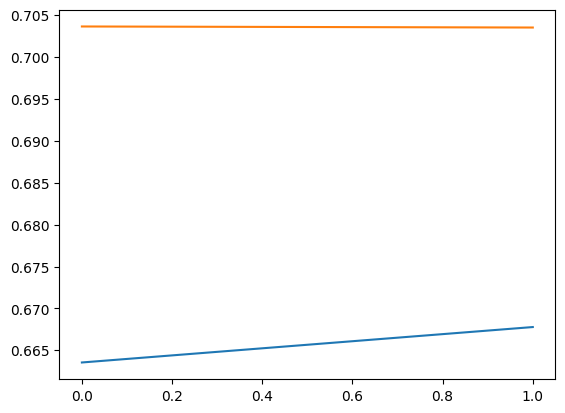

In [17]:

# out_dir_model = '{}/classification_model_4000'.format(out_dir)

test_dir_model = '{}/classification_model_140'.format(out_dir)

PATH = os.path.join(test_dir_model, 'BERTSourceBinaryClassification.pt')
model.load_state_dict(torch.load(PATH))
model.eval()

with open(test_dir_model + '/train_losses.pkl', 'rb') as f:
    train_losses = pickle.load(f)
    
with open(test_dir_model + '/val_losses.pkl', 'rb') as f:
    val_losses = pickle.load(f)

print(val_losses)
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(train_losses)
plt.plot(val_losses)

In [18]:
from tqdm import tqdm
# test_data = test_data[:100]
test_data = TensorDataset(test_x, test_m)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


outputs = []
print('num of iterations: ', len(test_dataloader))
with torch.no_grad():
    for k, (mb_x, mb_m) in tqdm(enumerate(test_dataloader)):
        mb_x = mb_x.cuda()
        mb_m = mb_m.cuda()
#         output, _ = model(mb_x)
        output, attention_weights = model(mb_x, attention_mask=mb_m, max_len=MAX_LENGTH, opt='mean')
#         print(output)
#         print(attention_weights[4])
#         sys.exit(0)
        outputs.append(output[1].to('cpu'))
        
outputs = torch.cat(outputs)

num of iterations:  50


2it [00:01,  1.64it/s]

tensor([[[[1.2186e-02, 6.3290e-03, 3.5435e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.9153e-02, 1.5452e-01, 5.7928e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.7296e-02, 9.2080e-02, 8.5325e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.8573e-02, 4.9365e-02, 3.9554e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.9473e-02, 4.7002e-02, 3.7990e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [9.1262e-03, 2.5553e-02, 1.4416e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[8.9860e-01, 3.0597e-03, 1.8640e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.4078e-01, 7.4561e-02, 5.9998e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.6644e-01, 1.4479e-01, 9.3258e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.4094e-01, 1.4425e-02, 1.9599e-02,  ..., 0.0000

4it [00:01,  3.68it/s]

tensor([[[[5.9116e-03, 4.0669e-03, 4.0988e-03,  ..., 2.1431e-03,
           2.3446e-03, 6.9441e-04],
          [6.3698e-03, 2.4063e-02, 2.3164e-02,  ..., 8.2110e-03,
           1.0626e-02, 2.9705e-04],
          [6.1816e-03, 2.3284e-02, 2.3057e-02,  ..., 8.0939e-03,
           1.0282e-02, 2.9569e-04],
          ...,
          [4.9250e-03, 1.1429e-02, 1.0969e-02,  ..., 2.4720e-02,
           2.5281e-02, 3.7792e-04],
          [5.3565e-03, 1.4085e-02, 1.3180e-02,  ..., 2.3132e-02,
           2.5982e-02, 2.8444e-04],
          [4.4364e-04, 3.9845e-04, 4.1190e-04,  ..., 4.4277e-04,
           3.9189e-04, 1.5037e-03]],

         [[9.3977e-02, 2.0166e-02, 1.4064e-02,  ..., 1.0071e-02,
           1.7098e-02, 5.9418e-05],
          [3.9525e-02, 2.3628e-01, 1.1594e-01,  ..., 6.2906e-03,
           1.9020e-02, 5.7306e-06],
          [2.9188e-02, 2.7024e-01, 1.6714e-01,  ..., 3.5582e-03,
           9.0154e-03, 4.3704e-06],
          ...,
          [3.5999e-03, 2.1538e-03, 2.7280e-03,  ..., 8.9548

8it [00:01,  7.47it/s]

tensor([[[[8.7917e-03, 9.0587e-03, 5.2116e-03,  ..., 2.7618e-03,
           2.6905e-03, 1.0447e-02],
          [1.5404e-02, 2.6250e-02, 3.1181e-02,  ..., 1.2764e-02,
           1.3432e-02, 4.6796e-04],
          [2.6867e-03, 2.2741e-02, 9.5868e-02,  ..., 1.9029e-02,
           4.3582e-03, 8.2523e-05],
          ...,
          [1.7805e-03, 5.9172e-03, 2.3876e-02,  ..., 7.8247e-02,
           1.0348e-02, 7.4707e-04],
          [2.0659e-03, 8.3477e-03, 1.6625e-02,  ..., 5.4790e-02,
           1.3179e-02, 1.6908e-04],
          [1.3780e-04, 7.3656e-05, 1.1901e-05,  ..., 3.1565e-05,
           9.6613e-05, 6.7345e-04]],

         [[7.1930e-02, 7.9030e-02, 1.2896e-02,  ..., 2.8094e-03,
           4.2063e-03, 7.9210e-04],
          [1.8053e-02, 3.1583e-01, 1.7423e-01,  ..., 2.0067e-03,
           2.7393e-03, 5.8790e-05],
          [1.4482e-02, 4.4693e-01, 2.4167e-01,  ..., 9.5615e-04,
           1.4921e-03, 7.9337e-06],
          ...,
          [2.6973e-03, 3.1594e-03, 3.5335e-03,  ..., 3.6946

10it [00:01,  9.09it/s]

tensor([[[[2.3376e-03, 1.7973e-03, 2.5050e-03,  ..., 6.3269e-04,
           1.8531e-03, 3.1472e-03],
          [2.5153e-03, 6.1349e-02, 1.8371e-02,  ..., 4.0937e-03,
           7.2301e-03, 8.4145e-05],
          [4.6874e-03, 4.5553e-02, 1.6705e-02,  ..., 5.9128e-03,
           5.6658e-03, 4.1586e-04],
          ...,
          [6.1732e-03, 9.3676e-03, 1.1223e-02,  ..., 1.4136e-02,
           3.6120e-02, 2.1947e-04],
          [4.3953e-03, 1.6724e-02, 6.1894e-03,  ..., 1.5138e-02,
           1.4256e-02, 1.8291e-04],
          [1.1865e-05, 4.6810e-06, 1.7676e-05,  ..., 3.5816e-06,
           2.0275e-05, 1.4133e-04]],

         [[2.9844e-01, 4.2473e-03, 2.6788e-03,  ..., 6.4510e-03,
           4.6337e-03, 1.2312e-03],
          [4.8420e-02, 5.4805e-01, 5.7540e-02,  ..., 1.6486e-03,
           3.9820e-03, 1.3663e-05],
          [3.0625e-02, 4.0746e-01, 8.0114e-02,  ..., 6.2455e-04,
           1.0599e-03, 1.0933e-05],
          ...,
          [4.0008e-03, 2.0036e-03, 7.9078e-04,  ..., 3.6049

14it [00:02, 11.46it/s]

tensor([[[[5.9116e-03, 4.0669e-03, 4.0988e-03,  ..., 2.1431e-03,
           2.3446e-03, 6.9441e-04],
          [6.3698e-03, 2.4063e-02, 2.3164e-02,  ..., 8.2110e-03,
           1.0626e-02, 2.9705e-04],
          [6.1816e-03, 2.3284e-02, 2.3057e-02,  ..., 8.0939e-03,
           1.0282e-02, 2.9569e-04],
          ...,
          [4.9250e-03, 1.1429e-02, 1.0969e-02,  ..., 2.4720e-02,
           2.5281e-02, 3.7792e-04],
          [5.3565e-03, 1.4085e-02, 1.3180e-02,  ..., 2.3132e-02,
           2.5982e-02, 2.8444e-04],
          [4.4364e-04, 3.9845e-04, 4.1190e-04,  ..., 4.4277e-04,
           3.9189e-04, 1.5037e-03]],

         [[9.3977e-02, 2.0166e-02, 1.4064e-02,  ..., 1.0071e-02,
           1.7098e-02, 5.9418e-05],
          [3.9525e-02, 2.3628e-01, 1.1594e-01,  ..., 6.2906e-03,
           1.9020e-02, 5.7306e-06],
          [2.9188e-02, 2.7024e-01, 1.6714e-01,  ..., 3.5582e-03,
           9.0154e-03, 4.3704e-06],
          ...,
          [3.5999e-03, 2.1538e-03, 2.7280e-03,  ..., 8.9548

16it [00:02, 11.49it/s]

tensor([[[[5.9116e-03, 4.0669e-03, 4.0988e-03,  ..., 2.1431e-03,
           2.3446e-03, 6.9441e-04],
          [6.3698e-03, 2.4063e-02, 2.3164e-02,  ..., 8.2110e-03,
           1.0626e-02, 2.9705e-04],
          [6.1816e-03, 2.3284e-02, 2.3057e-02,  ..., 8.0939e-03,
           1.0282e-02, 2.9569e-04],
          ...,
          [4.9250e-03, 1.1429e-02, 1.0969e-02,  ..., 2.4720e-02,
           2.5281e-02, 3.7792e-04],
          [5.3565e-03, 1.4085e-02, 1.3180e-02,  ..., 2.3132e-02,
           2.5982e-02, 2.8444e-04],
          [4.4364e-04, 3.9845e-04, 4.1190e-04,  ..., 4.4277e-04,
           3.9189e-04, 1.5037e-03]],

         [[9.3977e-02, 2.0166e-02, 1.4064e-02,  ..., 1.0071e-02,
           1.7098e-02, 5.9418e-05],
          [3.9525e-02, 2.3628e-01, 1.1594e-01,  ..., 6.2906e-03,
           1.9020e-02, 5.7306e-06],
          [2.9188e-02, 2.7024e-01, 1.6714e-01,  ..., 3.5582e-03,
           9.0154e-03, 4.3704e-06],
          ...,
          [3.5999e-03, 2.1538e-03, 2.7280e-03,  ..., 8.9548

20it [00:02, 12.83it/s]

tensor([[[[7.9206e-03, 4.6754e-03, 6.7146e-03,  ..., 4.3396e-03,
           2.1939e-03, 2.7313e-03],
          [1.4212e-02, 4.6261e-02, 2.3255e-02,  ..., 2.0208e-02,
           1.4764e-02, 4.8022e-04],
          [6.2016e-03, 1.9783e-02, 3.0854e-02,  ..., 1.4038e-02,
           9.6455e-03, 7.8377e-04],
          ...,
          [6.6795e-03, 1.1092e-02, 3.6153e-03,  ..., 1.0196e-01,
           2.1799e-02, 1.3932e-04],
          [3.4061e-03, 2.4742e-02, 1.1225e-02,  ..., 3.4734e-02,
           7.0067e-02, 1.7920e-04],
          [8.8083e-05, 4.5227e-05, 1.7282e-04,  ..., 1.5734e-04,
           9.0946e-05, 4.0607e-03]],

         [[2.1335e-01, 2.8684e-02, 6.3616e-03,  ..., 1.2082e-02,
           1.2854e-02, 2.0915e-04],
          [7.7340e-02, 4.4227e-01, 7.2480e-02,  ..., 1.1579e-02,
           1.1661e-02, 1.3433e-05],
          [4.3301e-02, 5.6681e-01, 7.5384e-02,  ..., 2.7232e-03,
           3.9483e-03, 3.4217e-05],
          ...,
          [8.8623e-03, 2.2533e-03, 1.7871e-03,  ..., 1.1730

22it [00:02, 12.77it/s]

tensor([[[[5.9116e-03, 4.0669e-03, 4.0988e-03,  ..., 2.1431e-03,
           2.3446e-03, 6.9441e-04],
          [6.3698e-03, 2.4063e-02, 2.3164e-02,  ..., 8.2110e-03,
           1.0626e-02, 2.9705e-04],
          [6.1816e-03, 2.3284e-02, 2.3057e-02,  ..., 8.0939e-03,
           1.0282e-02, 2.9569e-04],
          ...,
          [4.9250e-03, 1.1429e-02, 1.0969e-02,  ..., 2.4720e-02,
           2.5281e-02, 3.7792e-04],
          [5.3565e-03, 1.4085e-02, 1.3180e-02,  ..., 2.3132e-02,
           2.5982e-02, 2.8444e-04],
          [4.4364e-04, 3.9845e-04, 4.1190e-04,  ..., 4.4277e-04,
           3.9189e-04, 1.5037e-03]],

         [[9.3977e-02, 2.0166e-02, 1.4064e-02,  ..., 1.0071e-02,
           1.7098e-02, 5.9418e-05],
          [3.9525e-02, 2.3628e-01, 1.1594e-01,  ..., 6.2906e-03,
           1.9020e-02, 5.7306e-06],
          [2.9188e-02, 2.7024e-01, 1.6714e-01,  ..., 3.5582e-03,
           9.0154e-03, 4.3704e-06],
          ...,
          [3.5999e-03, 2.1538e-03, 2.7280e-03,  ..., 8.9548

26it [00:03, 13.45it/s]

tensor([[[[5.9116e-03, 4.0669e-03, 4.0988e-03,  ..., 2.1431e-03,
           2.3446e-03, 6.9441e-04],
          [6.3698e-03, 2.4063e-02, 2.3164e-02,  ..., 8.2110e-03,
           1.0626e-02, 2.9705e-04],
          [6.1816e-03, 2.3284e-02, 2.3057e-02,  ..., 8.0939e-03,
           1.0282e-02, 2.9569e-04],
          ...,
          [4.9250e-03, 1.1429e-02, 1.0969e-02,  ..., 2.4720e-02,
           2.5281e-02, 3.7792e-04],
          [5.3565e-03, 1.4085e-02, 1.3180e-02,  ..., 2.3132e-02,
           2.5982e-02, 2.8444e-04],
          [4.4364e-04, 3.9845e-04, 4.1190e-04,  ..., 4.4277e-04,
           3.9189e-04, 1.5037e-03]],

         [[9.3977e-02, 2.0166e-02, 1.4064e-02,  ..., 1.0071e-02,
           1.7098e-02, 5.9418e-05],
          [3.9525e-02, 2.3628e-01, 1.1594e-01,  ..., 6.2906e-03,
           1.9020e-02, 5.7306e-06],
          [2.9188e-02, 2.7024e-01, 1.6714e-01,  ..., 3.5582e-03,
           9.0154e-03, 4.3704e-06],
          ...,
          [3.5999e-03, 2.1538e-03, 2.7280e-03,  ..., 8.9548

30it [00:03, 14.11it/s]

tensor([[[[1.1762e-02, 3.0295e-03, 6.1529e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.3655e-02, 1.4387e-01, 8.1922e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.4779e-02, 1.2668e-01, 1.3261e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.9035e-02, 3.1538e-02, 4.9193e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.9877e-02, 3.4717e-02, 4.5684e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [8.2564e-03, 1.3503e-02, 2.3592e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[9.1291e-01, 2.2160e-03, 2.0952e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.6989e-01, 4.9796e-02, 3.4939e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.6943e-01, 8.5524e-02, 7.3649e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.8375e-01, 7.2722e-03, 2.0941e-02,  ..., 0.0000

32it [00:03, 14.20it/s]

tensor([[[[5.9116e-03, 4.0669e-03, 4.0988e-03,  ..., 2.1431e-03,
           2.3446e-03, 6.9441e-04],
          [6.3698e-03, 2.4063e-02, 2.3164e-02,  ..., 8.2110e-03,
           1.0626e-02, 2.9705e-04],
          [6.1816e-03, 2.3284e-02, 2.3057e-02,  ..., 8.0939e-03,
           1.0282e-02, 2.9569e-04],
          ...,
          [4.9250e-03, 1.1429e-02, 1.0969e-02,  ..., 2.4720e-02,
           2.5281e-02, 3.7792e-04],
          [5.3565e-03, 1.4085e-02, 1.3180e-02,  ..., 2.3132e-02,
           2.5982e-02, 2.8444e-04],
          [4.4364e-04, 3.9845e-04, 4.1190e-04,  ..., 4.4277e-04,
           3.9189e-04, 1.5037e-03]],

         [[9.3977e-02, 2.0166e-02, 1.4064e-02,  ..., 1.0071e-02,
           1.7098e-02, 5.9418e-05],
          [3.9525e-02, 2.3628e-01, 1.1594e-01,  ..., 6.2906e-03,
           1.9020e-02, 5.7306e-06],
          [2.9188e-02, 2.7024e-01, 1.6714e-01,  ..., 3.5582e-03,
           9.0154e-03, 4.3704e-06],
          ...,
          [3.5999e-03, 2.1538e-03, 2.7280e-03,  ..., 8.9548

36it [00:03, 14.10it/s]

tensor([[[[5.9116e-03, 4.0669e-03, 4.0988e-03,  ..., 2.1431e-03,
           2.3446e-03, 6.9441e-04],
          [6.3698e-03, 2.4063e-02, 2.3164e-02,  ..., 8.2110e-03,
           1.0626e-02, 2.9705e-04],
          [6.1816e-03, 2.3284e-02, 2.3057e-02,  ..., 8.0939e-03,
           1.0282e-02, 2.9569e-04],
          ...,
          [4.9250e-03, 1.1429e-02, 1.0969e-02,  ..., 2.4720e-02,
           2.5281e-02, 3.7792e-04],
          [5.3565e-03, 1.4085e-02, 1.3180e-02,  ..., 2.3132e-02,
           2.5982e-02, 2.8444e-04],
          [4.4364e-04, 3.9845e-04, 4.1190e-04,  ..., 4.4277e-04,
           3.9189e-04, 1.5037e-03]],

         [[9.3977e-02, 2.0166e-02, 1.4064e-02,  ..., 1.0071e-02,
           1.7098e-02, 5.9418e-05],
          [3.9525e-02, 2.3628e-01, 1.1594e-01,  ..., 6.2906e-03,
           1.9020e-02, 5.7306e-06],
          [2.9188e-02, 2.7024e-01, 1.6714e-01,  ..., 3.5582e-03,
           9.0154e-03, 4.3704e-06],
          ...,
          [3.5999e-03, 2.1538e-03, 2.7280e-03,  ..., 8.9548

40it [00:04, 14.30it/s]

tensor([[[[1.2082e-02, 3.1119e-03, 6.3203e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.0682e-02, 1.2578e-01, 7.1624e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.2382e-02, 1.1443e-01, 1.1979e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.8307e-02, 3.0949e-02, 4.8275e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.8390e-02, 3.3422e-02, 4.3980e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.6731e-03, 9.2778e-03, 1.6211e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[8.9390e-01, 2.1699e-03, 2.0516e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.5044e-01, 4.8538e-02, 3.4056e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.6448e-01, 8.4892e-02, 7.3105e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.5410e-01, 6.9029e-03, 1.9878e-02,  ..., 0.0000

42it [00:04, 14.05it/s]

tensor([[[[8.7382e-03, 2.2507e-03, 9.9093e-03,  ..., 3.9223e-03,
           1.5730e-03, 3.9186e-04],
          [1.6772e-02, 1.0200e-01, 7.6368e-03,  ..., 2.4315e-03,
           1.2647e-02, 4.2136e-05],
          [2.0112e-02, 5.9752e-02, 2.6107e-02,  ..., 4.6835e-03,
           1.2760e-02, 1.0745e-04],
          ...,
          [2.1755e-02, 1.1071e-02, 3.6766e-03,  ..., 1.2232e-02,
           4.0379e-02, 1.1014e-04],
          [2.7105e-02, 5.6154e-03, 8.9928e-03,  ..., 3.0084e-02,
           1.0243e-01, 1.9375e-04],
          [1.2273e-04, 2.1914e-04, 2.2254e-04,  ..., 1.6498e-03,
           1.7714e-04, 2.5252e-04]],

         [[8.5708e-01, 2.0805e-03, 1.2680e-03,  ..., 1.4437e-03,
           7.0515e-03, 1.2380e-06],
          [6.6970e-01, 4.3316e-02, 7.2599e-02,  ..., 8.2414e-04,
           4.2603e-03, 1.0561e-06],
          [6.8203e-01, 7.6698e-02, 7.9040e-02,  ..., 1.8176e-04,
           2.5056e-03, 4.0546e-07],
          ...,
          [7.7386e-02, 7.1836e-04, 1.0922e-03,  ..., 3.4889

44it [00:04, 13.23it/s]

tensor([[[[9.6706e-03, 2.4909e-03, 1.0967e-02,  ..., 2.7989e-03,
           2.1490e-03, 1.9057e-04],
          [1.5974e-02, 9.7152e-02, 7.2736e-03,  ..., 1.5844e-03,
           3.0175e-02, 2.5135e-04],
          [1.9575e-02, 5.8154e-02, 2.5408e-02,  ..., 3.5257e-03,
           1.2439e-02, 2.1496e-04],
          ...,
          [3.3236e-03, 3.5497e-03, 3.7724e-03,  ..., 6.9323e-03,
           2.0193e-02, 6.8385e-05],
          [1.2464e-02, 5.3181e-03, 1.7884e-03,  ..., 1.6555e-02,
           1.2940e-01, 3.5569e-04],
          [2.3388e-04, 2.9484e-04, 1.3205e-04,  ..., 2.7621e-04,
           7.4690e-04, 1.2551e-03]],

         [[8.5307e-01, 2.0707e-03, 1.2620e-03,  ..., 3.9216e-03,
           9.4249e-03, 8.2886e-07],
          [6.7269e-01, 4.3509e-02, 7.2923e-02,  ..., 2.1382e-03,
           3.2731e-03, 4.8968e-07],
          [6.8235e-01, 7.6734e-02, 7.9076e-02,  ..., 6.0709e-04,
           1.5642e-03, 2.7169e-07],
          ...,
          [9.9297e-02, 1.5366e-03, 2.0511e-03,  ..., 1.0158

48it [00:04, 13.64it/s]

tensor([[[[9.4292e-03, 3.7064e-03, 4.8069e-03,  ..., 2.7290e-03,
           8.6005e-03, 1.1048e-04],
          [3.1854e-02, 5.4513e-02, 8.1563e-03,  ..., 2.9487e-03,
           1.3805e-02, 2.3065e-04],
          [7.9690e-03, 2.6573e-02, 9.2812e-03,  ..., 3.7260e-03,
           1.2265e-02, 6.3367e-05],
          ...,
          [4.9720e-03, 9.6300e-03, 3.9275e-03,  ..., 1.0370e-02,
           2.3454e-02, 7.8180e-05],
          [2.1009e-02, 1.1668e-02, 5.7329e-03,  ..., 1.1944e-02,
           9.4892e-02, 2.0113e-04],
          [5.1868e-04, 4.8028e-04, 1.0769e-04,  ..., 1.5512e-04,
           7.8981e-04, 1.9991e-03]],

         [[8.6314e-01, 1.6583e-03, 3.5612e-03,  ..., 3.9679e-03,
           2.8386e-03, 4.9739e-07],
          [6.8581e-01, 8.0906e-02, 5.4864e-02,  ..., 1.9348e-03,
           5.5096e-03, 2.6930e-07],
          [5.7983e-01, 8.4339e-02, 1.5343e-01,  ..., 1.9246e-03,
           1.3062e-03, 2.2324e-07],
          ...,
          [1.0333e-01, 1.1055e-03, 5.5490e-03,  ..., 1.0571

50it [00:04, 10.22it/s]

tensor([[[[1.0975e-02, 2.8269e-03, 1.2446e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.6379e-02, 9.9612e-02, 7.4578e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.3867e-02, 7.0906e-02, 3.0980e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.7061e-02, 2.9943e-02, 2.8809e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.6790e-02, 3.2029e-02, 2.6563e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.0898e-04, 1.1595e-03, 1.1155e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[8.9809e-01, 2.1800e-03, 1.3286e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.1208e-01, 4.6057e-02, 7.7193e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.2106e-01, 8.1088e-02, 8.3563e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.8327e-01, 7.2663e-03, 2.0559e-02,  ..., 0.0000

In [41]:
_, predicted_values = torch.max(outputs, 1)
predicted_values = predicted_values.numpy()
true_values = test_y.numpy()

test_accuracy = np.sum(predicted_values == true_values) / len(true_values)
print ("Test Accuracy:", test_accuracy)



Test Accuracy: 0.54


In [42]:
import itertools

# plot confusion matrix
# code borrowed from scikit-learn.org
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[54  0]
 [46  0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


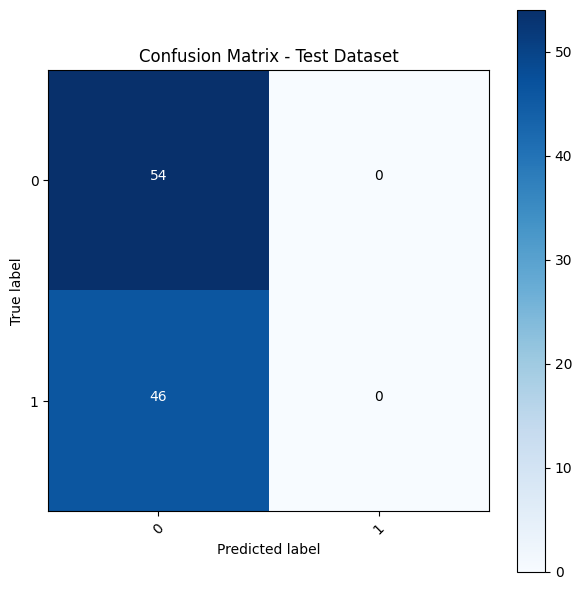

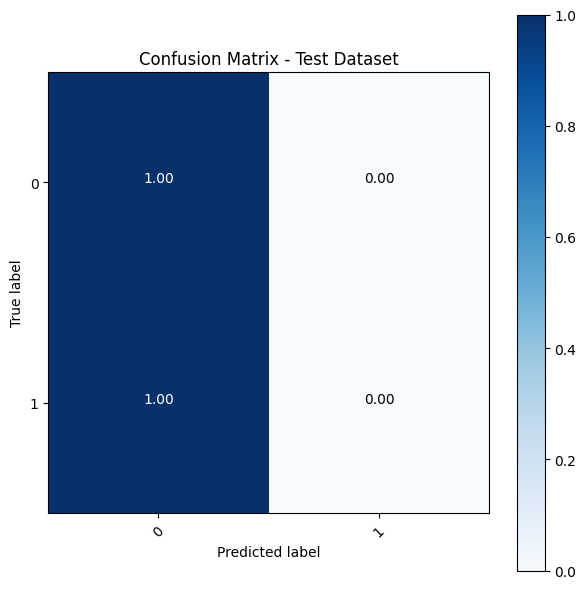

In [43]:
from sklearn.metrics import classification_report, confusion_matrix

cm_test = confusion_matrix(true_values, predicted_values)

np.set_printoptions(precision=2)

plt.figure(figsize=(6,6))
plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset')
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset', normalize=True)